## Vehicle Detection Project

In [1]:
# Pipeline for Project 5
# 1. Extract Features from images
# 2. Train Classifier
# 3. Sliding window to make detections in images

import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import pdb
from skimage.feature import hog
from sklearn.cross_validation import train_test_split
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from scipy.ndimage.measurements import label
import time
import math
%matplotlib inline
test_mode = True

/Users/Akshay/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Method for printing images
def print_image(img, title = ""):
    plt.figure(figsize=(7, 7))
    plt.imshow(img)
    plt.title(title)
    
def print_gray_image(img, title = ""):
    plt.figure(figsize=(7, 7))
    plt.imshow(img, cmap="gray")
    plt.title(title)

In [3]:
# Read in our vehicles and non-vehicles
cars = glob.glob('/Users/Akshay/projects/carnd/CarND-Vehicle-Detection/feature_extraction_data/vehicles/*.jpeg')
notcars = glob.glob('/Users/Akshay/projects/carnd/CarND-Vehicle-Detection/feature_extraction_data/non-vehicles/*.jpeg')
test_images = glob.glob('/Users/Akshay/projects/carnd/CarND-Vehicle-Detection/test_images/*.jpg')

In [4]:
def log(string1, string2):
    print("========")
    print(string1, string2)
    print("========")

In [5]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

In [6]:
# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [7]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

In [8]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, 
                     cspace='RGB', 
                     orient=9, 
                     pix_per_cell=8, 
                     cell_per_block=2,
                     hog_channel=0,
                     spatial_size=(32, 32),
                     hist_bins=32, 
                     hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)
            
        spatial_features = bin_spatial(feature_image, size = spatial_size)
        hist_features = color_hist(feature_image, nbins = hist_bins, bins_range = hist_range)

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        
        
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features, hog_features)))
    # Return list of feature vectors
    return features

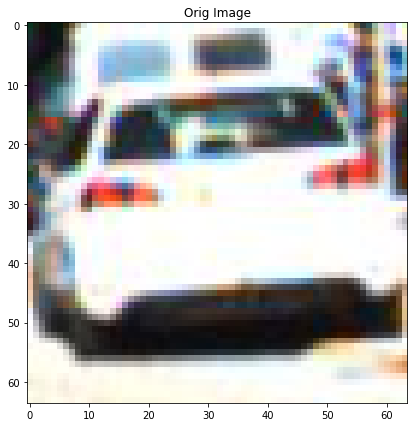

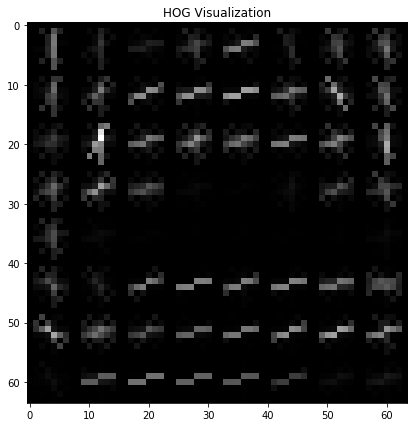

In [9]:
if test_mode:
    # Generate a random index to look at a car image
    ind = np.random.randint(0, len(cars))
    image = mpimg.imread(cars[ind])
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Define HOG parameters
    orient = 9
    pix_per_cell = 8
    cell_per_block = 2
    # Call our function with vis=True to see an image output
    hog_features, hog_image = get_hog_features(gray,
                                               orient,
                                               pix_per_cell,
                                               cell_per_block,
                                               vis=True,
                                               feature_vec=False)

    print_image(image, 'Orig Image')
    print_gray_image(hog_image, 'HOG Visualization')

In [10]:
colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial = 32
histbin = 16

t = time.time()
car_features = extract_features(cars, 
                                cspace = colorspace, 
                                orient = orient, 
                                pix_per_cell = pix_per_cell, 
                                cell_per_block = cell_per_block, 
                                hog_channel = hog_channel,
                                spatial_size=(spatial, spatial),
                                hist_bins=histbin, hist_range=(0, 256))

notcar_features = extract_features(notcars, 
                                   cspace = colorspace, 
                                   orient = orient, 
                                   pix_per_cell = pix_per_cell, 
                                   cell_per_block = cell_per_block, 
                                   hog_channel = hog_channel,
                                   spatial_size=(spatial, spatial),
                                   hist_bins=histbin, hist_range=(0, 256))

t2 = time.time()

print(round(t2-t, 2), 'Seconds to extract HOG features...')

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)

# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector. 1 if car present and 0 if not
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)

X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')

print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()

# Check the training time for the SVC
t = time.time()
svc.fit(X_train, y_train)
t2 = time.time()

print(round(t2-t, 2), 'Seconds to train SVC...')

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# Check the prediction time for a single sample
t = time.time()
n_predict = 10

print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these', n_predict, 'labels: ', y_test[0:n_predict])

t2 = time.time()

print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

16.84 Seconds to extract HOG features...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8412
0.77 Seconds to train SVC...
Test Accuracy of SVC =  0.9914
My SVC predicts:  [ 0.  1.  1.  0.  0.  1.  0.  1.  1.  1.]
For these 10 labels:  [ 0.  1.  1.  0.  0.  1.  0.  1.  1.  1.]
0.00313 Seconds to predict 10 labels with SVC


In [17]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, 
                 x_start_stop=[None, None], 
                 y_start_stop=[None, None], 
                 xy_window=(64, 64), 
                 xy_overlap=(0.5, 0.5)):
    
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):

    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, 
                        color_space='RGB', 
                        spatial_size=(32, 32),
                        hist_bins=32, 
                        orient=9, 
                        pix_per_cell=8, 
                        cell_per_block=2, 
                        hog_channel=0,
                        spatial_feat=True, 
                        hist_feat=True, 
                        hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

In [18]:
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

In [19]:
previous_heatmaps = []

def add_heat(heatmap, bbox_list):
    H = 30
    global previous_heatmaps
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
        
    if len(bbox_list) > 0:
        previous_heatmaps += [heatmap]
        
    for hm in previous_heatmaps[-H:]:
        heatmap[hm == 1] += 1

    # Return updated heatmap
    return heatmap
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def uniform_box_size(bbox):
    min_side_len = 64
    x1 = bbox[0][0]
    y1 = bbox[0][1]
    x2 = bbox[1][0]
    y2 = bbox[1][1]
    
    if (x2 - x1) < min_side_len:
        expand_size = int(((min_side_len - (x2 - x1)) / 2) + 5)
        x1 -= expand_size
        x2 += expand_size
        
    if (y2 - y1) < min_side_len:
        expand_size = int(((min_side_len - (y2 - y1)) / 2))
        y1 -= expand_size
        y2 += expand_size
        
    return ((x1, y1), (x2, y2))
    
def draw_labeled_bboxes(img, labels):
    boxes_to_draw = []
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        bbox = uniform_box_size(bbox)
        boxes_to_draw.append(bbox)
        
    boxes_to_draw = get_qualifying_bboxes(boxes_to_draw)

    for bbox in boxes_to_draw:
        cv2.rectangle(img, bbox[0], bbox[1], (0, 0, 255), 6)
    
    # Return the image
    return img

In [24]:
# Weed out false positives
N = 3
last_n_frames = []
distance_threshold = 64 # pixels

def get_qualifying_bboxes(bboxes):
    #print("Frame #", len(last_n_frames) + 1)
    global last_n_frames
    
    selected_boxes = []
    
    for box in bboxes:
        if qualifies_for_inclusion(box):
            #log("Selecting..", box)
            selected_boxes.append(box)
        else:
            #log("Not Selecting..", box)

    last_n_frames.append(bboxes)
    return selected_boxes
    
def qualifies_for_inclusion(box):
    count = 0
    
    for frame_boxes in last_n_frames[-N:]:
        for frame_box in frame_boxes:
            d = get_distance(box, frame_box)
#             print("========")
#             print("box1", box)
#             print("box2", frame_box)
#             print("distance", d)
#             print("========")
            if(d <= distance_threshold):
                count += 1
                continue # Go to next frame

    if count == N:
        return True

    return False

def get_distance(box1, box2):
    centroid1 = get_centroid(box1)
    centroid2 = get_centroid(box2)
    
    x1 = centroid1[0]
    y1 = centroid1[1]
    
    x2 = centroid2[0]
    y2 = centroid2[1]
    
    d = ((x2 - x1) ** 2) + ((y2 - y1) ** 2)
    return int(math.sqrt(d))

def get_centroid(box):
    x1 = box[0][0]
    y1 = box[0][1]
    x2 = box[1][0]
    y2 = box[1][1]
    
    x = ((x2 + x1) / 2)
    y = ((y2 + y1) / 2)
    
    x = int(x)
    y = int(y)
    
    return (x, y)

IndentationError: expected an indented block (<ipython-input-24-89f9efc46bca>, line 19)

In [25]:
y_start_stop = [384, 640]
x_start_stop = [672, None]

def detect_and_draw(image):
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    draw_image = np.copy(image)
    draw_image = np.copy(image)
    all_windows = []
    for scale_mult in [2, 2.5, 3]:
        windows = slide_window(image, 
                           x_start_stop = x_start_stop, 
                           y_start_stop = y_start_stop, 
                           xy_window=(int(32* scale_mult), int(32 * scale_mult)),
                           xy_overlap=(0.85, 0.85))
        
        if test_mode:
            window_img = draw_boxes(draw_image, windows, color=(255, 0, 0), thick = 6)
            print_image(window_img)
        
        all_windows += windows

    hot_windows = search_windows(image, 
                                 all_windows, 
                                 svc, 
                                 X_scaler, 
                                 color_space = colorspace, 
                                 spatial_size = (spatial, spatial), 
                                 hist_bins = histbin, 
                                 orient = orient, 
                                 pix_per_cell = pix_per_cell, 
                                 cell_per_block = cell_per_block, 
                                 hog_channel = hog_channel, 
                                 spatial_feat = True, 
                                 hist_feat = True, 
                                 hog_feat = True)                       

    heat = add_heat(heat, hot_windows)
    
    if test_mode:
            print_image(heat)
    
    heat = apply_threshold(heat, 2)
    heatmap = np.clip(heat, 0, 255)
    
    
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    if test_mode:
            window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick = 4)
            print_image(window_img)
            
    return draw_img

test_mode = False
if test_mode == True:
    for image in test_images:
        print("Running pipeline on image")
        image = mpimg.imread(image)
        window_img = detect_and_draw(image)
        print_image(window_img)
        #break

In [26]:
if not test_mode:
    output = './p5.mp4'
    clip1 = VideoFileClip("project_video.mp4") #.subclip(4, 20)
    white_clip = clip1.fl_image(detect_and_draw) # NOTE: this function expects color images!!
    %time white_clip.write_videofile(output, audio=False)

Frame # 503
[MoviePy] >>>> Building video ./p5.mp4
[MoviePy] Writing video ./p5.mp4


  0%|          | 1/1261 [00:18<6:34:30, 18.79s/it]

Frame # 504


  0%|          | 2/1261 [00:37<6:34:45, 18.81s/it]

Frame # 505


  0%|          | 3/1261 [00:56<6:33:43, 18.78s/it]

Frame # 506


  0%|          | 4/1261 [01:15<6:33:27, 18.78s/it]

Frame # 507


  0%|          | 5/1261 [01:33<6:33:28, 18.80s/it]

Frame # 508


  0%|          | 6/1261 [01:52<6:32:32, 18.77s/it]

Frame # 509


  1%|          | 7/1261 [02:11<6:31:43, 18.74s/it]

Frame # 510


  1%|          | 8/1261 [02:30<6:31:19, 18.74s/it]

Frame # 511


  1%|          | 9/1261 [02:48<6:30:26, 18.71s/it]

Frame # 512


  1%|          | 10/1261 [03:07<6:29:49, 18.70s/it]

Frame # 513


  1%|          | 11/1261 [03:26<6:29:29, 18.70s/it]

Frame # 514


  1%|          | 12/1261 [03:44<6:29:37, 18.72s/it]

Frame # 515


  1%|          | 13/1261 [04:03<6:29:10, 18.71s/it]

Frame # 516


  1%|          | 14/1261 [04:22<6:29:21, 18.73s/it]

Frame # 517


  1%|          | 15/1261 [04:41<6:28:43, 18.72s/it]

Frame # 518


  1%|▏         | 16/1261 [04:59<6:28:42, 18.73s/it]

Frame # 519


  1%|▏         | 17/1261 [05:18<6:29:05, 18.77s/it]

Frame # 520


  1%|▏         | 18/1261 [05:37<6:29:32, 18.80s/it]

Frame # 521


  2%|▏         | 19/1261 [05:56<6:29:01, 18.79s/it]

Frame # 522


  2%|▏         | 20/1261 [06:14<6:27:21, 18.73s/it]

Frame # 523


  2%|▏         | 21/1261 [06:33<6:26:15, 18.69s/it]

Frame # 524


  2%|▏         | 22/1261 [06:52<6:26:11, 18.70s/it]

Frame # 525


  2%|▏         | 23/1261 [07:10<6:26:20, 18.72s/it]

Frame # 526


  2%|▏         | 24/1261 [07:29<6:26:24, 18.74s/it]

Frame # 527


  2%|▏         | 25/1261 [07:48<6:25:57, 18.74s/it]

Frame # 528


  2%|▏         | 26/1261 [08:07<6:26:05, 18.76s/it]

Frame # 529


  2%|▏         | 27/1261 [08:26<6:25:43, 18.75s/it]

Frame # 530


  2%|▏         | 28/1261 [08:44<6:24:56, 18.73s/it]

Frame # 531


  2%|▏         | 29/1261 [09:03<6:24:50, 18.74s/it]

Frame # 532


  2%|▏         | 30/1261 [09:22<6:24:37, 18.75s/it]

Frame # 533


  2%|▏         | 31/1261 [09:41<6:24:43, 18.77s/it]

Frame # 534


  3%|▎         | 32/1261 [09:59<6:23:41, 18.73s/it]

Frame # 535


  3%|▎         | 33/1261 [10:18<6:22:58, 18.71s/it]

Frame # 536


  3%|▎         | 34/1261 [10:37<6:22:25, 18.70s/it]

Frame # 537


  3%|▎         | 35/1261 [10:55<6:21:17, 18.66s/it]

Frame # 538


  3%|▎         | 36/1261 [11:14<6:21:30, 18.69s/it]

Frame # 539


  3%|▎         | 37/1261 [11:33<6:21:35, 18.71s/it]

Frame # 540


  3%|▎         | 38/1261 [11:51<6:21:39, 18.72s/it]

Frame # 541


  3%|▎         | 39/1261 [12:10<6:21:50, 18.75s/it]

Frame # 542


  3%|▎         | 40/1261 [12:29<6:21:14, 18.73s/it]

Frame # 543


  3%|▎         | 41/1261 [12:48<6:21:17, 18.75s/it]

Frame # 544


  3%|▎         | 42/1261 [13:06<6:21:11, 18.76s/it]

Frame # 545


  3%|▎         | 43/1261 [13:25<6:20:27, 18.74s/it]

Frame # 546


  3%|▎         | 44/1261 [13:44<6:20:49, 18.78s/it]

Frame # 547


  4%|▎         | 45/1261 [14:03<6:20:15, 18.76s/it]

Frame # 548


  4%|▎         | 46/1261 [14:21<6:19:30, 18.74s/it]

Frame # 549


  4%|▎         | 47/1261 [14:40<6:19:10, 18.74s/it]

Frame # 550


  4%|▍         | 48/1261 [14:59<6:18:25, 18.72s/it]

Frame # 551


  4%|▍         | 49/1261 [15:18<6:17:49, 18.70s/it]

Frame # 552


  4%|▍         | 50/1261 [15:36<6:17:54, 18.72s/it]

Frame # 553


  4%|▍         | 51/1261 [15:55<6:18:16, 18.76s/it]

Frame # 554


  4%|▍         | 52/1261 [16:14<6:18:25, 18.78s/it]

Frame # 555


  4%|▍         | 53/1261 [16:33<6:18:11, 18.78s/it]

Frame # 556


  4%|▍         | 54/1261 [16:51<6:17:35, 18.77s/it]

Frame # 557


  4%|▍         | 55/1261 [17:10<6:17:11, 18.77s/it]

Frame # 558


  4%|▍         | 56/1261 [17:29<6:17:04, 18.78s/it]

Frame # 559


  5%|▍         | 57/1261 [17:48<6:16:31, 18.76s/it]

Frame # 560


  5%|▍         | 58/1261 [18:07<6:17:17, 18.82s/it]

Frame # 561


  5%|▍         | 59/1261 [18:26<6:17:14, 18.83s/it]

Frame # 562


  5%|▍         | 60/1261 [18:44<6:16:02, 18.79s/it]

Frame # 563


  5%|▍         | 61/1261 [19:03<6:15:46, 18.79s/it]

Frame # 564


  5%|▍         | 62/1261 [19:22<6:15:28, 18.79s/it]

Frame # 565


  5%|▍         | 63/1261 [19:41<6:15:05, 18.79s/it]

Frame # 566


  5%|▌         | 64/1261 [19:59<6:14:33, 18.77s/it]

Frame # 567


  5%|▌         | 65/1261 [20:18<6:14:04, 18.77s/it]

Frame # 568


  5%|▌         | 66/1261 [20:37<6:13:51, 18.77s/it]

Frame # 569


  5%|▌         | 67/1261 [20:56<6:13:52, 18.79s/it]

Frame # 570


  5%|▌         | 68/1261 [21:14<6:13:06, 18.76s/it]

Frame # 571


  5%|▌         | 69/1261 [21:33<6:13:13, 18.79s/it]

Frame # 572


  6%|▌         | 70/1261 [21:52<6:13:15, 18.80s/it]

Frame # 573


  6%|▌         | 71/1261 [22:11<6:12:27, 18.78s/it]

Frame # 574


  6%|▌         | 72/1261 [22:30<6:11:40, 18.76s/it]

Frame # 575


  6%|▌         | 73/1261 [22:48<6:11:38, 18.77s/it]

Frame # 576


  6%|▌         | 74/1261 [23:07<6:10:53, 18.75s/it]

Frame # 577


  6%|▌         | 75/1261 [23:26<6:10:25, 18.74s/it]

Frame # 578


  6%|▌         | 76/1261 [23:45<6:10:45, 18.77s/it]

Frame # 579


  6%|▌         | 77/1261 [24:04<6:11:20, 18.82s/it]

Frame # 580


  6%|▌         | 78/1261 [24:22<6:11:03, 18.82s/it]

Frame # 581


  6%|▋         | 79/1261 [24:41<6:11:10, 18.84s/it]

Frame # 582


  6%|▋         | 80/1261 [25:00<6:09:34, 18.78s/it]

Frame # 583


  6%|▋         | 81/1261 [25:18<6:07:08, 18.67s/it]

Frame # 584


  7%|▋         | 82/1261 [25:37<6:07:03, 18.68s/it]

Frame # 585


  7%|▋         | 83/1261 [25:56<6:06:44, 18.68s/it]

Frame # 586


  7%|▋         | 84/1261 [26:14<6:06:42, 18.69s/it]

Frame # 587


  7%|▋         | 85/1261 [26:33<6:06:03, 18.68s/it]

Frame # 588


  7%|▋         | 86/1261 [26:52<6:05:56, 18.69s/it]

Frame # 589


  7%|▋         | 87/1261 [27:10<6:05:48, 18.70s/it]

Frame # 590


  7%|▋         | 88/1261 [27:29<6:05:49, 18.71s/it]

Frame # 591


  7%|▋         | 89/1261 [27:48<6:05:50, 18.73s/it]

Frame # 592


  7%|▋         | 90/1261 [28:07<6:05:15, 18.71s/it]

Frame # 593


  7%|▋         | 91/1261 [28:25<6:04:39, 18.70s/it]

Frame # 594


  7%|▋         | 92/1261 [28:44<6:03:58, 18.68s/it]

Frame # 595


  7%|▋         | 93/1261 [29:03<6:03:17, 18.66s/it]

Frame # 596


  7%|▋         | 94/1261 [29:21<6:02:54, 18.66s/it]

Frame # 597


  8%|▊         | 95/1261 [29:40<6:02:15, 18.64s/it]

Frame # 598


  8%|▊         | 96/1261 [29:58<6:01:51, 18.64s/it]

Frame # 599


  8%|▊         | 97/1261 [30:17<6:01:38, 18.64s/it]

Frame # 600


  8%|▊         | 98/1261 [30:36<6:01:22, 18.64s/it]

Frame # 601


  8%|▊         | 99/1261 [30:55<6:01:36, 18.67s/it]

Frame # 602


  8%|▊         | 100/1261 [31:13<6:01:17, 18.67s/it]

Frame # 603


  8%|▊         | 101/1261 [31:32<6:01:33, 18.70s/it]

Frame # 604


  8%|▊         | 102/1261 [31:51<6:01:24, 18.71s/it]

Frame # 605


  8%|▊         | 103/1261 [32:09<6:01:20, 18.72s/it]

Frame # 606


  8%|▊         | 104/1261 [32:28<6:00:57, 18.72s/it]

Frame # 607


  8%|▊         | 105/1261 [32:47<6:01:21, 18.76s/it]

Frame # 608


  8%|▊         | 106/1261 [33:06<6:00:24, 18.72s/it]

Frame # 609


  8%|▊         | 107/1261 [33:24<6:00:33, 18.75s/it]

Frame # 610


  9%|▊         | 108/1261 [33:43<6:00:38, 18.77s/it]

Frame # 611


  9%|▊         | 109/1261 [34:02<6:00:10, 18.76s/it]

Frame # 612


  9%|▊         | 110/1261 [34:21<5:59:58, 18.76s/it]

Frame # 613


  9%|▉         | 111/1261 [34:39<5:59:04, 18.73s/it]

Frame # 614


  9%|▉         | 112/1261 [34:58<5:58:25, 18.72s/it]

Frame # 615


  9%|▉         | 113/1261 [35:17<5:58:12, 18.72s/it]

Frame # 616


  9%|▉         | 114/1261 [35:36<5:58:47, 18.77s/it]

Frame # 617


  9%|▉         | 115/1261 [35:54<5:57:53, 18.74s/it]

Frame # 618


  9%|▉         | 116/1261 [36:13<5:57:46, 18.75s/it]

Frame # 619


  9%|▉         | 117/1261 [36:32<5:57:18, 18.74s/it]

Frame # 620


  9%|▉         | 118/1261 [36:51<5:56:51, 18.73s/it]

Frame # 621


  9%|▉         | 119/1261 [37:09<5:56:22, 18.72s/it]

Frame # 622


 10%|▉         | 120/1261 [37:28<5:55:44, 18.71s/it]

Frame # 623


 10%|▉         | 121/1261 [37:47<5:55:38, 18.72s/it]

Frame # 624


 10%|▉         | 122/1261 [38:05<5:54:27, 18.67s/it]

Frame # 625


 10%|▉         | 123/1261 [38:24<5:53:34, 18.64s/it]

Frame # 626


 10%|▉         | 124/1261 [38:42<5:53:18, 18.64s/it]

Frame # 627


 10%|▉         | 125/1261 [39:01<5:53:03, 18.65s/it]

Frame # 628


 10%|▉         | 126/1261 [39:20<5:53:09, 18.67s/it]

Frame # 629


 10%|█         | 127/1261 [39:39<5:53:55, 18.73s/it]

Frame # 630


 10%|█         | 128/1261 [39:57<5:53:47, 18.74s/it]

Frame # 631


 10%|█         | 129/1261 [40:16<5:53:05, 18.71s/it]

Frame # 632


 10%|█         | 130/1261 [40:35<5:52:23, 18.69s/it]

Frame # 633


 10%|█         | 131/1261 [40:53<5:52:08, 18.70s/it]

Frame # 634


 10%|█         | 132/1261 [41:12<5:51:58, 18.71s/it]

Frame # 635


 11%|█         | 133/1261 [41:31<5:52:05, 18.73s/it]

Frame # 636


 11%|█         | 134/1261 [41:50<5:52:06, 18.75s/it]

Frame # 637


 11%|█         | 135/1261 [42:09<5:52:00, 18.76s/it]

Frame # 638


 11%|█         | 136/1261 [42:27<5:52:23, 18.79s/it]

Frame # 639


 11%|█         | 137/1261 [42:46<5:52:08, 18.80s/it]

Frame # 640


 11%|█         | 138/1261 [43:05<5:51:19, 18.77s/it]

Frame # 641


 11%|█         | 139/1261 [43:24<5:51:23, 18.79s/it]

Frame # 642


 11%|█         | 140/1261 [43:43<5:51:49, 18.83s/it]

Frame # 643


 11%|█         | 141/1261 [44:02<5:51:57, 18.85s/it]

Frame # 644


 11%|█▏        | 142/1261 [44:21<5:52:18, 18.89s/it]

Frame # 645


 11%|█▏        | 143/1261 [44:40<5:51:58, 18.89s/it]

Frame # 646


 11%|█▏        | 144/1261 [44:58<5:51:33, 18.88s/it]

Frame # 647


 11%|█▏        | 145/1261 [45:17<5:50:36, 18.85s/it]

Frame # 648


 12%|█▏        | 146/1261 [45:36<5:50:42, 18.87s/it]

Frame # 649


 12%|█▏        | 147/1261 [45:55<5:50:12, 18.86s/it]

Frame # 650


 12%|█▏        | 148/1261 [46:14<5:49:58, 18.87s/it]

Frame # 651


 12%|█▏        | 149/1261 [46:33<5:49:26, 18.85s/it]

Frame # 652


 12%|█▏        | 150/1261 [46:51<5:49:17, 18.86s/it]

Frame # 653


 12%|█▏        | 151/1261 [47:10<5:48:48, 18.85s/it]

Frame # 654


 12%|█▏        | 152/1261 [47:29<5:47:50, 18.82s/it]

Frame # 655


 12%|█▏        | 153/1261 [47:48<5:47:06, 18.80s/it]

Frame # 656


 12%|█▏        | 154/1261 [48:07<5:46:21, 18.77s/it]

Frame # 657


 12%|█▏        | 155/1261 [48:25<5:46:30, 18.80s/it]

Frame # 658


 12%|█▏        | 156/1261 [48:44<5:46:17, 18.80s/it]

Frame # 659
Not Selecting.. ((1202, 393), (1276, 456))


 12%|█▏        | 157/1261 [49:03<5:45:55, 18.80s/it]

Frame # 660
Not Selecting.. ((1198, 393), (1271, 456))


 13%|█▎        | 158/1261 [49:22<5:45:20, 18.79s/it]

Frame # 661
Not Selecting.. ((1194, 393), (1275, 463))


 13%|█▎        | 159/1261 [49:41<5:44:58, 18.78s/it]

Frame # 662
Selecting.. ((1194, 384), (1275, 463))


 13%|█▎        | 160/1261 [49:59<5:45:02, 18.80s/it]

Frame # 663
Selecting.. ((1194, 384), (1275, 463))


 13%|█▎        | 161/1261 [50:18<5:44:40, 18.80s/it]

Frame # 664
Selecting.. ((1188, 384), (1275, 465))


 13%|█▎        | 162/1261 [50:37<5:44:21, 18.80s/it]

Frame # 665
Selecting.. ((1185, 384), (1275, 475))


 13%|█▎        | 163/1261 [50:56<5:43:59, 18.80s/it]

Frame # 666
Selecting.. ((1188, 384), (1275, 475))


 13%|█▎        | 164/1261 [51:15<5:43:28, 18.79s/it]

Frame # 667
Selecting.. ((1176, 384), (1275, 475))


 13%|█▎        | 165/1261 [51:33<5:43:39, 18.81s/it]

Frame # 668
Selecting.. ((1176, 384), (1275, 475))


 13%|█▎        | 166/1261 [51:52<5:43:52, 18.84s/it]

Frame # 669
Selecting.. ((1176, 384), (1275, 475))


 13%|█▎        | 167/1261 [52:11<5:43:15, 18.83s/it]

Frame # 670
Selecting.. ((1176, 384), (1275, 475))


 13%|█▎        | 168/1261 [52:30<5:42:58, 18.83s/it]

Frame # 671
Selecting.. ((1167, 384), (1275, 475))


 13%|█▎        | 169/1261 [52:49<5:43:17, 18.86s/it]

Frame # 672
Selecting.. ((1167, 384), (1271, 475))


 13%|█▎        | 170/1261 [53:08<5:42:07, 18.82s/it]

Frame # 673
Selecting.. ((1164, 384), (1271, 479))


 14%|█▎        | 171/1261 [53:26<5:42:05, 18.83s/it]

Frame # 674
Selecting.. ((1164, 384), (1271, 479))


 14%|█▎        | 172/1261 [53:45<5:42:27, 18.87s/it]

Frame # 675
Selecting.. ((1162, 384), (1271, 479))


 14%|█▎        | 173/1261 [54:04<5:42:03, 18.86s/it]

Frame # 676
Selecting.. ((1162, 384), (1267, 479))


 14%|█▍        | 174/1261 [54:23<5:41:41, 18.86s/it]

Frame # 677
Selecting.. ((1152, 384), (1257, 479))


 14%|█▍        | 175/1261 [54:42<5:41:27, 18.87s/it]

Frame # 678
Selecting.. ((1149, 384), (1257, 479))


 14%|█▍        | 176/1261 [55:01<5:40:45, 18.84s/it]

Frame # 679
Selecting.. ((1149, 384), (1257, 479))


 14%|█▍        | 177/1261 [55:20<5:40:31, 18.85s/it]

Frame # 680
Selecting.. ((1149, 384), (1257, 479))


 14%|█▍        | 178/1261 [55:38<5:40:13, 18.85s/it]

Frame # 681
Selecting.. ((1148, 384), (1255, 479))


 14%|█▍        | 179/1261 [55:57<5:40:04, 18.86s/it]

Frame # 682
Selecting.. ((1140, 384), (1248, 479))


 14%|█▍        | 180/1261 [56:16<5:39:23, 18.84s/it]

Frame # 683
Selecting.. ((1140, 384), (1248, 479))


 14%|█▍        | 181/1261 [56:35<5:38:59, 18.83s/it]

Frame # 684
Selecting.. ((1140, 384), (1243, 479))


 14%|█▍        | 182/1261 [56:54<5:38:39, 18.83s/it]

Frame # 685
Selecting.. ((1140, 384), (1243, 465))


 15%|█▍        | 183/1261 [57:13<5:38:35, 18.85s/it]

Frame # 686
Selecting.. ((1134, 384), (1243, 479))


 15%|█▍        | 184/1261 [57:31<5:37:40, 18.81s/it]

Frame # 687
Selecting.. ((1131, 384), (1239, 479))


 15%|█▍        | 185/1261 [57:50<5:36:37, 18.77s/it]

Frame # 688
Selecting.. ((1128, 384), (1243, 479))


 15%|█▍        | 186/1261 [58:09<5:36:25, 18.78s/it]

Frame # 689
Selecting.. ((1128, 384), (1239, 479))


 15%|█▍        | 187/1261 [58:28<5:36:07, 18.78s/it]

Frame # 690
Selecting.. ((1128, 384), (1231, 479))


 15%|█▍        | 188/1261 [58:46<5:35:45, 18.77s/it]

Frame # 691
Selecting.. ((1128, 384), (1239, 479))


 15%|█▍        | 189/1261 [59:05<5:35:22, 18.77s/it]

Frame # 692
Selecting.. ((1128, 384), (1231, 479))


 15%|█▌        | 190/1261 [59:24<5:36:13, 18.84s/it]

Frame # 693
Selecting.. ((1120, 384), (1231, 479))


 15%|█▌        | 191/1261 [59:43<5:36:33, 18.87s/it]

Frame # 694
Selecting.. ((1116, 384), (1231, 479))


 15%|█▌        | 192/1261 [1:00:02<5:35:58, 18.86s/it]

Frame # 695
Selecting.. ((1116, 384), (1230, 479))


 15%|█▌        | 193/1261 [1:00:21<5:35:32, 18.85s/it]

Frame # 696
Selecting.. ((1116, 384), (1229, 479))


 15%|█▌        | 194/1261 [1:00:40<5:35:16, 18.85s/it]

Frame # 697
Selecting.. ((1116, 384), (1221, 479))


 15%|█▌        | 195/1261 [1:00:59<5:34:59, 18.85s/it]

Frame # 698
Selecting.. ((1116, 384), (1221, 479))


 16%|█▌        | 196/1261 [1:01:17<5:34:42, 18.86s/it]

Frame # 699
Selecting.. ((1116, 384), (1221, 479))


 16%|█▌        | 197/1261 [1:01:36<5:34:05, 18.84s/it]

Frame # 700
Selecting.. ((1120, 384), (1229, 475))


 16%|█▌        | 198/1261 [1:01:55<5:34:05, 18.86s/it]

Frame # 701
Selecting.. ((1120, 384), (1219, 465))


 16%|█▌        | 199/1261 [1:02:14<5:33:32, 18.84s/it]

Frame # 702
Selecting.. ((1122, 384), (1219, 463))


 16%|█▌        | 200/1261 [1:02:33<5:33:12, 18.84s/it]

Frame # 703
Selecting.. ((1116, 384), (1219, 463))


 16%|█▌        | 201/1261 [1:02:51<5:32:27, 18.82s/it]

Frame # 704
Selecting.. ((1113, 384), (1219, 463))


 16%|█▌        | 202/1261 [1:03:10<5:32:06, 18.82s/it]

Frame # 705
Selecting.. ((1113, 384), (1266, 474))


 16%|█▌        | 203/1261 [1:03:29<5:32:00, 18.83s/it]

Frame # 706
Selecting.. ((1113, 384), (1271, 479))


 16%|█▌        | 204/1261 [1:03:48<5:31:57, 18.84s/it]

Frame # 707
Selecting.. ((1106, 384), (1271, 479))


 16%|█▋        | 205/1261 [1:04:07<5:31:28, 18.83s/it]

Frame # 708
Selecting.. ((1106, 384), (1271, 479))


 16%|█▋        | 206/1261 [1:04:26<5:30:21, 18.79s/it]

Frame # 709
Selecting.. ((1104, 384), (1271, 479))


 16%|█▋        | 207/1261 [1:04:44<5:30:31, 18.82s/it]

Frame # 710
Selecting.. ((1104, 384), (1271, 479))


 16%|█▋        | 208/1261 [1:05:03<5:30:22, 18.82s/it]

Frame # 711
Selecting.. ((1104, 384), (1219, 479))


 17%|█▋        | 209/1261 [1:05:22<5:29:53, 18.81s/it]

Frame # 712
Selecting.. ((1104, 384), (1271, 479))


 17%|█▋        | 210/1261 [1:05:41<5:30:34, 18.87s/it]

Frame # 713
Selecting.. ((1104, 384), (1271, 479))


 17%|█▋        | 211/1261 [1:06:00<5:30:14, 18.87s/it]

Frame # 714
Selecting.. ((1104, 384), (1267, 479))


 17%|█▋        | 212/1261 [1:06:19<5:29:25, 18.84s/it]

Frame # 715
Selecting.. ((1104, 384), (1267, 474))


 17%|█▋        | 213/1261 [1:06:37<5:28:51, 18.83s/it]

Frame # 716
Selecting.. ((1104, 384), (1271, 479))


 17%|█▋        | 214/1261 [1:06:56<5:27:37, 18.77s/it]

Frame # 717
Selecting.. ((1104, 384), (1271, 479))


 17%|█▋        | 215/1261 [1:07:15<5:27:59, 18.81s/it]

Frame # 718
Selecting.. ((1092, 384), (1271, 479))


 17%|█▋        | 216/1261 [1:07:34<5:28:36, 18.87s/it]

Frame # 719
Selecting.. ((1092, 384), (1271, 479))


 17%|█▋        | 217/1261 [1:07:53<5:28:33, 18.88s/it]

Frame # 720
Selecting.. ((1092, 384), (1267, 479))


 17%|█▋        | 218/1261 [1:08:12<5:28:13, 18.88s/it]

Frame # 721
Selecting.. ((1092, 384), (1271, 475))


 17%|█▋        | 219/1261 [1:08:31<5:27:53, 18.88s/it]

Frame # 722
Selecting.. ((1092, 384), (1271, 479))


 17%|█▋        | 220/1261 [1:08:50<5:27:09, 18.86s/it]

Frame # 723
Selecting.. ((1092, 384), (1267, 475))


 18%|█▊        | 221/1261 [1:09:08<5:26:43, 18.85s/it]

Frame # 724
Selecting.. ((1092, 384), (1267, 479))


 18%|█▊        | 222/1261 [1:09:27<5:26:04, 18.83s/it]

Frame # 725
Selecting.. ((1092, 384), (1267, 475))


 18%|█▊        | 223/1261 [1:09:46<5:26:02, 18.85s/it]

Frame # 726
Selecting.. ((1092, 384), (1267, 475))


 18%|█▊        | 224/1261 [1:10:05<5:25:30, 18.83s/it]

Frame # 727
Selecting.. ((1092, 384), (1267, 479))


 18%|█▊        | 225/1261 [1:10:24<5:24:38, 18.80s/it]

Frame # 728
Selecting.. ((1092, 384), (1267, 479))


 18%|█▊        | 226/1261 [1:10:42<5:24:14, 18.80s/it]

Frame # 729
Selecting.. ((1092, 384), (1267, 479))


 18%|█▊        | 227/1261 [1:11:01<5:23:26, 18.77s/it]

Frame # 730
Selecting.. ((1086, 384), (1267, 479))


 18%|█▊        | 228/1261 [1:11:20<5:23:06, 18.77s/it]

Frame # 731
Selecting.. ((1086, 384), (1267, 479))


 18%|█▊        | 229/1261 [1:11:39<5:23:32, 18.81s/it]

Frame # 732
Selecting.. ((1086, 384), (1267, 479))


 18%|█▊        | 230/1261 [1:11:58<5:23:12, 18.81s/it]

Frame # 733
Selecting.. ((1080, 384), (1267, 479))


 18%|█▊        | 231/1261 [1:12:16<5:22:02, 18.76s/it]

Frame # 734
Selecting.. ((1080, 384), (1267, 479))


 18%|█▊        | 232/1261 [1:12:35<5:21:50, 18.77s/it]

Frame # 735
Selecting.. ((1080, 384), (1271, 479))


 18%|█▊        | 233/1261 [1:12:54<5:21:35, 18.77s/it]

Frame # 736
Selecting.. ((1080, 384), (1267, 479))


 19%|█▊        | 234/1261 [1:13:13<5:21:26, 18.78s/it]

Frame # 737
Selecting.. ((1080, 384), (1267, 479))


 19%|█▊        | 235/1261 [1:13:31<5:20:56, 18.77s/it]

Frame # 738
Selecting.. ((1077, 384), (1267, 479))


 19%|█▊        | 236/1261 [1:13:50<5:20:43, 18.77s/it]

Frame # 739
Selecting.. ((1077, 384), (1271, 479))


 19%|█▉        | 237/1261 [1:14:09<5:20:47, 18.80s/it]

Frame # 740
Selecting.. ((1077, 384), (1271, 479))


 19%|█▉        | 238/1261 [1:14:28<5:20:57, 18.82s/it]

Frame # 741
Selecting.. ((1077, 384), (1271, 479))


 19%|█▉        | 239/1261 [1:14:47<5:20:14, 18.80s/it]

Frame # 742
Selecting.. ((1077, 384), (1271, 479))


 19%|█▉        | 240/1261 [1:15:05<5:19:37, 18.78s/it]

Frame # 743
Selecting.. ((1068, 384), (1271, 479))


 19%|█▉        | 241/1261 [1:15:24<5:19:42, 18.81s/it]

Frame # 744
Selecting.. ((1068, 384), (1267, 479))


 19%|█▉        | 242/1261 [1:15:43<5:19:17, 18.80s/it]

Frame # 745
Selecting.. ((1068, 384), (1267, 479))


 19%|█▉        | 243/1261 [1:16:02<5:18:25, 18.77s/it]

Frame # 746
Selecting.. ((1068, 384), (1257, 479))


 19%|█▉        | 244/1261 [1:16:20<5:17:22, 18.72s/it]

Frame # 747
Selecting.. ((1068, 384), (1267, 479))


 19%|█▉        | 245/1261 [1:16:39<5:17:07, 18.73s/it]

Frame # 748
Selecting.. ((1064, 384), (1257, 479))


 20%|█▉        | 246/1261 [1:16:58<5:16:34, 18.71s/it]

Frame # 749
Selecting.. ((1064, 384), (1257, 479))


 20%|█▉        | 247/1261 [1:17:16<5:16:37, 18.74s/it]

Frame # 750
Selecting.. ((1064, 384), (1267, 479))


 20%|█▉        | 248/1261 [1:17:35<5:16:34, 18.75s/it]

Frame # 751
Selecting.. ((1064, 384), (1267, 479))


 20%|█▉        | 249/1261 [1:17:54<5:15:32, 18.71s/it]

Frame # 752
Selecting.. ((1059, 384), (1257, 479))


 20%|█▉        | 250/1261 [1:18:13<5:15:43, 18.74s/it]

Frame # 753
Selecting.. ((1056, 384), (1267, 479))


 20%|█▉        | 251/1261 [1:18:31<5:15:26, 18.74s/it]

Frame # 754
Selecting.. ((1056, 384), (1257, 479))


 20%|█▉        | 252/1261 [1:18:50<5:15:02, 18.73s/it]

Frame # 755
Selecting.. ((1056, 384), (1257, 479))


 20%|██        | 253/1261 [1:19:09<5:15:14, 18.76s/it]

Frame # 756
Selecting.. ((1056, 384), (1255, 479))


 20%|██        | 254/1261 [1:19:28<5:15:16, 18.79s/it]

Frame # 757
Selecting.. ((1056, 384), (1257, 479))


 20%|██        | 255/1261 [1:19:47<5:15:03, 18.79s/it]

Frame # 758
Selecting.. ((1056, 384), (1257, 479))


 20%|██        | 256/1261 [1:20:05<5:15:18, 18.82s/it]

Frame # 759
Selecting.. ((1056, 384), (1257, 479))


 20%|██        | 257/1261 [1:20:24<5:15:22, 18.85s/it]

Frame # 760
Selecting.. ((1056, 384), (1271, 493))


 20%|██        | 258/1261 [1:20:43<5:15:00, 18.84s/it]

Frame # 761
Selecting.. ((1056, 384), (1267, 493))
Not Selecting.. ((966, 420), (1039, 493))
Not Selecting.. ((1005, 418), (1078, 481))
Not Selecting.. ((1014, 418), (1087, 481))


 21%|██        | 259/1261 [1:21:02<5:14:58, 18.86s/it]

Frame # 762
Selecting.. ((1050, 384), (1267, 493))
Selecting.. ((960, 398), (1047, 499))


 21%|██        | 260/1261 [1:21:21<5:15:06, 18.89s/it]

Frame # 763
Selecting.. ((1050, 384), (1267, 493))
Not Selecting.. ((1009, 406), (1082, 469))


 21%|██        | 261/1261 [1:21:40<5:13:51, 18.83s/it]

Frame # 764
Selecting.. ((1050, 384), (1257, 479))


 21%|██        | 262/1261 [1:21:59<5:13:47, 18.85s/it]

Frame # 765
Selecting.. ((1050, 384), (1257, 479))


 21%|██        | 263/1261 [1:22:18<5:13:38, 18.86s/it]

Frame # 766
Selecting.. ((1044, 384), (1267, 479))


 21%|██        | 264/1261 [1:22:36<5:12:57, 18.83s/it]

Frame # 767
Selecting.. ((1050, 384), (1257, 487))


 21%|██        | 265/1261 [1:22:55<5:13:14, 18.87s/it]

Frame # 768
Selecting.. ((1050, 384), (1257, 487))


 21%|██        | 266/1261 [1:23:14<5:13:29, 18.90s/it]

Frame # 769
Selecting.. ((1050, 384), (1267, 493))


 21%|██        | 267/1261 [1:23:33<5:12:27, 18.86s/it]

Frame # 770
Selecting.. ((1050, 384), (1267, 493))


 21%|██▏       | 268/1261 [1:23:52<5:11:54, 18.85s/it]

Frame # 771
Selecting.. ((1050, 384), (1271, 507))


 21%|██▏       | 269/1261 [1:24:11<5:11:49, 18.86s/it]

Frame # 772
Selecting.. ((1050, 384), (1271, 507))


 21%|██▏       | 270/1261 [1:24:29<5:11:04, 18.83s/it]

Frame # 773
Selecting.. ((1050, 384), (1271, 523))


 21%|██▏       | 271/1261 [1:24:48<5:10:22, 18.81s/it]

Frame # 774
Selecting.. ((1044, 384), (1257, 493))


 22%|██▏       | 272/1261 [1:25:07<5:09:55, 18.80s/it]

Frame # 775
Selecting.. ((1044, 384), (1257, 479))


 22%|██▏       | 273/1261 [1:25:26<5:09:44, 18.81s/it]

Frame # 776
Selecting.. ((1044, 384), (1257, 493))


 22%|██▏       | 274/1261 [1:25:45<5:10:10, 18.86s/it]

Frame # 777
Selecting.. ((1044, 384), (1257, 523))


 22%|██▏       | 275/1261 [1:26:04<5:09:43, 18.85s/it]

Frame # 778
Selecting.. ((1044, 384), (1257, 493))


 22%|██▏       | 276/1261 [1:26:22<5:09:14, 18.84s/it]

Frame # 779
Selecting.. ((1044, 384), (1271, 523))


 22%|██▏       | 277/1261 [1:26:41<5:08:39, 18.82s/it]

Frame # 780
Selecting.. ((1044, 384), (1271, 493))


 22%|██▏       | 278/1261 [1:27:00<5:07:54, 18.79s/it]

Frame # 781
Selecting.. ((1036, 384), (1271, 535))


 22%|██▏       | 279/1261 [1:27:19<5:07:44, 18.80s/it]

Frame # 782
Selecting.. ((1036, 384), (1257, 521))


 22%|██▏       | 280/1261 [1:27:37<5:06:37, 18.75s/it]

Frame # 783
Selecting.. ((1032, 384), (1271, 493))


 22%|██▏       | 281/1261 [1:27:56<5:06:17, 18.75s/it]

Frame # 784
Selecting.. ((1032, 384), (1257, 493))


 22%|██▏       | 282/1261 [1:28:15<5:06:40, 18.80s/it]

Frame # 785
Selecting.. ((1032, 384), (1243, 493))
Not Selecting.. ((876, 408), (943, 487))


 22%|██▏       | 283/1261 [1:28:34<5:06:25, 18.80s/it]

Frame # 786
Selecting.. ((1032, 384), (1243, 493))
Not Selecting.. ((874, 408), (947, 474))


 23%|██▎       | 284/1261 [1:28:53<5:06:14, 18.81s/it]

Frame # 787
Selecting.. ((1032, 384), (1243, 507))
Not Selecting.. ((874, 405), (947, 468))


 23%|██▎       | 285/1261 [1:29:12<5:06:18, 18.83s/it]

Frame # 788
Selecting.. ((1032, 384), (1243, 493))


 23%|██▎       | 286/1261 [1:29:30<5:06:17, 18.85s/it]

Frame # 789
Selecting.. ((1032, 384), (1243, 523))


 23%|██▎       | 287/1261 [1:29:49<5:05:38, 18.83s/it]

Frame # 790
Selecting.. ((1032, 384), (1243, 493))


 23%|██▎       | 288/1261 [1:30:08<5:05:34, 18.84s/it]

Frame # 791
Selecting.. ((1032, 384), (1243, 493))
Not Selecting.. ((870, 398), (963, 475))


 23%|██▎       | 289/1261 [1:30:27<5:05:22, 18.85s/it]

Frame # 792
Selecting.. ((1032, 384), (1243, 521))


 23%|██▎       | 290/1261 [1:30:46<5:04:51, 18.84s/it]

Frame # 793
Selecting.. ((1032, 384), (1243, 521))


 23%|██▎       | 291/1261 [1:31:05<5:04:05, 18.81s/it]

Frame # 794
Selecting.. ((1032, 384), (1243, 521))
Not Selecting.. ((901, 402), (974, 465))


 23%|██▎       | 292/1261 [1:31:23<5:04:19, 18.84s/it]

Frame # 795
Selecting.. ((1032, 384), (1243, 493))
Not Selecting.. ((914, 408), (987, 475))


 23%|██▎       | 293/1261 [1:31:42<5:04:14, 18.86s/it]

Frame # 796
Selecting.. ((1032, 384), (1243, 523))


 23%|██▎       | 294/1261 [1:32:01<5:04:07, 18.87s/it]

Frame # 797
Selecting.. ((1032, 384), (1243, 493))
Not Selecting.. ((900, 408), (979, 475))


 23%|██▎       | 295/1261 [1:32:20<5:03:48, 18.87s/it]

Frame # 798
Selecting.. ((1032, 384), (1243, 521))


 23%|██▎       | 296/1261 [1:32:39<5:03:38, 18.88s/it]

Frame # 799
Selecting.. ((1032, 384), (1243, 521))


 24%|██▎       | 297/1261 [1:32:58<5:03:06, 18.87s/it]

Frame # 800
Selecting.. ((1032, 384), (1231, 523))


 24%|██▎       | 298/1261 [1:33:17<5:03:15, 18.90s/it]

Frame # 801
Selecting.. ((1032, 384), (1231, 507))
Not Selecting.. ((924, 398), (1003, 487))


 24%|██▎       | 299/1261 [1:33:36<5:02:21, 18.86s/it]

Frame # 802
Selecting.. ((1008, 384), (1229, 521))
Not Selecting.. ((928, 402), (1001, 465))


 24%|██▍       | 300/1261 [1:33:55<5:02:12, 18.87s/it]

Frame # 803
Selecting.. ((1020, 384), (1231, 523))


 24%|██▍       | 301/1261 [1:34:13<5:01:45, 18.86s/it]

Frame # 804
Selecting.. ((1020, 384), (1231, 535))


 24%|██▍       | 302/1261 [1:34:32<5:01:25, 18.86s/it]

Frame # 805
Selecting.. ((1020, 384), (1229, 535))


 24%|██▍       | 303/1261 [1:34:51<5:00:06, 18.80s/it]

Frame # 806
Selecting.. ((1020, 384), (1229, 523))


 24%|██▍       | 304/1261 [1:35:10<4:59:18, 18.77s/it]

Frame # 807
Selecting.. ((1020, 384), (1229, 523))


 24%|██▍       | 305/1261 [1:35:28<4:58:30, 18.74s/it]

Frame # 808
Selecting.. ((1020, 384), (1229, 523))


 24%|██▍       | 306/1261 [1:35:47<4:58:02, 18.72s/it]

Frame # 809
Selecting.. ((1020, 384), (1229, 521))


 24%|██▍       | 307/1261 [1:36:06<4:57:58, 18.74s/it]

Frame # 810
Selecting.. ((1008, 384), (1219, 493))


 24%|██▍       | 308/1261 [1:36:24<4:57:58, 18.76s/it]

Frame # 811
Selecting.. ((1020, 384), (1219, 493))


 25%|██▍       | 309/1261 [1:36:43<4:57:54, 18.78s/it]

Frame # 812
Selecting.. ((1020, 384), (1219, 535))


 25%|██▍       | 310/1261 [1:37:02<4:57:33, 18.77s/it]

Frame # 813
Selecting.. ((1008, 384), (1219, 507))


 25%|██▍       | 311/1261 [1:37:21<4:57:59, 18.82s/it]

Frame # 814
Selecting.. ((1008, 384), (1215, 493))


 25%|██▍       | 312/1261 [1:37:40<4:57:43, 18.82s/it]

Frame # 815
Selecting.. ((1008, 384), (1219, 507))


 25%|██▍       | 313/1261 [1:37:59<4:57:45, 18.85s/it]

Frame # 816
Selecting.. ((1020, 384), (1207, 493))


 25%|██▍       | 314/1261 [1:38:18<4:57:20, 18.84s/it]

Frame # 817
Selecting.. ((1020, 384), (1215, 521))


 25%|██▍       | 315/1261 [1:38:36<4:57:07, 18.84s/it]

Frame # 818
Selecting.. ((1023, 384), (1219, 521))


 25%|██▌       | 316/1261 [1:38:55<4:56:17, 18.81s/it]

Frame # 819
Selecting.. ((1014, 384), (1219, 521))


 25%|██▌       | 317/1261 [1:39:14<4:56:21, 18.84s/it]

Frame # 820
Selecting.. ((1008, 384), (1215, 523))


 25%|██▌       | 318/1261 [1:39:33<4:56:12, 18.85s/it]

Frame # 821
Selecting.. ((1008, 384), (1215, 523))


 25%|██▌       | 319/1261 [1:39:52<4:55:35, 18.83s/it]

Frame # 822
Selecting.. ((1008, 384), (1219, 523))


 25%|██▌       | 320/1261 [1:40:11<4:55:12, 18.82s/it]

Frame # 823
Selecting.. ((1008, 384), (1215, 535))


 25%|██▌       | 321/1261 [1:40:29<4:55:11, 18.84s/it]

Frame # 824
Selecting.. ((1008, 384), (1215, 521))


 26%|██▌       | 322/1261 [1:40:48<4:54:50, 18.84s/it]

Frame # 825
Selecting.. ((1008, 384), (1215, 521))


 26%|██▌       | 323/1261 [1:41:07<4:54:29, 18.84s/it]

Frame # 826
Selecting.. ((1014, 384), (1215, 521))


 26%|██▌       | 324/1261 [1:41:26<4:54:38, 18.87s/it]

Frame # 827
Selecting.. ((1008, 384), (1215, 523))


 26%|██▌       | 325/1261 [1:41:45<4:54:27, 18.88s/it]

Frame # 828
Selecting.. ((1008, 384), (1229, 535))


 26%|██▌       | 326/1261 [1:42:04<4:54:02, 18.87s/it]

Frame # 829
Selecting.. ((1008, 384), (1267, 535))


 26%|██▌       | 327/1261 [1:42:23<4:53:18, 18.84s/it]

Frame # 830
Selecting.. ((996, 384), (1267, 535))


 26%|██▌       | 328/1261 [1:42:41<4:53:19, 18.86s/it]

Frame # 831
Selecting.. ((996, 384), (1267, 535))


 26%|██▌       | 329/1261 [1:43:00<4:52:16, 18.82s/it]

Frame # 832
Selecting.. ((1008, 384), (1267, 521))


 26%|██▌       | 330/1261 [1:43:19<4:52:22, 18.84s/it]

Frame # 833
Selecting.. ((1005, 384), (1215, 521))


 26%|██▌       | 331/1261 [1:43:38<4:52:02, 18.84s/it]

Frame # 834
Selecting.. ((1008, 384), (1201, 507))


 26%|██▋       | 332/1261 [1:43:57<4:51:34, 18.83s/it]

Frame # 835
Selecting.. ((1008, 384), (1201, 521))


 26%|██▋       | 333/1261 [1:44:16<4:51:20, 18.84s/it]

Frame # 836
Selecting.. ((1005, 384), (1201, 523))
Not Selecting.. ((1198, 411), (1271, 474))


 26%|██▋       | 334/1261 [1:44:34<4:51:25, 18.86s/it]

Frame # 837
Selecting.. ((1005, 384), (1195, 521))


 27%|██▋       | 335/1261 [1:44:53<4:50:45, 18.84s/it]

Frame # 838
Selecting.. ((1005, 384), (1201, 523))


 27%|██▋       | 336/1261 [1:45:12<4:50:31, 18.84s/it]

Frame # 839
Selecting.. ((1008, 384), (1201, 535))


 27%|██▋       | 337/1261 [1:45:31<4:50:12, 18.85s/it]

Frame # 840
Selecting.. ((1005, 384), (1201, 535))


 27%|██▋       | 338/1261 [1:45:50<4:49:42, 18.83s/it]

Frame # 841
Selecting.. ((1008, 384), (1201, 523))


 27%|██▋       | 339/1261 [1:46:09<4:49:26, 18.84s/it]

Frame # 842
Selecting.. ((1008, 384), (1187, 521))


 27%|██▋       | 340/1261 [1:46:28<4:49:27, 18.86s/it]

Frame # 843
Selecting.. ((1008, 384), (1195, 521))


 27%|██▋       | 341/1261 [1:46:46<4:48:51, 18.84s/it]

Frame # 844
Selecting.. ((1005, 384), (1201, 521))


 27%|██▋       | 342/1261 [1:47:05<4:47:51, 18.79s/it]

Frame # 845
Selecting.. ((1005, 384), (1219, 521))


 27%|██▋       | 343/1261 [1:47:24<4:48:05, 18.83s/it]

Frame # 846
Selecting.. ((1005, 384), (1201, 521))


 27%|██▋       | 344/1261 [1:47:43<4:47:40, 18.82s/it]

Frame # 847
Selecting.. ((1005, 384), (1243, 507))


 27%|██▋       | 345/1261 [1:48:02<4:47:19, 18.82s/it]

Frame # 848
Selecting.. ((996, 384), (1267, 521))


 27%|██▋       | 346/1261 [1:48:20<4:47:13, 18.83s/it]

Frame # 849
Selecting.. ((996, 384), (1267, 523))


 28%|██▊       | 347/1261 [1:48:39<4:47:07, 18.85s/it]

Frame # 850
Selecting.. ((1005, 384), (1243, 521))


 28%|██▊       | 348/1261 [1:48:58<4:46:28, 18.83s/it]

Frame # 851
Selecting.. ((996, 384), (1173, 507))


 28%|██▊       | 349/1261 [1:49:17<4:46:33, 18.85s/it]

Frame # 852
Selecting.. ((996, 384), (1183, 507))


 28%|██▊       | 350/1261 [1:49:36<4:45:54, 18.83s/it]

Frame # 853
Selecting.. ((996, 384), (1173, 507))


 28%|██▊       | 351/1261 [1:49:54<4:45:01, 18.79s/it]

Frame # 854
Selecting.. ((1005, 384), (1173, 507))


 28%|██▊       | 352/1261 [1:50:13<4:45:17, 18.83s/it]

Frame # 855
Selecting.. ((996, 384), (1173, 507))


 28%|██▊       | 353/1261 [1:50:32<4:44:44, 18.82s/it]

Frame # 856
Selecting.. ((987, 384), (1173, 511))


 28%|██▊       | 354/1261 [1:50:51<4:44:06, 18.79s/it]

Frame # 857
Selecting.. ((984, 384), (1173, 511))


 28%|██▊       | 355/1261 [1:51:10<4:43:39, 18.79s/it]

Frame # 858
Selecting.. ((987, 384), (1173, 511))


 28%|██▊       | 356/1261 [1:51:29<4:43:43, 18.81s/it]

Frame # 859
Selecting.. ((987, 384), (1171, 511))


 28%|██▊       | 357/1261 [1:51:47<4:43:30, 18.82s/it]

Frame # 860
Selecting.. ((996, 384), (1171, 507))


 28%|██▊       | 358/1261 [1:52:06<4:43:09, 18.81s/it]

Frame # 861
Selecting.. ((996, 384), (1173, 511))


 28%|██▊       | 359/1261 [1:52:25<4:42:51, 18.82s/it]

Frame # 862
Selecting.. ((996, 384), (1159, 511))


 29%|██▊       | 360/1261 [1:52:44<4:42:41, 18.82s/it]

Frame # 863
Selecting.. ((996, 384), (1173, 511))
Not Selecting.. ((1161, 396), (1234, 475))


 29%|██▊       | 361/1261 [1:53:03<4:41:39, 18.78s/it]

Frame # 864
Selecting.. ((987, 384), (1159, 479))


 29%|██▊       | 362/1261 [1:53:21<4:41:29, 18.79s/it]

Frame # 865
Selecting.. ((984, 384), (1159, 511))


 29%|██▉       | 363/1261 [1:53:40<4:41:40, 18.82s/it]

Frame # 866
Selecting.. ((996, 384), (1159, 511))


 29%|██▉       | 364/1261 [1:53:59<4:41:09, 18.81s/it]

Frame # 867
Selecting.. ((996, 384), (1159, 521))


 29%|██▉       | 365/1261 [1:54:18<4:40:31, 18.79s/it]

Frame # 868
Selecting.. ((996, 384), (1173, 521))


 29%|██▉       | 366/1261 [1:54:36<4:39:39, 18.75s/it]

Frame # 869
Selecting.. ((987, 384), (1159, 521))


 29%|██▉       | 367/1261 [1:54:55<4:39:08, 18.73s/it]

Frame # 870
Selecting.. ((987, 384), (1147, 511))


 29%|██▉       | 368/1261 [1:55:14<4:39:06, 18.75s/it]

Frame # 871
Selecting.. ((987, 384), (1147, 511))


 29%|██▉       | 369/1261 [1:55:33<4:38:51, 18.76s/it]

Frame # 872
Selecting.. ((987, 384), (1147, 511))


 29%|██▉       | 370/1261 [1:55:51<4:38:44, 18.77s/it]

Frame # 873
Selecting.. ((978, 384), (1147, 521))


 29%|██▉       | 371/1261 [1:56:10<4:38:27, 18.77s/it]

Frame # 874
Selecting.. ((972, 384), (1147, 521))
Not Selecting.. ((1164, 384), (1267, 479))


 30%|██▉       | 372/1261 [1:56:29<4:38:16, 18.78s/it]

Frame # 875
Selecting.. ((972, 384), (1147, 521))
Not Selecting.. ((1164, 384), (1267, 475))


 30%|██▉       | 373/1261 [1:56:48<4:37:53, 18.78s/it]

Frame # 876
Selecting.. ((972, 384), (1145, 511))
Not Selecting.. ((1188, 396), (1271, 475))


 30%|██▉       | 374/1261 [1:57:07<4:37:25, 18.77s/it]

Frame # 877
Selecting.. ((978, 384), (1145, 521))


 30%|██▉       | 375/1261 [1:57:25<4:37:14, 18.77s/it]

Frame # 878
Selecting.. ((969, 396), (1135, 521))
Not Selecting.. ((927, 422), (1000, 485))


 30%|██▉       | 376/1261 [1:57:44<4:37:24, 18.81s/it]

Frame # 879
Selecting.. ((969, 396), (1135, 521))


 30%|██▉       | 377/1261 [1:58:03<4:36:59, 18.80s/it]

Frame # 880
Selecting.. ((969, 384), (1135, 523))


 30%|██▉       | 378/1261 [1:58:22<4:36:51, 18.81s/it]

Frame # 881
Selecting.. ((969, 384), (1131, 511))


 30%|███       | 379/1261 [1:58:41<4:36:09, 18.79s/it]

Frame # 882
Selecting.. ((969, 384), (1135, 521))


 30%|███       | 380/1261 [1:58:59<4:35:31, 18.76s/it]

Frame # 883
Selecting.. ((978, 384), (1131, 507))


 30%|███       | 381/1261 [1:59:18<4:34:59, 18.75s/it]

Frame # 884
Selecting.. ((978, 384), (1131, 507))


 30%|███       | 382/1261 [1:59:37<4:34:37, 18.75s/it]

Frame # 885
Selecting.. ((978, 384), (1131, 511))


 30%|███       | 383/1261 [1:59:55<4:34:21, 18.75s/it]

Frame # 886
Selecting.. ((994, 384), (1131, 507))


 30%|███       | 384/1261 [2:00:14<4:34:06, 18.75s/it]

Frame # 887
Selecting.. ((969, 384), (1117, 507))


 31%|███       | 385/1261 [2:00:33<4:34:24, 18.80s/it]

Frame # 888
Selecting.. ((984, 384), (1117, 499))


 31%|███       | 386/1261 [2:00:52<4:33:19, 18.74s/it]

Frame # 889
Selecting.. ((980, 384), (1117, 507))


 31%|███       | 387/1261 [2:01:10<4:32:33, 18.71s/it]

Frame # 890
Selecting.. ((960, 384), (1117, 507))


 31%|███       | 388/1261 [2:01:29<4:32:31, 18.73s/it]

Frame # 891
Selecting.. ((984, 384), (1117, 507))


 31%|███       | 389/1261 [2:01:48<4:32:52, 18.78s/it]

Frame # 892
Selecting.. ((984, 384), (1117, 507))


 31%|███       | 390/1261 [2:02:07<4:32:11, 18.75s/it]

Frame # 893
Selecting.. ((984, 384), (1117, 507))


 31%|███       | 391/1261 [2:02:25<4:31:44, 18.74s/it]

Frame # 894
Selecting.. ((951, 384), (1111, 511))


 31%|███       | 392/1261 [2:02:44<4:31:24, 18.74s/it]

Frame # 895
Selecting.. ((951, 384), (1103, 493))


 31%|███       | 393/1261 [2:03:03<4:30:19, 18.69s/it]

Frame # 896
Selecting.. ((951, 384), (1111, 507))


 31%|███       | 394/1261 [2:03:21<4:30:10, 18.70s/it]

Frame # 897
Selecting.. ((972, 384), (1103, 507))


 31%|███▏      | 395/1261 [2:03:40<4:30:13, 18.72s/it]

Frame # 898
Selecting.. ((966, 384), (1103, 511))


 31%|███▏      | 396/1261 [2:03:59<4:29:38, 18.70s/it]

Frame # 899
Selecting.. ((972, 384), (1103, 511))


 31%|███▏      | 397/1261 [2:04:17<4:28:19, 18.63s/it]

Frame # 900
Selecting.. ((972, 384), (1099, 507))


 32%|███▏      | 398/1261 [2:04:36<4:28:14, 18.65s/it]

Frame # 901
Selecting.. ((972, 384), (1103, 507))


 32%|███▏      | 399/1261 [2:04:55<4:27:39, 18.63s/it]

Frame # 902
Selecting.. ((980, 384), (1103, 507))


 32%|███▏      | 400/1261 [2:05:13<4:27:49, 18.66s/it]

Frame # 903
Selecting.. ((980, 384), (1089, 507))


 32%|███▏      | 401/1261 [2:05:32<4:27:58, 18.70s/it]

Frame # 904
Selecting.. ((978, 384), (1099, 507))


 32%|███▏      | 402/1261 [2:05:51<4:27:22, 18.68s/it]

Frame # 905
Selecting.. ((980, 384), (1089, 499))


 32%|███▏      | 403/1261 [2:06:10<4:27:38, 18.72s/it]

Frame # 906
Selecting.. ((980, 384), (1089, 499))


 32%|███▏      | 404/1261 [2:06:28<4:27:47, 18.75s/it]

Frame # 907
Selecting.. ((980, 384), (1087, 493))


 32%|███▏      | 405/1261 [2:06:47<4:26:52, 18.71s/it]

Frame # 908
Selecting.. ((972, 384), (1089, 493))


 32%|███▏      | 406/1261 [2:07:06<4:26:24, 18.69s/it]

Frame # 909
Selecting.. ((972, 384), (1089, 499))


 32%|███▏      | 407/1261 [2:07:24<4:26:13, 18.70s/it]

Frame # 910
Selecting.. ((972, 384), (1075, 479))


 32%|███▏      | 408/1261 [2:07:43<4:25:57, 18.71s/it]

Frame # 911
Selecting.. ((966, 384), (1075, 479))


 32%|███▏      | 409/1261 [2:08:02<4:25:57, 18.73s/it]

Frame # 912
Selecting.. ((966, 384), (1075, 479))


 33%|███▎      | 410/1261 [2:08:21<4:25:30, 18.72s/it]

Frame # 913
Selecting.. ((980, 384), (1075, 499))


 33%|███▎      | 411/1261 [2:08:39<4:25:16, 18.73s/it]

Frame # 914
Selecting.. ((980, 384), (1075, 499))


 33%|███▎      | 412/1261 [2:08:58<4:24:44, 18.71s/it]

Frame # 915
Selecting.. ((972, 384), (1075, 499))


 33%|███▎      | 413/1261 [2:09:17<4:24:23, 18.71s/it]

Frame # 916
Selecting.. ((972, 384), (1075, 499))


 33%|███▎      | 414/1261 [2:09:36<4:24:35, 18.74s/it]

Frame # 917
Selecting.. ((966, 384), (1075, 499))


 33%|███▎      | 415/1261 [2:09:54<4:24:18, 18.75s/it]

Frame # 918
Selecting.. ((966, 384), (1075, 499))


 33%|███▎      | 416/1261 [2:10:13<4:24:19, 18.77s/it]

Frame # 919
Selecting.. ((966, 384), (1075, 493))


 33%|███▎      | 417/1261 [2:10:32<4:23:59, 18.77s/it]

Frame # 920
Selecting.. ((966, 384), (1089, 507))


 33%|███▎      | 418/1261 [2:10:51<4:23:08, 18.73s/it]

Frame # 921
Selecting.. ((966, 384), (1089, 499))


 33%|███▎      | 419/1261 [2:11:09<4:23:19, 18.76s/it]

Frame # 922
Selecting.. ((952, 384), (1075, 499))


 33%|███▎      | 420/1261 [2:11:28<4:23:13, 18.78s/it]

Frame # 923
Selecting.. ((966, 384), (1075, 493))


 33%|███▎      | 421/1261 [2:11:47<4:23:01, 18.79s/it]

Frame # 924
Selecting.. ((980, 398), (1063, 493))
Selecting.. ((938, 400), (1012, 464))


 33%|███▎      | 422/1261 [2:12:06<4:22:47, 18.79s/it]

Frame # 925
Not Selecting.. ((966, 396), (1075, 499))


 34%|███▎      | 423/1261 [2:12:25<4:22:15, 18.78s/it]

Frame # 926
Not Selecting.. ((966, 396), (1075, 499))


 34%|███▎      | 424/1261 [2:12:43<4:22:12, 18.80s/it]

Frame # 927
Not Selecting.. ((966, 393), (1075, 507))


 34%|███▎      | 425/1261 [2:13:02<4:20:52, 18.72s/it]

Frame # 928
Selecting.. ((966, 396), (1063, 507))


 34%|███▍      | 426/1261 [2:13:21<4:20:22, 18.71s/it]

Frame # 929
Selecting.. ((966, 396), (1063, 499))


 34%|███▍      | 427/1261 [2:13:39<4:20:13, 18.72s/it]

Frame # 930
Selecting.. ((960, 384), (1061, 493))


 34%|███▍      | 428/1261 [2:13:58<4:19:58, 18.73s/it]

Frame # 931
Selecting.. ((960, 384), (1061, 499))


 34%|███▍      | 429/1261 [2:14:17<4:20:15, 18.77s/it]

Frame # 932
Selecting.. ((960, 396), (1061, 499))


 34%|███▍      | 430/1261 [2:14:36<4:20:26, 18.80s/it]

Frame # 933
Selecting.. ((952, 384), (1063, 507))


 34%|███▍      | 431/1261 [2:14:54<4:19:09, 18.73s/it]

Frame # 934
Selecting.. ((952, 396), (1061, 493))


 34%|███▍      | 432/1261 [2:15:13<4:19:11, 18.76s/it]

Frame # 935
Selecting.. ((952, 396), (1061, 493))


 34%|███▍      | 433/1261 [2:15:32<4:17:38, 18.67s/it]

Frame # 936
Selecting.. ((952, 384), (1061, 493))


 34%|███▍      | 434/1261 [2:15:50<4:17:39, 18.69s/it]

Frame # 937
Selecting.. ((952, 396), (1061, 499))


 34%|███▍      | 435/1261 [2:16:09<4:17:34, 18.71s/it]

Frame # 938
Selecting.. ((952, 384), (1061, 499))


 35%|███▍      | 436/1261 [2:16:28<4:17:18, 18.71s/it]

Frame # 939
Selecting.. ((952, 396), (1061, 499))


 35%|███▍      | 437/1261 [2:16:47<4:16:36, 18.69s/it]

Frame # 940
Selecting.. ((952, 396), (1051, 499))


 35%|███▍      | 438/1261 [2:17:05<4:16:09, 18.67s/it]

Frame # 941
Selecting.. ((952, 396), (1051, 493))


 35%|███▍      | 439/1261 [2:17:24<4:15:53, 18.68s/it]

Frame # 942
Selecting.. ((948, 384), (1061, 499))


 35%|███▍      | 440/1261 [2:17:43<4:16:09, 18.72s/it]

Frame # 943
Selecting.. ((938, 396), (1061, 499))


 35%|███▍      | 441/1261 [2:18:02<4:16:08, 18.74s/it]

Frame # 944
Selecting.. ((938, 396), (1061, 507))


 35%|███▌      | 442/1261 [2:18:20<4:16:25, 18.79s/it]

Frame # 945
Selecting.. ((948, 384), (1061, 507))


 35%|███▌      | 443/1261 [2:18:39<4:16:02, 18.78s/it]

Frame # 946
Selecting.. ((948, 384), (1051, 499))


 35%|███▌      | 444/1261 [2:18:58<4:15:43, 18.78s/it]

Frame # 947
Selecting.. ((938, 384), (1051, 499))


 35%|███▌      | 445/1261 [2:19:17<4:15:17, 18.77s/it]

Frame # 948
Selecting.. ((938, 384), (1051, 499))


 35%|███▌      | 446/1261 [2:19:35<4:14:55, 18.77s/it]

Frame # 949
Selecting.. ((938, 384), (1051, 499))


 35%|███▌      | 447/1261 [2:19:54<4:14:32, 18.76s/it]

Frame # 950
Selecting.. ((938, 396), (1051, 499))


 36%|███▌      | 448/1261 [2:20:13<4:14:17, 18.77s/it]

Frame # 951
Selecting.. ((938, 384), (1051, 507))


 36%|███▌      | 449/1261 [2:20:32<4:14:07, 18.78s/it]

Frame # 952
Selecting.. ((938, 393), (1051, 499))


 36%|███▌      | 450/1261 [2:20:50<4:13:25, 18.75s/it]

Frame # 953
Selecting.. ((938, 393), (1051, 499))
Not Selecting.. ((1022, 437), (1095, 500))


 36%|███▌      | 451/1261 [2:21:09<4:13:17, 18.76s/it]

Frame # 954
Not Selecting.. ((952, 396), (1051, 499))


 36%|███▌      | 452/1261 [2:21:28<4:13:16, 18.78s/it]

Frame # 955
Not Selecting.. ((952, 396), (1051, 499))


 36%|███▌      | 453/1261 [2:21:47<4:13:11, 18.80s/it]

Frame # 956
Not Selecting.. ((952, 398), (1051, 499))


 36%|███▌      | 454/1261 [2:22:06<4:12:58, 18.81s/it]

Frame # 957
Selecting.. ((948, 398), (1051, 499))


 36%|███▌      | 455/1261 [2:22:25<4:12:37, 18.81s/it]

Frame # 958
Selecting.. ((948, 398), (1051, 499))


 36%|███▌      | 456/1261 [2:22:43<4:12:15, 18.80s/it]

Frame # 959
Selecting.. ((938, 384), (1051, 499))


 36%|███▌      | 457/1261 [2:23:02<4:11:37, 18.78s/it]

Frame # 960
Selecting.. ((938, 384), (1051, 499))


 36%|███▋      | 458/1261 [2:23:21<4:11:09, 18.77s/it]

Frame # 961
Selecting.. ((938, 396), (1051, 499))


 36%|███▋      | 459/1261 [2:23:40<4:11:04, 18.78s/it]

Frame # 962
Selecting.. ((938, 396), (1047, 499))


 36%|███▋      | 460/1261 [2:23:58<4:10:47, 18.79s/it]

Frame # 963
Selecting.. ((938, 396), (1047, 507))


 37%|███▋      | 461/1261 [2:24:17<4:10:10, 18.76s/it]

Frame # 964
Selecting.. ((938, 396), (1047, 507))


 37%|███▋      | 462/1261 [2:24:36<4:10:21, 18.80s/it]

Frame # 965
Selecting.. ((938, 393), (1047, 499))


 37%|███▋      | 463/1261 [2:24:55<4:09:19, 18.75s/it]

Frame # 966
Selecting.. ((938, 384), (1047, 499))


 37%|███▋      | 464/1261 [2:25:13<4:09:14, 18.76s/it]

Frame # 967
Selecting.. ((924, 384), (1047, 499))


 37%|███▋      | 465/1261 [2:25:32<4:09:03, 18.77s/it]

Frame # 968
Selecting.. ((938, 384), (1047, 499))


 37%|███▋      | 466/1261 [2:25:51<4:08:30, 18.76s/it]

Frame # 969
Selecting.. ((938, 384), (1047, 507))


 37%|███▋      | 467/1261 [2:26:10<4:08:38, 18.79s/it]

Frame # 970
Selecting.. ((938, 384), (1051, 499))


 37%|███▋      | 468/1261 [2:26:29<4:08:26, 18.80s/it]

Frame # 971
Selecting.. ((936, 384), (1061, 499))


 37%|███▋      | 469/1261 [2:26:47<4:08:12, 18.80s/it]

Frame # 972
Selecting.. ((936, 384), (1075, 507))


 37%|███▋      | 470/1261 [2:27:06<4:07:32, 18.78s/it]

Frame # 973
Selecting.. ((936, 384), (1089, 507))


 37%|███▋      | 471/1261 [2:27:25<4:07:27, 18.79s/it]

Frame # 974
Selecting.. ((936, 384), (1099, 507))


 37%|███▋      | 472/1261 [2:27:44<4:07:34, 18.83s/it]

Frame # 975
Selecting.. ((936, 384), (1099, 507))


 38%|███▊      | 473/1261 [2:28:03<4:06:59, 18.81s/it]

Frame # 976
Selecting.. ((936, 384), (1089, 507))


 38%|███▊      | 474/1261 [2:28:22<4:06:57, 18.83s/it]

Frame # 977
Selecting.. ((936, 384), (1061, 507))


 38%|███▊      | 475/1261 [2:28:40<4:06:46, 18.84s/it]

Frame # 978
Selecting.. ((924, 384), (1117, 507))


 38%|███▊      | 476/1261 [2:28:59<4:05:52, 18.79s/it]

Frame # 979
Selecting.. ((924, 384), (1075, 507))
Not Selecting.. ((1068, 412), (1141, 487))


 38%|███▊      | 477/1261 [2:29:18<4:05:40, 18.80s/it]

Frame # 980
Not Selecting.. ((924, 384), (1183, 507))


 38%|███▊      | 478/1261 [2:29:37<4:05:09, 18.79s/it]

Frame # 981
Selecting.. ((924, 384), (1089, 507))


 38%|███▊      | 479/1261 [2:29:56<4:05:16, 18.82s/it]

Frame # 982
Selecting.. ((924, 384), (1099, 507))


 38%|███▊      | 480/1261 [2:30:14<4:04:47, 18.81s/it]

Frame # 983
Selecting.. ((924, 384), (1089, 493))


 38%|███▊      | 481/1261 [2:30:33<4:05:08, 18.86s/it]

Frame # 984
Selecting.. ((924, 393), (1023, 493))


 38%|███▊      | 482/1261 [2:30:52<4:04:27, 18.83s/it]

Frame # 985
Selecting.. ((924, 393), (1075, 499))
Not Selecting.. ((1121, 420), (1195, 483))


 38%|███▊      | 483/1261 [2:31:11<4:04:19, 18.84s/it]

Frame # 986
Selecting.. ((924, 384), (1075, 493))


 38%|███▊      | 484/1261 [2:31:30<4:03:32, 18.81s/it]

Frame # 987
Not Selecting.. ((936, 384), (1159, 507))


 38%|███▊      | 485/1261 [2:31:48<4:02:49, 18.77s/it]

Frame # 988
Selecting.. ((924, 384), (1159, 507))


 39%|███▊      | 486/1261 [2:32:07<4:02:35, 18.78s/it]

Frame # 989
Selecting.. ((924, 384), (1173, 507))


 39%|███▊      | 487/1261 [2:32:26<4:02:32, 18.80s/it]

Frame # 990
Selecting.. ((924, 384), (1173, 499))
Not Selecting.. ((1200, 420), (1267, 499))


 39%|███▊      | 488/1261 [2:32:45<4:02:40, 18.84s/it]

Frame # 991
Selecting.. ((938, 398), (1075, 507))
Not Selecting.. ((1077, 408), (1231, 499))


 39%|███▉      | 489/1261 [2:33:04<4:01:28, 18.77s/it]

Frame # 992
Selecting.. ((924, 398), (1047, 499))
Not Selecting.. ((1050, 408), (1243, 507))


 39%|███▉      | 490/1261 [2:33:22<4:01:18, 18.78s/it]

Frame # 993
Selecting.. ((924, 398), (1075, 507))
Selecting.. ((1077, 408), (1267, 507))


 39%|███▉      | 491/1261 [2:33:41<4:01:09, 18.79s/it]

Frame # 994
Selecting.. ((924, 398), (1039, 499))
Selecting.. ((1122, 408), (1257, 499))


 39%|███▉      | 492/1261 [2:34:00<4:00:50, 18.79s/it]

Frame # 995
Selecting.. ((938, 398), (1089, 507))
Selecting.. ((1092, 408), (1275, 507))


 39%|███▉      | 493/1261 [2:34:19<4:00:55, 18.82s/it]

Frame # 996
Selecting.. ((938, 398), (1075, 499))
Selecting.. ((1140, 420), (1257, 499))


 39%|███▉      | 494/1261 [2:34:38<4:00:54, 18.85s/it]

Frame # 997
Selecting.. ((924, 384), (1087, 507))
Selecting.. ((1123, 420), (1197, 483))
Selecting.. ((1148, 420), (1222, 483))
Selecting.. ((1169, 420), (1243, 483))


 39%|███▉      | 495/1261 [2:34:56<3:59:31, 18.76s/it]

Frame # 998
Selecting.. ((924, 398), (1005, 479))
Not Selecting.. ((1188, 412), (1271, 499))


 39%|███▉      | 496/1261 [2:35:15<3:58:59, 18.74s/it]

Frame # 999
Selecting.. ((924, 384), (1015, 479))
Not Selecting.. ((1191, 420), (1264, 499))


 39%|███▉      | 497/1261 [2:35:34<3:58:29, 18.73s/it]

Frame # 1000
Selecting.. ((924, 398), (1005, 463))


 39%|███▉      | 498/1261 [2:35:52<3:58:06, 18.72s/it]

Frame # 1001
Selecting.. ((924, 384), (1019, 493))


 40%|███▉      | 499/1261 [2:36:11<3:57:46, 18.72s/it]

Frame # 1002
Selecting.. ((924, 384), (1033, 499))
Not Selecting.. ((1167, 420), (1248, 507))


 40%|███▉      | 500/1261 [2:36:30<3:57:44, 18.74s/it]

Frame # 1003
Selecting.. ((924, 384), (1039, 499))


 40%|███▉      | 501/1261 [2:36:49<3:57:14, 18.73s/it]

Frame # 1004
Selecting.. ((924, 384), (1019, 493))


 40%|███▉      | 502/1261 [2:37:07<3:56:54, 18.73s/it]

Frame # 1005
Selecting.. ((924, 384), (1027, 493))


 40%|███▉      | 503/1261 [2:37:26<3:57:33, 18.80s/it]

Frame # 1006
Selecting.. ((915, 384), (1033, 493))


 40%|███▉      | 504/1261 [2:37:45<3:57:05, 18.79s/it]

Frame # 1007
Selecting.. ((924, 384), (1027, 493))


 40%|████      | 505/1261 [2:38:04<3:56:36, 18.78s/it]

Frame # 1008
Selecting.. ((910, 384), (1019, 493))


 40%|████      | 506/1261 [2:38:23<3:56:19, 18.78s/it]

Frame # 1009
Selecting.. ((924, 384), (1027, 493))


 40%|████      | 507/1261 [2:38:41<3:55:54, 18.77s/it]

Frame # 1010
Selecting.. ((924, 384), (1019, 493))


 40%|████      | 508/1261 [2:39:00<3:55:08, 18.74s/it]

Frame # 1011
Selecting.. ((924, 384), (1027, 493))


 40%|████      | 509/1261 [2:39:19<3:54:43, 18.73s/it]

Frame # 1012
Selecting.. ((915, 384), (1019, 493))


 40%|████      | 510/1261 [2:39:37<3:54:24, 18.73s/it]

Frame # 1013
Selecting.. ((924, 384), (1019, 493))


 41%|████      | 511/1261 [2:39:56<3:54:18, 18.74s/it]

Frame # 1014
Selecting.. ((912, 384), (1019, 493))


 41%|████      | 512/1261 [2:40:15<3:53:44, 18.72s/it]

Frame # 1015
Selecting.. ((910, 384), (1019, 493))


 41%|████      | 513/1261 [2:40:34<3:53:40, 18.74s/it]

Frame # 1016
Selecting.. ((910, 384), (1015, 493))


 41%|████      | 514/1261 [2:40:52<3:52:52, 18.71s/it]

Frame # 1017
Selecting.. ((924, 384), (1019, 493))


 41%|████      | 515/1261 [2:41:11<3:53:20, 18.77s/it]

Frame # 1018
Selecting.. ((924, 384), (1019, 493))


 41%|████      | 516/1261 [2:41:30<3:52:48, 18.75s/it]

Frame # 1019
Selecting.. ((910, 384), (1019, 493))


 41%|████      | 517/1261 [2:41:49<3:52:28, 18.75s/it]

Frame # 1020
Selecting.. ((910, 384), (1019, 493))


 41%|████      | 518/1261 [2:42:08<3:52:23, 18.77s/it]

Frame # 1021
Selecting.. ((910, 384), (1019, 493))


 41%|████      | 519/1261 [2:42:26<3:52:06, 18.77s/it]

Frame # 1022
Selecting.. ((910, 384), (1019, 493))


 41%|████      | 520/1261 [2:42:45<3:52:00, 18.79s/it]

Frame # 1023
Selecting.. ((912, 384), (1019, 493))


 41%|████▏     | 521/1261 [2:43:04<3:50:58, 18.73s/it]

Frame # 1024
Selecting.. ((912, 384), (1015, 487))


 41%|████▏     | 522/1261 [2:43:22<3:50:36, 18.72s/it]

Frame # 1025
Selecting.. ((912, 384), (1014, 487))


 41%|████▏     | 523/1261 [2:43:41<3:50:33, 18.75s/it]

Frame # 1026
Selecting.. ((912, 384), (1015, 487))


 42%|████▏     | 524/1261 [2:44:00<3:50:28, 18.76s/it]

Frame # 1027
Selecting.. ((910, 384), (1015, 493))


 42%|████▏     | 525/1261 [2:44:19<3:50:30, 18.79s/it]

Frame # 1028
Selecting.. ((924, 384), (1015, 479))


 42%|████▏     | 526/1261 [2:44:38<3:50:07, 18.79s/it]

Frame # 1029
Selecting.. ((924, 384), (1015, 479))


 42%|████▏     | 527/1261 [2:44:56<3:49:23, 18.75s/it]

Frame # 1030
Selecting.. ((924, 384), (1015, 487))


 42%|████▏     | 528/1261 [2:45:15<3:49:27, 18.78s/it]

Frame # 1031
Selecting.. ((924, 393), (1005, 487))


 42%|████▏     | 529/1261 [2:45:34<3:49:04, 18.78s/it]

Frame # 1032
Selecting.. ((924, 393), (1005, 487))


 42%|████▏     | 530/1261 [2:45:53<3:48:33, 18.76s/it]

Frame # 1033
Selecting.. ((912, 393), (1005, 479))


 42%|████▏     | 531/1261 [2:46:11<3:48:02, 18.74s/it]

Frame # 1034
Selecting.. ((910, 393), (1015, 493))


 42%|████▏     | 532/1261 [2:46:30<3:48:25, 18.80s/it]

Frame # 1035
Selecting.. ((912, 393), (1015, 493))


 42%|████▏     | 533/1261 [2:46:49<3:48:29, 18.83s/it]

Frame # 1036
Selecting.. ((910, 384), (1019, 493))


 42%|████▏     | 534/1261 [2:47:08<3:47:34, 18.78s/it]

Frame # 1037
Selecting.. ((910, 384), (1015, 493))


 42%|████▏     | 535/1261 [2:47:27<3:47:42, 18.82s/it]

Frame # 1038
Selecting.. ((910, 384), (1019, 493))


 43%|████▎     | 536/1261 [2:47:46<3:47:27, 18.82s/it]

Frame # 1039
Selecting.. ((910, 384), (1019, 493))


 43%|████▎     | 537/1261 [2:48:04<3:47:03, 18.82s/it]

Frame # 1040
Selecting.. ((910, 384), (1015, 493))


 43%|████▎     | 538/1261 [2:48:23<3:46:40, 18.81s/it]

Frame # 1041
Selecting.. ((910, 384), (1015, 493))


 43%|████▎     | 539/1261 [2:48:42<3:46:02, 18.78s/it]

Frame # 1042
Selecting.. ((910, 384), (1005, 493))


 43%|████▎     | 540/1261 [2:49:01<3:45:06, 18.73s/it]

Frame # 1043
Selecting.. ((910, 384), (1015, 493))


 43%|████▎     | 541/1261 [2:49:19<3:44:24, 18.70s/it]

Frame # 1044
Selecting.. ((910, 384), (1005, 493))


 43%|████▎     | 542/1261 [2:49:38<3:43:56, 18.69s/it]

Frame # 1045
Selecting.. ((910, 384), (1005, 493))


 43%|████▎     | 543/1261 [2:49:56<3:43:22, 18.67s/it]

Frame # 1046
Selecting.. ((910, 384), (1005, 493))


 43%|████▎     | 544/1261 [2:50:15<3:43:04, 18.67s/it]

Frame # 1047
Selecting.. ((910, 393), (1005, 493))


 43%|████▎     | 545/1261 [2:50:34<3:42:39, 18.66s/it]

Frame # 1048
Selecting.. ((910, 393), (1005, 493))


 43%|████▎     | 546/1261 [2:50:52<3:42:03, 18.63s/it]

Frame # 1049
Selecting.. ((910, 393), (1005, 493))


 43%|████▎     | 547/1261 [2:51:11<3:41:53, 18.65s/it]

Frame # 1050
Selecting.. ((910, 393), (1005, 493))


 43%|████▎     | 548/1261 [2:51:30<3:42:10, 18.70s/it]

Frame # 1051
Selecting.. ((910, 393), (1005, 493))


 44%|████▎     | 549/1261 [2:51:49<3:42:27, 18.75s/it]

Frame # 1052
Selecting.. ((910, 396), (1005, 493))


 44%|████▎     | 550/1261 [2:52:07<3:42:07, 18.75s/it]

Frame # 1053
Selecting.. ((924, 393), (1005, 487))


 44%|████▎     | 551/1261 [2:52:26<3:42:12, 18.78s/it]

Frame # 1054
Selecting.. ((910, 393), (1005, 487))


 44%|████▍     | 552/1261 [2:52:45<3:41:57, 18.78s/it]

Frame # 1055
Selecting.. ((910, 384), (1005, 479))


 44%|████▍     | 553/1261 [2:53:04<3:41:49, 18.80s/it]

Frame # 1056
Selecting.. ((910, 384), (1003, 479))


 44%|████▍     | 554/1261 [2:53:23<3:41:39, 18.81s/it]

Frame # 1057
Selecting.. ((910, 384), (1005, 493))


 44%|████▍     | 555/1261 [2:53:42<3:41:35, 18.83s/it]

Frame # 1058
Selecting.. ((910, 384), (1005, 479))


 44%|████▍     | 556/1261 [2:54:01<3:41:24, 18.84s/it]

Frame # 1059
Selecting.. ((910, 384), (1005, 493))


 44%|████▍     | 557/1261 [2:54:19<3:40:44, 18.81s/it]

Frame # 1060
Selecting.. ((910, 393), (1005, 493))


 44%|████▍     | 558/1261 [2:54:38<3:40:52, 18.85s/it]

Frame # 1061
Selecting.. ((910, 384), (1005, 493))


 44%|████▍     | 559/1261 [2:54:57<3:40:22, 18.84s/it]

Frame # 1062
Selecting.. ((912, 384), (1003, 479))


 44%|████▍     | 560/1261 [2:55:16<3:40:37, 18.88s/it]

Frame # 1063
Selecting.. ((912, 384), (1003, 479))


 44%|████▍     | 561/1261 [2:55:35<3:40:27, 18.90s/it]

Frame # 1064
Selecting.. ((912, 384), (996, 479))


 45%|████▍     | 562/1261 [2:55:54<3:40:17, 18.91s/it]

Frame # 1065
Selecting.. ((912, 384), (991, 479))


 45%|████▍     | 563/1261 [2:56:13<3:40:11, 18.93s/it]

Frame # 1066
Selecting.. ((912, 384), (1003, 479))


 45%|████▍     | 564/1261 [2:56:32<3:39:52, 18.93s/it]

Frame # 1067
Selecting.. ((910, 396), (1003, 479))


 45%|████▍     | 565/1261 [2:56:50<3:38:48, 18.86s/it]

Frame # 1068
Selecting.. ((910, 393), (1005, 493))


 45%|████▍     | 566/1261 [2:57:09<3:38:30, 18.86s/it]

Frame # 1069
Selecting.. ((912, 398), (1003, 493))


 45%|████▍     | 567/1261 [2:57:28<3:38:25, 18.88s/it]

Frame # 1070
Not Selecting.. ((768, 384), (879, 463))
Selecting.. ((910, 396), (1003, 493))


 45%|████▌     | 568/1261 [2:57:47<3:38:17, 18.90s/it]

Frame # 1071
Not Selecting.. ((784, 384), (879, 463))
Selecting.. ((912, 398), (1003, 493))


 45%|████▌     | 569/1261 [2:58:06<3:37:52, 18.89s/it]

Frame # 1072
Selecting.. ((912, 398), (991, 487))


 45%|████▌     | 570/1261 [2:58:25<3:37:57, 18.93s/it]

Frame # 1073
Selecting.. ((910, 396), (1003, 493))


 45%|████▌     | 571/1261 [2:58:44<3:36:30, 18.83s/it]

Frame # 1074
Selecting.. ((910, 393), (1003, 493))


 45%|████▌     | 572/1261 [2:59:02<3:35:00, 18.72s/it]

Frame # 1075
Selecting.. ((910, 393), (1005, 493))


 45%|████▌     | 573/1261 [2:59:21<3:34:45, 18.73s/it]

Frame # 1076
Selecting.. ((910, 393), (1005, 493))


 46%|████▌     | 574/1261 [2:59:40<3:34:28, 18.73s/it]

Frame # 1077
Selecting.. ((910, 393), (1005, 493))


 46%|████▌     | 575/1261 [2:59:58<3:34:09, 18.73s/it]

Frame # 1078
Selecting.. ((910, 384), (1005, 493))


 46%|████▌     | 576/1261 [3:00:17<3:33:48, 18.73s/it]

Frame # 1079
Selecting.. ((910, 393), (1005, 493))


 46%|████▌     | 577/1261 [3:00:36<3:33:19, 18.71s/it]

Frame # 1080
Not Selecting.. ((777, 384), (850, 463))
Selecting.. ((912, 396), (996, 487))


 46%|████▌     | 578/1261 [3:00:54<3:32:46, 18.69s/it]

Frame # 1081
Not Selecting.. ((744, 384), (837, 475))
Selecting.. ((912, 396), (996, 487))


 46%|████▌     | 579/1261 [3:01:13<3:32:51, 18.73s/it]

Frame # 1082
Not Selecting.. ((771, 384), (844, 463))
Selecting.. ((900, 396), (991, 487))


 46%|████▌     | 580/1261 [3:01:32<3:31:40, 18.65s/it]

Frame # 1083
Selecting.. ((784, 384), (879, 479))
Selecting.. ((910, 393), (996, 487))


 46%|████▌     | 581/1261 [3:01:50<3:31:47, 18.69s/it]

Frame # 1084
Selecting.. ((774, 384), (847, 463))
Selecting.. ((910, 393), (996, 487))


 46%|████▌     | 582/1261 [3:02:09<3:32:16, 18.76s/it]

Frame # 1085
Selecting.. ((774, 384), (847, 463))
Selecting.. ((910, 393), (996, 487))


 46%|████▌     | 583/1261 [3:02:28<3:32:04, 18.77s/it]

Frame # 1086
Selecting.. ((798, 384), (879, 479))
Selecting.. ((900, 393), (996, 487))


 46%|████▋     | 584/1261 [3:02:47<3:31:44, 18.77s/it]

Frame # 1087
Selecting.. ((744, 384), (837, 479))
Selecting.. ((910, 398), (1003, 493))


 46%|████▋     | 585/1261 [3:03:06<3:31:01, 18.73s/it]

Frame # 1088
Selecting.. ((798, 384), (893, 479))
Selecting.. ((896, 396), (1003, 493))


 46%|████▋     | 586/1261 [3:03:24<3:30:37, 18.72s/it]

Frame # 1089
Selecting.. ((784, 384), (879, 479))
Selecting.. ((910, 398), (991, 487))


 47%|████▋     | 587/1261 [3:03:43<3:30:17, 18.72s/it]

Frame # 1090
Selecting.. ((781, 384), (854, 479))
Selecting.. ((910, 398), (991, 487))


 47%|████▋     | 588/1261 [3:04:02<3:29:56, 18.72s/it]

Frame # 1091
Selecting.. ((900, 396), (1003, 493))


 47%|████▋     | 589/1261 [3:04:20<3:29:35, 18.71s/it]

Frame # 1092
Selecting.. ((900, 396), (991, 487))
Not Selecting.. ((781, 398), (854, 479))


 47%|████▋     | 590/1261 [3:04:39<3:29:19, 18.72s/it]

Frame # 1093
Not Selecting.. ((781, 384), (854, 479))
Selecting.. ((910, 393), (996, 487))


 47%|████▋     | 591/1261 [3:04:58<3:28:22, 18.66s/it]

Frame # 1094
Not Selecting.. ((781, 384), (854, 479))
Selecting.. ((900, 396), (991, 487))


 47%|████▋     | 592/1261 [3:05:17<3:28:37, 18.71s/it]

Frame # 1095
Selecting.. ((784, 384), (1003, 487))


 47%|████▋     | 593/1261 [3:05:35<3:28:41, 18.74s/it]

Frame # 1096
Selecting.. ((784, 384), (879, 479))
Selecting.. ((900, 396), (991, 487))
Selecting.. ((860, 418), (933, 481))


 47%|████▋     | 594/1261 [3:05:54<3:28:44, 18.78s/it]

Frame # 1097
Not Selecting.. ((781, 384), (854, 479))
Not Selecting.. ((900, 396), (991, 487))


 47%|████▋     | 595/1261 [3:06:13<3:28:34, 18.79s/it]

Frame # 1098
Not Selecting.. ((910, 393), (1003, 487))
Not Selecting.. ((781, 398), (854, 479))


 47%|████▋     | 596/1261 [3:06:32<3:28:32, 18.82s/it]

Frame # 1099
Selecting.. ((781, 384), (854, 479))
Not Selecting.. ((910, 393), (991, 487))


 47%|████▋     | 597/1261 [3:06:50<3:27:30, 18.75s/it]

Frame # 1100
Selecting.. ((781, 384), (854, 479))
Selecting.. ((910, 393), (991, 487))


 47%|████▋     | 598/1261 [3:07:09<3:27:34, 18.78s/it]

Frame # 1101
Selecting.. ((900, 384), (1005, 493))


 48%|████▊     | 599/1261 [3:07:28<3:27:25, 18.80s/it]

Frame # 1102
Selecting.. ((910, 384), (1005, 493))


 48%|████▊     | 600/1261 [3:07:47<3:27:07, 18.80s/it]

Frame # 1103
Selecting.. ((900, 384), (1005, 493))


 48%|████▊     | 601/1261 [3:08:06<3:26:08, 18.74s/it]

Frame # 1104
Selecting.. ((910, 393), (991, 479))


 48%|████▊     | 602/1261 [3:08:24<3:25:23, 18.70s/it]

Frame # 1105
Selecting.. ((910, 393), (991, 479))


 48%|████▊     | 603/1261 [3:08:43<3:24:53, 18.68s/it]

Frame # 1106
Selecting.. ((910, 396), (1005, 493))


 48%|████▊     | 604/1261 [3:09:01<3:24:11, 18.65s/it]

Frame # 1107
Selecting.. ((910, 393), (996, 493))


 48%|████▊     | 605/1261 [3:09:20<3:23:48, 18.64s/it]

Frame # 1108
Selecting.. ((912, 398), (1051, 511))


 48%|████▊     | 606/1261 [3:09:39<3:23:31, 18.64s/it]

Frame # 1109
Selecting.. ((912, 398), (1003, 493))


 48%|████▊     | 607/1261 [3:09:57<3:23:29, 18.67s/it]

Frame # 1110
Selecting.. ((912, 398), (991, 487))


 48%|████▊     | 608/1261 [3:10:16<3:23:45, 18.72s/it]

Frame # 1111
Selecting.. ((912, 402), (991, 487))


 48%|████▊     | 609/1261 [3:10:35<3:23:34, 18.73s/it]

Frame # 1112
Selecting.. ((910, 398), (991, 487))


 48%|████▊     | 610/1261 [3:10:54<3:23:07, 18.72s/it]

Frame # 1113
Selecting.. ((910, 398), (991, 487))


 48%|████▊     | 611/1261 [3:11:12<3:23:02, 18.74s/it]

Frame # 1114
Selecting.. ((912, 398), (991, 475))


 49%|████▊     | 612/1261 [3:11:31<3:22:40, 18.74s/it]

Frame # 1115
Selecting.. ((900, 398), (991, 487))


 49%|████▊     | 613/1261 [3:11:50<3:22:25, 18.74s/it]

Frame # 1116
Selecting.. ((900, 398), (991, 487))


 49%|████▊     | 614/1261 [3:12:09<3:22:10, 18.75s/it]

Frame # 1117
Selecting.. ((900, 408), (979, 487))


 49%|████▉     | 615/1261 [3:12:27<3:21:54, 18.75s/it]

Frame # 1118
Selecting.. ((900, 398), (991, 487))


 49%|████▉     | 616/1261 [3:12:46<3:21:46, 18.77s/it]

Frame # 1119
Selecting.. ((900, 398), (991, 487))


 49%|████▉     | 617/1261 [3:13:05<3:20:52, 18.72s/it]

Frame # 1120
Selecting.. ((900, 398), (987, 487))


 49%|████▉     | 618/1261 [3:13:24<3:20:30, 18.71s/it]

Frame # 1121
Selecting.. ((900, 402), (979, 487))


 49%|████▉     | 619/1261 [3:13:42<3:20:18, 18.72s/it]

Frame # 1122


 49%|████▉     | 620/1261 [3:14:01<3:20:21, 18.75s/it]

Frame # 1123
Not Selecting.. ((900, 408), (979, 487))


 49%|████▉     | 621/1261 [3:14:20<3:19:45, 18.73s/it]

Frame # 1124
Not Selecting.. ((900, 402), (978, 487))


 49%|████▉     | 622/1261 [3:14:39<3:19:29, 18.73s/it]

Frame # 1125
Not Selecting.. ((900, 398), (979, 487))


 49%|████▉     | 623/1261 [3:14:57<3:18:45, 18.69s/it]

Frame # 1126
Selecting.. ((900, 398), (979, 487))


 49%|████▉     | 624/1261 [3:15:16<3:18:29, 18.70s/it]

Frame # 1127
Selecting.. ((900, 398), (979, 487))


 50%|████▉     | 625/1261 [3:15:35<3:18:22, 18.72s/it]

Frame # 1128
Selecting.. ((900, 398), (979, 487))


 50%|████▉     | 626/1261 [3:15:53<3:18:09, 18.72s/it]

Frame # 1129
Selecting.. ((900, 398), (979, 487))


 50%|████▉     | 627/1261 [3:16:12<3:17:38, 18.70s/it]

Frame # 1130
Selecting.. ((900, 398), (979, 487))


 50%|████▉     | 628/1261 [3:16:31<3:17:30, 18.72s/it]

Frame # 1131
Selecting.. ((900, 408), (977, 487))


 50%|████▉     | 629/1261 [3:16:49<3:16:58, 18.70s/it]

Frame # 1132
Selecting.. ((900, 398), (979, 487))


 50%|████▉     | 630/1261 [3:17:08<3:16:21, 18.67s/it]

Frame # 1133
Selecting.. ((900, 398), (991, 493))


 50%|█████     | 631/1261 [3:17:27<3:15:45, 18.64s/it]

Frame # 1134
Selecting.. ((896, 396), (979, 487))


 50%|█████     | 632/1261 [3:17:45<3:15:40, 18.67s/it]

Frame # 1135
Selecting.. ((896, 396), (979, 487))


 50%|█████     | 633/1261 [3:18:04<3:15:26, 18.67s/it]

Frame # 1136
Selecting.. ((896, 398), (977, 487))


 50%|█████     | 634/1261 [3:18:23<3:15:17, 18.69s/it]

Frame # 1137
Selecting.. ((896, 398), (977, 487))


 50%|█████     | 635/1261 [3:18:41<3:15:04, 18.70s/it]

Frame # 1138
Selecting.. ((900, 408), (967, 487))


 50%|█████     | 636/1261 [3:19:00<3:14:15, 18.65s/it]

Frame # 1139


 51%|█████     | 637/1261 [3:19:19<3:14:28, 18.70s/it]

Frame # 1140
Not Selecting.. ((882, 408), (977, 493))


 51%|█████     | 638/1261 [3:19:38<3:14:25, 18.72s/it]

Frame # 1141
Not Selecting.. ((882, 408), (967, 493))


 51%|█████     | 639/1261 [3:19:57<3:14:38, 18.78s/it]

Frame # 1142
Not Selecting.. ((882, 402), (977, 493))


 51%|█████     | 640/1261 [3:20:15<3:14:33, 18.80s/it]

Frame # 1143
Selecting.. ((882, 398), (977, 487))


 51%|█████     | 641/1261 [3:20:34<3:14:29, 18.82s/it]

Frame # 1144
Selecting.. ((882, 398), (977, 487))


 51%|█████     | 642/1261 [3:20:53<3:13:24, 18.75s/it]

Frame # 1145
Selecting.. ((882, 398), (977, 487))


 51%|█████     | 643/1261 [3:21:12<3:13:02, 18.74s/it]

Frame # 1146
Selecting.. ((882, 398), (977, 487))


 51%|█████     | 644/1261 [3:21:30<3:12:47, 18.75s/it]

Frame # 1147
Selecting.. ((882, 398), (967, 487))


 51%|█████     | 645/1261 [3:21:49<3:12:49, 18.78s/it]

Frame # 1148
Selecting.. ((882, 398), (977, 487))


 51%|█████     | 646/1261 [3:22:08<3:12:39, 18.80s/it]

Frame # 1149
Selecting.. ((888, 398), (967, 487))


 51%|█████▏    | 647/1261 [3:22:27<3:12:20, 18.80s/it]

Frame # 1150
Selecting.. ((888, 398), (967, 487))


 51%|█████▏    | 648/1261 [3:22:46<3:11:58, 18.79s/it]

Frame # 1151
Selecting.. ((882, 398), (967, 487))


 51%|█████▏    | 649/1261 [3:23:04<3:11:20, 18.76s/it]

Frame # 1152
Selecting.. ((876, 398), (967, 487))


 52%|█████▏    | 650/1261 [3:23:23<3:11:02, 18.76s/it]

Frame # 1153
Selecting.. ((876, 396), (967, 487))


 52%|█████▏    | 651/1261 [3:23:42<3:10:45, 18.76s/it]

Frame # 1154
Selecting.. ((876, 396), (967, 487))


 52%|█████▏    | 652/1261 [3:24:01<3:10:52, 18.81s/it]

Frame # 1155
Selecting.. ((876, 396), (967, 487))


 52%|█████▏    | 653/1261 [3:24:20<3:10:42, 18.82s/it]

Frame # 1156
Selecting.. ((876, 398), (963, 487))


 52%|█████▏    | 654/1261 [3:24:38<3:10:32, 18.83s/it]

Frame # 1157
Selecting.. ((876, 398), (963, 487))


 52%|█████▏    | 655/1261 [3:24:57<3:09:45, 18.79s/it]

Frame # 1158
Selecting.. ((876, 398), (963, 487))


 52%|█████▏    | 656/1261 [3:25:16<3:09:32, 18.80s/it]

Frame # 1159
Selecting.. ((876, 398), (963, 487))


 52%|█████▏    | 657/1261 [3:25:35<3:09:17, 18.80s/it]

Frame # 1160
Selecting.. ((868, 396), (967, 487))


 52%|█████▏    | 658/1261 [3:25:53<3:08:43, 18.78s/it]

Frame # 1161
Selecting.. ((868, 396), (963, 493))


 52%|█████▏    | 659/1261 [3:26:12<3:08:16, 18.76s/it]

Frame # 1162
Selecting.. ((876, 398), (963, 493))


 52%|█████▏    | 660/1261 [3:26:31<3:08:00, 18.77s/it]

Frame # 1163
Selecting.. ((876, 398), (963, 487))


 52%|█████▏    | 661/1261 [3:26:50<3:07:12, 18.72s/it]

Frame # 1164
Selecting.. ((876, 398), (963, 487))


 52%|█████▏    | 662/1261 [3:27:08<3:06:38, 18.69s/it]

Frame # 1165
Selecting.. ((868, 398), (963, 493))


 53%|█████▎    | 663/1261 [3:27:27<3:06:29, 18.71s/it]

Frame # 1166
Selecting.. ((876, 398), (955, 487))


 53%|█████▎    | 664/1261 [3:27:46<3:06:15, 18.72s/it]

Frame # 1167
Selecting.. ((868, 398), (963, 493))


 53%|█████▎    | 665/1261 [3:28:04<3:06:05, 18.73s/it]

Frame # 1168
Selecting.. ((868, 398), (963, 487))


 53%|█████▎    | 666/1261 [3:28:23<3:05:47, 18.74s/it]

Frame # 1169
Selecting.. ((868, 393), (963, 487))


 53%|█████▎    | 667/1261 [3:28:42<3:05:40, 18.76s/it]

Frame # 1170
Selecting.. ((864, 384), (963, 493))


 53%|█████▎    | 668/1261 [3:29:01<3:04:56, 18.71s/it]

Frame # 1171
Selecting.. ((864, 384), (963, 487))


 53%|█████▎    | 669/1261 [3:29:19<3:05:04, 18.76s/it]

Frame # 1172
Selecting.. ((876, 398), (955, 487))


 53%|█████▎    | 670/1261 [3:29:38<3:05:12, 18.80s/it]

Frame # 1173
Selecting.. ((868, 398), (955, 487))


 53%|█████▎    | 671/1261 [3:29:57<3:04:24, 18.75s/it]

Frame # 1174
Selecting.. ((864, 398), (955, 487))


 53%|█████▎    | 672/1261 [3:30:16<3:03:37, 18.71s/it]

Frame # 1175
Selecting.. ((864, 396), (963, 493))


 53%|█████▎    | 673/1261 [3:30:34<3:03:22, 18.71s/it]

Frame # 1176
Selecting.. ((864, 393), (963, 493))


 53%|█████▎    | 674/1261 [3:30:53<3:02:29, 18.65s/it]

Frame # 1177
Selecting.. ((864, 396), (963, 493))


 54%|█████▎    | 675/1261 [3:31:12<3:02:26, 18.68s/it]

Frame # 1178
Selecting.. ((864, 384), (963, 487))


 54%|█████▎    | 676/1261 [3:31:30<3:02:09, 18.68s/it]

Frame # 1179
Selecting.. ((864, 393), (955, 487))


 54%|█████▎    | 677/1261 [3:31:49<3:02:04, 18.71s/it]

Frame # 1180
Selecting.. ((864, 384), (955, 487))


 54%|█████▍    | 678/1261 [3:32:08<3:02:11, 18.75s/it]

Frame # 1181
Selecting.. ((864, 396), (955, 487))


 54%|█████▍    | 679/1261 [3:32:27<3:01:55, 18.76s/it]

Frame # 1182
Selecting.. ((864, 396), (955, 487))


 54%|█████▍    | 680/1261 [3:32:46<3:01:52, 18.78s/it]

Frame # 1183
Selecting.. ((864, 396), (955, 487))


 54%|█████▍    | 681/1261 [3:33:04<3:01:02, 18.73s/it]

Frame # 1184
Selecting.. ((864, 393), (951, 487))


 54%|█████▍    | 682/1261 [3:33:23<3:00:46, 18.73s/it]

Frame # 1185
Selecting.. ((864, 398), (955, 487))


 54%|█████▍    | 683/1261 [3:33:42<3:00:34, 18.74s/it]

Frame # 1186
Selecting.. ((864, 398), (951, 487))


 54%|█████▍    | 684/1261 [3:34:00<3:00:04, 18.73s/it]

Frame # 1187
Selecting.. ((864, 398), (955, 487))


 54%|█████▍    | 685/1261 [3:34:19<2:59:42, 18.72s/it]

Frame # 1188
Selecting.. ((864, 398), (951, 487))
Not Selecting.. ((1207, 478), (1280, 542))


 54%|█████▍    | 686/1261 [3:34:38<2:59:29, 18.73s/it]

Frame # 1189
Selecting.. ((868, 393), (951, 487))
Not Selecting.. ((1200, 468), (1279, 547))


 54%|█████▍    | 687/1261 [3:34:56<2:59:05, 18.72s/it]

Frame # 1190
Selecting.. ((868, 393), (951, 487))
Not Selecting.. ((1176, 444), (1279, 559))


 55%|█████▍    | 688/1261 [3:35:15<2:59:18, 18.78s/it]

Frame # 1191
Selecting.. ((868, 398), (951, 487))
Selecting.. ((1176, 444), (1279, 559))


 55%|█████▍    | 689/1261 [3:35:34<2:59:01, 18.78s/it]

Frame # 1192
Selecting.. ((868, 393), (955, 487))
Selecting.. ((1162, 444), (1279, 559))


 55%|█████▍    | 690/1261 [3:35:53<2:58:42, 18.78s/it]

Frame # 1193
Selecting.. ((864, 384), (955, 487))
Selecting.. ((1162, 440), (1279, 559))


 55%|█████▍    | 691/1261 [3:36:12<2:58:59, 18.84s/it]

Frame # 1194
Selecting.. ((868, 408), (949, 487))
Selecting.. ((1148, 438), (1279, 563))


 55%|█████▍    | 692/1261 [3:36:31<2:58:40, 18.84s/it]

Frame # 1195
Selecting.. ((868, 408), (949, 487))
Selecting.. ((1140, 432), (1279, 563))


 55%|█████▍    | 693/1261 [3:36:50<2:58:05, 18.81s/it]

Frame # 1196
Selecting.. ((876, 408), (949, 487))
Selecting.. ((1134, 432), (1279, 563))


 55%|█████▌    | 694/1261 [3:37:08<2:57:19, 18.76s/it]

Frame # 1197
Selecting.. ((868, 408), (949, 487))
Selecting.. ((1120, 426), (1275, 563))


 55%|█████▌    | 695/1261 [3:37:27<2:57:30, 18.82s/it]

Frame # 1198
Selecting.. ((864, 398), (955, 487))
Selecting.. ((1120, 426), (1279, 549))


 55%|█████▌    | 696/1261 [3:37:46<2:56:53, 18.78s/it]

Frame # 1199
Selecting.. ((864, 398), (949, 487))
Selecting.. ((1106, 426), (1271, 549))


 55%|█████▌    | 697/1261 [3:38:05<2:56:32, 18.78s/it]

Frame # 1200
Selecting.. ((864, 398), (949, 487))
Selecting.. ((1106, 426), (1275, 563))


 55%|█████▌    | 698/1261 [3:38:24<2:56:39, 18.83s/it]

Frame # 1201
Selecting.. ((864, 398), (955, 487))
Selecting.. ((1104, 426), (1267, 549))


 55%|█████▌    | 699/1261 [3:38:42<2:56:00, 18.79s/it]

Frame # 1202
Selecting.. ((864, 398), (955, 487))
Selecting.. ((1092, 411), (1275, 549))


 56%|█████▌    | 700/1261 [3:39:01<2:55:20, 18.75s/it]

Frame # 1203
Selecting.. ((1092, 396), (1279, 563))
Selecting.. ((864, 398), (949, 487))


 56%|█████▌    | 701/1261 [3:39:20<2:55:23, 18.79s/it]

Frame # 1204
Selecting.. ((1080, 393), (1279, 549))
Selecting.. ((864, 408), (949, 487))


 56%|█████▌    | 702/1261 [3:39:39<2:55:27, 18.83s/it]

Frame # 1205
Selecting.. ((1078, 393), (1279, 549))
Selecting.. ((868, 408), (949, 487))


 56%|█████▌    | 703/1261 [3:39:58<2:55:02, 18.82s/it]

Frame # 1206
Selecting.. ((1068, 396), (1279, 549))
Selecting.. ((868, 408), (949, 487))


 56%|█████▌    | 704/1261 [3:40:16<2:54:54, 18.84s/it]

Frame # 1207
Selecting.. ((1064, 384), (1279, 549))
Selecting.. ((864, 408), (943, 487))


 56%|█████▌    | 705/1261 [3:40:35<2:54:32, 18.84s/it]

Frame # 1208
Selecting.. ((1064, 384), (1279, 549))
Selecting.. ((864, 408), (943, 487))


 56%|█████▌    | 706/1261 [3:40:54<2:53:57, 18.81s/it]

Frame # 1209
Selecting.. ((1056, 384), (1279, 549))
Selecting.. ((864, 408), (943, 487))
Not Selecting.. ((1171, 573), (1244, 636))


 56%|█████▌    | 707/1261 [3:41:13<2:54:05, 18.86s/it]

Frame # 1210
Selecting.. ((1050, 384), (1279, 549))
Selecting.. ((864, 408), (943, 487))
Not Selecting.. ((1158, 564), (1230, 636))


 56%|█████▌    | 708/1261 [3:41:32<2:54:02, 18.88s/it]

Frame # 1211
Selecting.. ((1044, 384), (1279, 631))
Selecting.. ((864, 408), (943, 475))


 56%|█████▌    | 709/1261 [3:41:51<2:53:51, 18.90s/it]

Frame # 1212
Selecting.. ((1036, 384), (1271, 633))
Selecting.. ((864, 408), (943, 487))


 56%|█████▋    | 710/1261 [3:42:10<2:53:51, 18.93s/it]

Frame # 1213
Selecting.. ((1036, 384), (1271, 549))
Selecting.. ((876, 408), (943, 487))
Not Selecting.. ((1140, 564), (1207, 627))


 56%|█████▋    | 711/1261 [3:42:29<2:53:36, 18.94s/it]

Frame # 1214
Selecting.. ((1036, 384), (1257, 549))
Selecting.. ((864, 408), (943, 487))
Not Selecting.. ((1116, 552), (1203, 633))


 56%|█████▋    | 712/1261 [3:42:48<2:53:34, 18.97s/it]

Frame # 1215
Selecting.. ((1032, 384), (1257, 631))
Selecting.. ((864, 408), (943, 475))


 57%|█████▋    | 713/1261 [3:43:07<2:52:29, 18.89s/it]

Frame # 1216
Selecting.. ((1022, 384), (1257, 631))
Selecting.. ((864, 408), (943, 487))


 57%|█████▋    | 714/1261 [3:43:26<2:52:30, 18.92s/it]

Frame # 1217
Selecting.. ((1032, 384), (1257, 549))
Selecting.. ((864, 408), (943, 475))
Not Selecting.. ((1104, 552), (1185, 627))


 57%|█████▋    | 715/1261 [3:43:44<2:52:17, 18.93s/it]

Frame # 1218
Selecting.. ((1020, 384), (1271, 631))
Selecting.. ((864, 408), (943, 475))
Selecting.. ((1143, 513), (1216, 576))


 57%|█████▋    | 716/1261 [3:44:03<2:51:47, 18.91s/it]

Frame # 1219
Selecting.. ((1020, 384), (1279, 564))
Selecting.. ((864, 408), (943, 475))
Not Selecting.. ((1078, 538), (1171, 631))


 57%|█████▋    | 717/1261 [3:44:22<2:51:34, 18.92s/it]

Frame # 1220
Selecting.. ((1020, 384), (1279, 583))
Not Selecting.. ((1080, 540), (1167, 627))


 57%|█████▋    | 718/1261 [3:44:41<2:51:11, 18.92s/it]

Frame # 1221
Not Selecting.. ((1020, 384), (1279, 619))


 57%|█████▋    | 719/1261 [3:45:00<2:50:21, 18.86s/it]

Frame # 1222
Selecting.. ((1008, 384), (1279, 609))
Not Selecting.. ((1079, 549), (1152, 612))


 57%|█████▋    | 720/1261 [3:45:19<2:50:24, 18.90s/it]

Frame # 1223
Selecting.. ((1008, 384), (1279, 609))
Not Selecting.. ((882, 400), (955, 464))


 57%|█████▋    | 721/1261 [3:45:38<2:50:16, 18.92s/it]

Frame # 1224
Selecting.. ((1005, 384), (1279, 631))


 57%|█████▋    | 722/1261 [3:45:57<2:50:07, 18.94s/it]

Frame # 1225
Selecting.. ((996, 384), (1275, 631))
Not Selecting.. ((1093, 510), (1166, 574))


 57%|█████▋    | 723/1261 [3:46:16<2:50:01, 18.96s/it]

Frame # 1226
Not Selecting.. ((1005, 384), (1279, 631))


 57%|█████▋    | 724/1261 [3:46:35<2:49:27, 18.93s/it]

Frame # 1227
Not Selecting.. ((1005, 384), (1279, 631))


 57%|█████▋    | 725/1261 [3:46:53<2:48:27, 18.86s/it]

Frame # 1228
Not Selecting.. ((996, 384), (1279, 631))


 58%|█████▊    | 726/1261 [3:47:12<2:48:17, 18.87s/it]

Frame # 1229
Selecting.. ((987, 384), (1279, 633))


 58%|█████▊    | 727/1261 [3:47:31<2:48:01, 18.88s/it]

Frame # 1230
Selecting.. ((994, 384), (1279, 633))


 58%|█████▊    | 728/1261 [3:47:50<2:47:47, 18.89s/it]

Frame # 1231
Selecting.. ((994, 384), (1279, 633))
Not Selecting.. ((876, 398), (949, 475))


 58%|█████▊    | 729/1261 [3:48:09<2:48:00, 18.95s/it]

Frame # 1232
Selecting.. ((987, 384), (1279, 633))


 58%|█████▊    | 730/1261 [3:48:28<2:47:44, 18.95s/it]

Frame # 1233
Selecting.. ((987, 384), (1279, 633))


 58%|█████▊    | 731/1261 [3:48:47<2:47:29, 18.96s/it]

Frame # 1234
Selecting.. ((980, 384), (1279, 633))


 58%|█████▊    | 732/1261 [3:49:06<2:46:41, 18.91s/it]

Frame # 1235
Selecting.. ((978, 384), (1279, 633))


 58%|█████▊    | 733/1261 [3:49:25<2:46:26, 18.91s/it]

Frame # 1236
Selecting.. ((980, 384), (1279, 633))


 58%|█████▊    | 734/1261 [3:49:44<2:46:09, 18.92s/it]

Frame # 1237
Selecting.. ((980, 384), (1279, 633))


 58%|█████▊    | 735/1261 [3:50:03<2:45:44, 18.91s/it]

Frame # 1238
Selecting.. ((980, 384), (1279, 619))


 58%|█████▊    | 736/1261 [3:50:22<2:45:38, 18.93s/it]

Frame # 1239
Selecting.. ((980, 384), (1279, 619))


 58%|█████▊    | 737/1261 [3:50:41<2:45:45, 18.98s/it]

Frame # 1240
Selecting.. ((980, 384), (1279, 619))


 59%|█████▊    | 738/1261 [3:51:00<2:44:59, 18.93s/it]

Frame # 1241
Selecting.. ((969, 384), (1279, 619))


 59%|█████▊    | 739/1261 [3:51:19<2:44:54, 18.96s/it]

Frame # 1242
Selecting.. ((966, 384), (1279, 619))
Not Selecting.. ((882, 408), (955, 487))
Not Selecting.. ((925, 437), (998, 500))


 59%|█████▊    | 740/1261 [3:51:38<2:44:40, 18.96s/it]

Frame # 1243
Selecting.. ((882, 384), (1279, 619))


 59%|█████▉    | 741/1261 [3:51:56<2:44:03, 18.93s/it]

Frame # 1244
Selecting.. ((966, 384), (1279, 619))
Not Selecting.. ((888, 408), (955, 487))


 59%|█████▉    | 742/1261 [3:52:15<2:44:05, 18.97s/it]

Frame # 1245
Selecting.. ((888, 384), (1279, 619))


 59%|█████▉    | 743/1261 [3:52:34<2:43:43, 18.97s/it]

Frame # 1246
Selecting.. ((876, 384), (1279, 607))


 59%|█████▉    | 744/1261 [3:52:53<2:42:59, 18.92s/it]

Frame # 1247
Selecting.. ((876, 384), (1279, 607))


 59%|█████▉    | 745/1261 [3:53:12<2:43:11, 18.98s/it]

Frame # 1248
Selecting.. ((876, 384), (1279, 591))


 59%|█████▉    | 746/1261 [3:53:31<2:42:53, 18.98s/it]

Frame # 1249
Selecting.. ((882, 384), (1279, 595))


 59%|█████▉    | 747/1261 [3:53:50<2:42:33, 18.98s/it]

Frame # 1250
Selecting.. ((882, 384), (1279, 605))


 59%|█████▉    | 748/1261 [3:54:09<2:42:09, 18.97s/it]

Frame # 1251
Selecting.. ((888, 384), (1279, 605))


 59%|█████▉    | 749/1261 [3:54:28<2:41:52, 18.97s/it]

Frame # 1252
Selecting.. ((888, 384), (1271, 605))


 59%|█████▉    | 750/1261 [3:54:47<2:41:09, 18.92s/it]

Frame # 1253
Selecting.. ((888, 384), (1271, 605))


 60%|█████▉    | 751/1261 [3:55:06<2:40:35, 18.89s/it]

Frame # 1254
Selecting.. ((888, 384), (1271, 605))


 60%|█████▉    | 752/1261 [3:55:25<2:40:10, 18.88s/it]

Frame # 1255
Selecting.. ((980, 384), (1271, 605))
Not Selecting.. ((888, 398), (967, 493))


 60%|█████▉    | 753/1261 [3:55:44<2:39:56, 18.89s/it]

Frame # 1256
Selecting.. ((888, 384), (1257, 605))


 60%|█████▉    | 754/1261 [3:56:02<2:39:25, 18.87s/it]

Frame # 1257
Selecting.. ((952, 384), (1257, 591))


 60%|█████▉    | 755/1261 [3:56:21<2:39:06, 18.87s/it]

Frame # 1258
Selecting.. ((952, 384), (1257, 595))


 60%|█████▉    | 756/1261 [3:56:40<2:39:00, 18.89s/it]

Frame # 1259
Selecting.. ((888, 384), (1243, 591))


 60%|██████    | 757/1261 [3:56:59<2:38:05, 18.82s/it]

Frame # 1260
Selecting.. ((896, 384), (1243, 591))


 60%|██████    | 758/1261 [3:57:18<2:38:02, 18.85s/it]

Frame # 1261
Selecting.. ((888, 384), (1243, 583))


 60%|██████    | 759/1261 [3:57:36<2:36:56, 18.76s/it]

Frame # 1262
Selecting.. ((948, 384), (1231, 591))


 60%|██████    | 760/1261 [3:57:55<2:36:10, 18.70s/it]

Frame # 1263
Selecting.. ((900, 384), (1231, 591))


 60%|██████    | 761/1261 [3:58:14<2:36:23, 18.77s/it]

Frame # 1264
Selecting.. ((948, 384), (1231, 591))


 60%|██████    | 762/1261 [3:58:33<2:36:30, 18.82s/it]

Frame # 1265
Selecting.. ((938, 384), (1229, 591))


 61%|██████    | 763/1261 [3:58:51<2:35:45, 18.77s/it]

Frame # 1266
Selecting.. ((906, 384), (1221, 591))


 61%|██████    | 764/1261 [3:59:10<2:35:38, 18.79s/it]

Frame # 1267
Selecting.. ((966, 384), (1229, 583))


 61%|██████    | 765/1261 [3:59:29<2:35:29, 18.81s/it]

Frame # 1268
Selecting.. ((938, 384), (1219, 591))


 61%|██████    | 766/1261 [3:59:48<2:35:28, 18.85s/it]

Frame # 1269
Selecting.. ((938, 384), (1219, 591))


 61%|██████    | 767/1261 [4:00:07<2:35:20, 18.87s/it]

Frame # 1270
Selecting.. ((938, 384), (1215, 591))


 61%|██████    | 768/1261 [4:00:26<2:35:10, 18.89s/it]

Frame # 1271
Selecting.. ((938, 384), (1212, 591))


 61%|██████    | 769/1261 [4:00:45<2:35:48, 19.00s/it]

Frame # 1272
Selecting.. ((938, 384), (1207, 577))


 61%|██████    | 770/1261 [4:01:04<2:34:45, 18.91s/it]

Frame # 1273
Selecting.. ((906, 384), (1203, 583))


 61%|██████    | 771/1261 [4:01:23<2:34:26, 18.91s/it]

Frame # 1274
Selecting.. ((952, 384), (1203, 583))


 61%|██████    | 772/1261 [4:01:42<2:34:13, 18.92s/it]

Frame # 1275
Selecting.. ((938, 384), (1201, 573))


 61%|██████▏   | 773/1261 [4:02:01<2:33:49, 18.91s/it]

Frame # 1276
Selecting.. ((936, 384), (1201, 573))


 61%|██████▏   | 774/1261 [4:02:20<2:33:28, 18.91s/it]

Frame # 1277
Selecting.. ((938, 384), (1194, 571))


 61%|██████▏   | 775/1261 [4:02:38<2:33:02, 18.89s/it]

Frame # 1278
Selecting.. ((938, 384), (1187, 571))


 62%|██████▏   | 776/1261 [4:02:57<2:32:12, 18.83s/it]

Frame # 1279
Selecting.. ((938, 384), (1187, 571))


 62%|██████▏   | 777/1261 [4:03:16<2:31:40, 18.80s/it]

Frame # 1280
Selecting.. ((938, 384), (1187, 571))


 62%|██████▏   | 778/1261 [4:03:35<2:31:26, 18.81s/it]

Frame # 1281
Selecting.. ((938, 384), (1187, 571))


 62%|██████▏   | 779/1261 [4:03:54<2:31:14, 18.83s/it]

Frame # 1282
Selecting.. ((948, 384), (1173, 571))


 62%|██████▏   | 780/1261 [4:04:12<2:31:04, 18.85s/it]

Frame # 1283
Selecting.. ((948, 384), (1187, 577))


 62%|██████▏   | 781/1261 [4:04:31<2:31:07, 18.89s/it]

Frame # 1284
Selecting.. ((938, 384), (1173, 571))


 62%|██████▏   | 782/1261 [4:04:50<2:30:22, 18.84s/it]

Frame # 1285
Selecting.. ((948, 384), (1176, 571))


 62%|██████▏   | 783/1261 [4:05:09<2:29:47, 18.80s/it]

Frame # 1286
Selecting.. ((938, 384), (1173, 571))


 62%|██████▏   | 784/1261 [4:05:28<2:29:39, 18.82s/it]

Frame # 1287
Selecting.. ((952, 384), (1173, 571))


 62%|██████▏   | 785/1261 [4:05:47<2:29:17, 18.82s/it]

Frame # 1288
Selecting.. ((938, 384), (1167, 563))


 62%|██████▏   | 786/1261 [4:06:05<2:28:59, 18.82s/it]

Frame # 1289
Selecting.. ((924, 384), (1159, 563))


 62%|██████▏   | 787/1261 [4:06:24<2:28:34, 18.81s/it]

Frame # 1290
Selecting.. ((938, 384), (1159, 563))


 62%|██████▏   | 788/1261 [4:06:43<2:28:19, 18.82s/it]

Frame # 1291
Selecting.. ((924, 384), (1159, 563))


 63%|██████▎   | 789/1261 [4:07:02<2:27:30, 18.75s/it]

Frame # 1292
Selecting.. ((910, 384), (1159, 563))


 63%|██████▎   | 790/1261 [4:07:20<2:27:30, 18.79s/it]

Frame # 1293
Selecting.. ((910, 384), (1159, 563))


 63%|██████▎   | 791/1261 [4:07:39<2:27:27, 18.82s/it]

Frame # 1294
Selecting.. ((910, 384), (1159, 563))


 63%|██████▎   | 792/1261 [4:07:58<2:27:29, 18.87s/it]

Frame # 1295
Selecting.. ((910, 384), (1147, 563))


 63%|██████▎   | 793/1261 [4:08:17<2:27:11, 18.87s/it]

Frame # 1296
Selecting.. ((912, 384), (1147, 563))


 63%|██████▎   | 794/1261 [4:08:36<2:26:51, 18.87s/it]

Frame # 1297
Selecting.. ((910, 384), (1147, 563))


 63%|██████▎   | 795/1261 [4:08:55<2:26:09, 18.82s/it]

Frame # 1298
Selecting.. ((910, 384), (1145, 563))


 63%|██████▎   | 796/1261 [4:09:14<2:26:01, 18.84s/it]

Frame # 1299
Selecting.. ((910, 384), (1145, 563))


 63%|██████▎   | 797/1261 [4:09:32<2:25:43, 18.84s/it]

Frame # 1300
Selecting.. ((910, 384), (1135, 563))


 63%|██████▎   | 798/1261 [4:09:51<2:25:36, 18.87s/it]

Frame # 1301
Selecting.. ((910, 384), (1131, 555))


 63%|██████▎   | 799/1261 [4:10:10<2:25:05, 18.84s/it]

Frame # 1302
Selecting.. ((910, 384), (1131, 563))


 63%|██████▎   | 800/1261 [4:10:29<2:24:53, 18.86s/it]

Frame # 1303
Selecting.. ((910, 384), (1131, 559))


 64%|██████▎   | 801/1261 [4:10:48<2:24:41, 18.87s/it]

Frame # 1304
Selecting.. ((910, 384), (1131, 559))


 64%|██████▎   | 802/1261 [4:11:07<2:23:51, 18.80s/it]

Frame # 1305
Selecting.. ((900, 384), (1131, 563))


 64%|██████▎   | 803/1261 [4:11:26<2:23:58, 18.86s/it]

Frame # 1306
Selecting.. ((896, 384), (1123, 563))


 64%|██████▍   | 804/1261 [4:11:45<2:23:41, 18.86s/it]

Frame # 1307
Selecting.. ((900, 384), (1117, 559))


 64%|██████▍   | 805/1261 [4:12:03<2:23:08, 18.83s/it]

Frame # 1308
Selecting.. ((900, 384), (1123, 559))


 64%|██████▍   | 806/1261 [4:12:22<2:23:00, 18.86s/it]

Frame # 1309
Selecting.. ((896, 384), (1117, 549))


 64%|██████▍   | 807/1261 [4:12:41<2:22:52, 18.88s/it]

Frame # 1310
Selecting.. ((896, 384), (1117, 563))


 64%|██████▍   | 808/1261 [4:13:00<2:22:01, 18.81s/it]

Frame # 1311
Selecting.. ((896, 384), (1117, 563))


 64%|██████▍   | 809/1261 [4:13:19<2:21:42, 18.81s/it]

Frame # 1312
Selecting.. ((896, 384), (1113, 563))


 64%|██████▍   | 810/1261 [4:13:37<2:21:27, 18.82s/it]

Frame # 1313
Selecting.. ((896, 384), (1113, 559))


 64%|██████▍   | 811/1261 [4:13:56<2:21:08, 18.82s/it]

Frame # 1314
Selecting.. ((896, 384), (1111, 549))


 64%|██████▍   | 812/1261 [4:14:15<2:20:45, 18.81s/it]

Frame # 1315
Selecting.. ((896, 384), (1103, 549))


 64%|██████▍   | 813/1261 [4:14:34<2:20:32, 18.82s/it]

Frame # 1316
Selecting.. ((896, 384), (1103, 549))


 65%|██████▍   | 814/1261 [4:14:53<2:19:52, 18.78s/it]

Frame # 1317
Selecting.. ((888, 384), (1099, 549))


 65%|██████▍   | 815/1261 [4:15:11<2:19:44, 18.80s/it]

Frame # 1318
Selecting.. ((888, 384), (1099, 549))


 65%|██████▍   | 816/1261 [4:15:30<2:19:46, 18.85s/it]

Frame # 1319
Selecting.. ((896, 384), (1099, 549))


 65%|██████▍   | 817/1261 [4:15:49<2:19:24, 18.84s/it]

Frame # 1320
Selecting.. ((900, 384), (1095, 549))


 65%|██████▍   | 818/1261 [4:16:08<2:19:04, 18.84s/it]

Frame # 1321
Selecting.. ((888, 384), (1089, 549))


 65%|██████▍   | 819/1261 [4:16:27<2:18:45, 18.84s/it]

Frame # 1322
Selecting.. ((900, 384), (1089, 549))


 65%|██████▌   | 820/1261 [4:16:46<2:18:24, 18.83s/it]

Frame # 1323
Selecting.. ((896, 384), (1089, 549))


 65%|██████▌   | 821/1261 [4:17:04<2:17:26, 18.74s/it]

Frame # 1324
Selecting.. ((896, 384), (1089, 549))


 65%|██████▌   | 822/1261 [4:17:23<2:17:14, 18.76s/it]

Frame # 1325
Selecting.. ((868, 384), (1089, 549))


 65%|██████▌   | 823/1261 [4:17:41<2:16:03, 18.64s/it]

Frame # 1326
Selecting.. ((868, 384), (1089, 535))


 65%|██████▌   | 824/1261 [4:17:59<2:14:29, 18.47s/it]

Frame # 1327
Selecting.. ((876, 384), (1089, 537))


 65%|██████▌   | 825/1261 [4:18:17<2:12:53, 18.29s/it]

Frame # 1328
Selecting.. ((876, 384), (1075, 549))


 66%|██████▌   | 826/1261 [4:18:36<2:13:45, 18.45s/it]

Frame # 1329
Selecting.. ((876, 384), (1075, 549))


 66%|██████▌   | 827/1261 [4:18:55<2:13:42, 18.48s/it]

Frame # 1330
Selecting.. ((888, 384), (1075, 549))


 66%|██████▌   | 828/1261 [4:19:13<2:13:54, 18.55s/it]

Frame # 1331
Selecting.. ((876, 384), (1075, 549))


 66%|██████▌   | 829/1261 [4:19:32<2:14:00, 18.61s/it]

Frame # 1332
Selecting.. ((882, 384), (1075, 549))


 66%|██████▌   | 830/1261 [4:19:51<2:14:02, 18.66s/it]

Frame # 1333
Selecting.. ((882, 384), (1075, 549))


 66%|██████▌   | 831/1261 [4:20:10<2:14:01, 18.70s/it]

Frame # 1334
Selecting.. ((888, 384), (1075, 549))


 66%|██████▌   | 832/1261 [4:20:29<2:13:57, 18.73s/it]

Frame # 1335
Selecting.. ((868, 384), (1075, 549))


 66%|██████▌   | 833/1261 [4:20:47<2:13:35, 18.73s/it]

Frame # 1336
Selecting.. ((868, 384), (1075, 549))


 66%|██████▌   | 834/1261 [4:21:06<2:12:33, 18.63s/it]

Frame # 1337
Selecting.. ((868, 384), (1063, 535))


 66%|██████▌   | 835/1261 [4:21:24<2:12:27, 18.66s/it]

Frame # 1338
Selecting.. ((882, 384), (1063, 537))


 66%|██████▋   | 836/1261 [4:21:43<2:12:29, 18.71s/it]

Frame # 1339
Selecting.. ((882, 384), (1063, 535))


 66%|██████▋   | 837/1261 [4:22:02<2:12:15, 18.72s/it]

Frame # 1340
Selecting.. ((882, 384), (1061, 535))


 66%|██████▋   | 838/1261 [4:22:21<2:12:05, 18.74s/it]

Frame # 1341
Selecting.. ((882, 384), (1061, 535))


 67%|██████▋   | 839/1261 [4:22:39<2:11:44, 18.73s/it]

Frame # 1342
Selecting.. ((882, 384), (1051, 537))


 67%|██████▋   | 840/1261 [4:22:58<2:10:55, 18.66s/it]

Frame # 1343
Selecting.. ((882, 384), (1051, 537))


 67%|██████▋   | 841/1261 [4:23:17<2:11:00, 18.72s/it]

Frame # 1344
Selecting.. ((868, 384), (1051, 537))


 67%|██████▋   | 842/1261 [4:23:36<2:10:46, 18.73s/it]

Frame # 1345
Selecting.. ((868, 384), (1051, 537))


 67%|██████▋   | 843/1261 [4:23:54<2:10:39, 18.75s/it]

Frame # 1346
Selecting.. ((868, 384), (1047, 549))


 67%|██████▋   | 844/1261 [4:24:13<2:10:16, 18.74s/it]

Frame # 1347
Selecting.. ((868, 384), (1051, 537))


 67%|██████▋   | 845/1261 [4:24:32<2:10:01, 18.75s/it]

Frame # 1348
Selecting.. ((868, 384), (1051, 535))


 67%|██████▋   | 846/1261 [4:24:50<2:09:26, 18.71s/it]

Frame # 1349
Selecting.. ((864, 384), (1051, 549))


 67%|██████▋   | 847/1261 [4:25:09<2:08:51, 18.67s/it]

Frame # 1350
Selecting.. ((854, 384), (1047, 549))


 67%|██████▋   | 848/1261 [4:25:28<2:08:51, 18.72s/it]

Frame # 1351
Selecting.. ((868, 384), (1041, 535))


 67%|██████▋   | 849/1261 [4:25:47<2:08:42, 18.74s/it]

Frame # 1352
Selecting.. ((864, 384), (1041, 535))


 67%|██████▋   | 850/1261 [4:26:06<2:08:36, 18.77s/it]

Frame # 1353
Selecting.. ((854, 384), (1039, 535))


 67%|██████▋   | 851/1261 [4:26:24<2:08:15, 18.77s/it]

Frame # 1354
Selecting.. ((854, 384), (1039, 535))


 68%|██████▊   | 852/1261 [4:26:43<2:07:43, 18.74s/it]

Frame # 1355
Selecting.. ((854, 384), (1041, 535))


 68%|██████▊   | 853/1261 [4:27:01<2:06:53, 18.66s/it]

Frame # 1356
Selecting.. ((854, 384), (1039, 535))


 68%|██████▊   | 854/1261 [4:27:20<2:06:44, 18.68s/it]

Frame # 1357
Selecting.. ((854, 384), (1041, 535))


 68%|██████▊   | 855/1261 [4:27:39<2:06:43, 18.73s/it]

Frame # 1358
Selecting.. ((864, 384), (1047, 535))


 68%|██████▊   | 856/1261 [4:27:58<2:06:18, 18.71s/it]

Frame # 1359
Selecting.. ((854, 384), (1047, 535))


 68%|██████▊   | 857/1261 [4:28:16<2:06:08, 18.73s/it]

Frame # 1360
Selecting.. ((854, 384), (1047, 535))


 68%|██████▊   | 858/1261 [4:28:35<2:06:02, 18.77s/it]

Frame # 1361
Selecting.. ((854, 384), (1047, 547))


 68%|██████▊   | 859/1261 [4:28:54<2:05:34, 18.74s/it]

Frame # 1362
Selecting.. ((852, 384), (1061, 535))


 68%|██████▊   | 860/1261 [4:29:13<2:05:36, 18.79s/it]

Frame # 1363
Selecting.. ((852, 384), (1061, 535))


 68%|██████▊   | 861/1261 [4:29:32<2:05:27, 18.82s/it]

Frame # 1364
Selecting.. ((840, 384), (1051, 535))


 68%|██████▊   | 862/1261 [4:29:51<2:05:21, 18.85s/it]

Frame # 1365
Selecting.. ((840, 384), (1051, 535))


 68%|██████▊   | 863/1261 [4:30:10<2:05:02, 18.85s/it]

Frame # 1366
Selecting.. ((840, 384), (1061, 535))


 69%|██████▊   | 864/1261 [4:30:28<2:04:42, 18.85s/it]

Frame # 1367
Selecting.. ((840, 384), (1063, 535))


 69%|██████▊   | 865/1261 [4:30:47<2:04:16, 18.83s/it]

Frame # 1368
Selecting.. ((840, 384), (1063, 535))


 69%|██████▊   | 866/1261 [4:31:06<2:03:32, 18.76s/it]

Frame # 1369
Selecting.. ((840, 384), (1063, 535))


 69%|██████▉   | 867/1261 [4:31:25<2:03:16, 18.77s/it]

Frame # 1370
Selecting.. ((840, 384), (1063, 535))


 69%|██████▉   | 868/1261 [4:31:43<2:02:54, 18.77s/it]

Frame # 1371
Selecting.. ((840, 384), (1063, 535))


 69%|██████▉   | 869/1261 [4:32:02<2:02:47, 18.80s/it]

Frame # 1372
Selecting.. ((840, 384), (1063, 535))


 69%|██████▉   | 870/1261 [4:32:21<2:02:41, 18.83s/it]

Frame # 1373
Selecting.. ((840, 384), (1063, 535))


 69%|██████▉   | 871/1261 [4:32:40<2:02:23, 18.83s/it]

Frame # 1374
Selecting.. ((840, 384), (1005, 535))


 69%|██████▉   | 872/1261 [4:32:58<2:01:07, 18.68s/it]

Frame # 1375
Selecting.. ((840, 384), (1019, 535))


 69%|██████▉   | 873/1261 [4:33:17<2:00:57, 18.70s/it]

Frame # 1376
Selecting.. ((828, 384), (1005, 535))


 69%|██████▉   | 874/1261 [4:33:36<2:00:32, 18.69s/it]

Frame # 1377
Selecting.. ((828, 384), (1019, 535))


 69%|██████▉   | 875/1261 [4:33:54<2:00:19, 18.70s/it]

Frame # 1378
Selecting.. ((826, 384), (1019, 535))


 69%|██████▉   | 876/1261 [4:34:13<2:00:10, 18.73s/it]

Frame # 1379
Selecting.. ((828, 384), (991, 535))
Not Selecting.. ((959, 393), (1033, 456))
Not Selecting.. ((968, 393), (1042, 456))


 70%|██████▉   | 877/1261 [4:34:32<2:00:09, 18.77s/it]

Frame # 1380
Not Selecting.. ((826, 384), (1063, 535))


 70%|██████▉   | 878/1261 [4:34:50<1:59:05, 18.66s/it]

Frame # 1381
Not Selecting.. ((840, 384), (1068, 535))


 70%|██████▉   | 879/1261 [4:35:09<1:59:06, 18.71s/it]

Frame # 1382
Not Selecting.. ((826, 384), (1068, 535))


 70%|██████▉   | 880/1261 [4:35:28<1:58:58, 18.74s/it]

Frame # 1383
Selecting.. ((826, 384), (1075, 535))


 70%|██████▉   | 881/1261 [4:35:47<1:58:37, 18.73s/it]

Frame # 1384
Selecting.. ((826, 384), (1068, 535))


 70%|██████▉   | 882/1261 [4:36:06<1:58:24, 18.75s/it]

Frame # 1385
Selecting.. ((826, 384), (1075, 535))


 70%|███████   | 883/1261 [4:36:24<1:58:15, 18.77s/it]

Frame # 1386
Selecting.. ((826, 384), (1075, 535))


 70%|███████   | 884/1261 [4:36:43<1:58:03, 18.79s/it]

Frame # 1387
Selecting.. ((826, 384), (1075, 535))


 70%|███████   | 885/1261 [4:37:02<1:57:17, 18.72s/it]

Frame # 1388
Selecting.. ((826, 384), (1075, 535))


 70%|███████   | 886/1261 [4:37:21<1:57:20, 18.77s/it]

Frame # 1389
Selecting.. ((826, 384), (1075, 535))


 70%|███████   | 887/1261 [4:37:39<1:56:56, 18.76s/it]

Frame # 1390
Selecting.. ((826, 384), (1075, 535))


 70%|███████   | 888/1261 [4:37:58<1:56:45, 18.78s/it]

Frame # 1391
Selecting.. ((826, 384), (1075, 535))


 70%|███████   | 889/1261 [4:38:17<1:56:22, 18.77s/it]

Frame # 1392
Selecting.. ((826, 384), (1075, 535))


 71%|███████   | 890/1261 [4:38:36<1:56:10, 18.79s/it]

Frame # 1393
Selecting.. ((826, 384), (1075, 535))


 71%|███████   | 891/1261 [4:38:54<1:55:24, 18.71s/it]

Frame # 1394
Selecting.. ((826, 384), (1077, 535))


 71%|███████   | 892/1261 [4:39:13<1:55:14, 18.74s/it]

Frame # 1395
Selecting.. ((826, 384), (991, 535))
Not Selecting.. ((996, 384), (1077, 465))


 71%|███████   | 893/1261 [4:39:32<1:55:15, 18.79s/it]

Frame # 1396
Selecting.. ((826, 384), (1087, 535))


 71%|███████   | 894/1261 [4:39:51<1:54:46, 18.76s/it]

Frame # 1397
Selecting.. ((826, 384), (1087, 535))


 71%|███████   | 895/1261 [4:40:10<1:54:30, 18.77s/it]

Frame # 1398
Selecting.. ((826, 384), (991, 535))
Not Selecting.. ((994, 384), (1077, 479))


 71%|███████   | 896/1261 [4:40:29<1:54:29, 18.82s/it]

Frame # 1399
Selecting.. ((826, 384), (991, 535))
Not Selecting.. ((996, 384), (1077, 475))


 71%|███████   | 897/1261 [4:40:47<1:54:13, 18.83s/it]

Frame # 1400
Selecting.. ((816, 384), (991, 535))
Not Selecting.. ((994, 384), (1086, 465))


 71%|███████   | 898/1261 [4:41:06<1:53:23, 18.74s/it]

Frame # 1401
Selecting.. ((826, 384), (991, 535))
Selecting.. ((994, 384), (1086, 463))


 71%|███████▏  | 899/1261 [4:41:25<1:53:19, 18.78s/it]

Frame # 1402
Selecting.. ((826, 384), (979, 535))
Selecting.. ((1008, 384), (1086, 463))


 71%|███████▏  | 900/1261 [4:41:44<1:53:00, 18.78s/it]

Frame # 1403
Selecting.. ((826, 384), (991, 535))
Selecting.. ((994, 384), (1087, 463))


 71%|███████▏  | 901/1261 [4:42:02<1:52:37, 18.77s/it]

Frame # 1404
Selecting.. ((826, 384), (991, 535))
Selecting.. ((1008, 384), (1087, 465))


 72%|███████▏  | 902/1261 [4:42:21<1:51:54, 18.70s/it]

Frame # 1405
Selecting.. ((826, 384), (977, 535))
Selecting.. ((1008, 384), (1087, 465))


 72%|███████▏  | 903/1261 [4:42:39<1:49:59, 18.43s/it]

Frame # 1406
Selecting.. ((816, 384), (977, 535))
Selecting.. ((1008, 393), (1087, 465))


 72%|███████▏  | 904/1261 [4:42:56<1:48:15, 18.19s/it]

Frame # 1407
Selecting.. ((812, 384), (977, 535))
Selecting.. ((1008, 384), (1089, 465))


 72%|███████▏  | 905/1261 [4:43:14<1:47:30, 18.12s/it]

Frame # 1408
Selecting.. ((812, 384), (977, 535))
Selecting.. ((1008, 384), (1095, 475))


 72%|███████▏  | 906/1261 [4:43:33<1:47:29, 18.17s/it]

Frame # 1409
Selecting.. ((812, 384), (977, 535))
Selecting.. ((1008, 384), (1099, 475))


 72%|███████▏  | 907/1261 [4:43:51<1:47:32, 18.23s/it]

Frame # 1410
Selecting.. ((812, 384), (977, 535))
Selecting.. ((996, 384), (1099, 479))


 72%|███████▏  | 908/1261 [4:44:09<1:47:34, 18.28s/it]

Frame # 1411
Selecting.. ((812, 384), (977, 535))
Selecting.. ((1008, 384), (1099, 475))


 72%|███████▏  | 909/1261 [4:44:28<1:47:24, 18.31s/it]

Frame # 1412
Selecting.. ((812, 384), (977, 535))
Selecting.. ((1020, 393), (1099, 475))


 72%|███████▏  | 910/1261 [4:44:46<1:47:00, 18.29s/it]

Frame # 1413
Selecting.. ((812, 384), (977, 535))
Selecting.. ((1008, 393), (1099, 479))


 72%|███████▏  | 911/1261 [4:45:04<1:46:16, 18.22s/it]

Frame # 1414
Selecting.. ((812, 384), (977, 535))
Selecting.. ((1008, 384), (1103, 479))


 72%|███████▏  | 912/1261 [4:45:21<1:44:42, 18.00s/it]

Frame # 1415
Selecting.. ((816, 384), (977, 535))
Selecting.. ((1008, 384), (1104, 475))


 72%|███████▏  | 913/1261 [4:45:39<1:44:06, 17.95s/it]

Frame # 1416
Selecting.. ((812, 384), (977, 535))
Selecting.. ((1008, 384), (1111, 475))


 72%|███████▏  | 914/1261 [4:45:56<1:41:39, 17.58s/it]

Frame # 1417
Selecting.. ((812, 384), (977, 535))
Selecting.. ((1008, 384), (1111, 475))


 73%|███████▎  | 915/1261 [4:46:12<1:39:11, 17.20s/it]

Frame # 1418
Selecting.. ((812, 384), (977, 535))
Selecting.. ((1020, 384), (1111, 475))


 73%|███████▎  | 916/1261 [4:46:27<1:35:08, 16.55s/it]

Frame # 1419
Selecting.. ((812, 384), (977, 535))
Selecting.. ((1008, 384), (1113, 479))


 73%|███████▎  | 917/1261 [4:46:42<1:32:11, 16.08s/it]

Frame # 1420
Selecting.. ((812, 384), (977, 535))
Selecting.. ((1008, 384), (1111, 479))


 73%|███████▎  | 918/1261 [4:46:57<1:29:58, 15.74s/it]

Frame # 1421
Selecting.. ((812, 384), (977, 523))
Selecting.. ((1008, 384), (1117, 479))


 73%|███████▎  | 919/1261 [4:47:12<1:28:21, 15.50s/it]

Frame # 1422
Selecting.. ((812, 384), (977, 523))
Selecting.. ((1008, 384), (1117, 479))


 73%|███████▎  | 920/1261 [4:47:27<1:27:07, 15.33s/it]

Frame # 1423
Selecting.. ((812, 384), (977, 535))
Selecting.. ((1020, 384), (1122, 479))


 73%|███████▎  | 921/1261 [4:47:42<1:26:17, 15.23s/it]

Frame # 1424
Selecting.. ((812, 384), (977, 535))
Selecting.. ((1022, 384), (1122, 479))


 73%|███████▎  | 922/1261 [4:47:57<1:25:24, 15.12s/it]

Frame # 1425
Selecting.. ((812, 384), (977, 535))
Selecting.. ((1020, 384), (1122, 479))


 73%|███████▎  | 923/1261 [4:48:12<1:24:49, 15.06s/it]

Frame # 1426
Selecting.. ((812, 384), (977, 535))
Selecting.. ((1032, 393), (1122, 475))


 73%|███████▎  | 924/1261 [4:48:27<1:24:22, 15.02s/it]

Frame # 1427
Selecting.. ((812, 384), (977, 535))
Selecting.. ((1022, 384), (1123, 479))


 73%|███████▎  | 925/1261 [4:48:42<1:24:05, 15.01s/it]

Frame # 1428
Selecting.. ((812, 384), (977, 535))
Selecting.. ((1020, 384), (1131, 479))


 73%|███████▎  | 926/1261 [4:48:57<1:24:08, 15.07s/it]

Frame # 1429
Selecting.. ((812, 384), (977, 535))
Selecting.. ((1032, 384), (1131, 479))


 74%|███████▎  | 927/1261 [4:49:12<1:23:44, 15.04s/it]

Frame # 1430
Selecting.. ((812, 384), (977, 535))
Selecting.. ((1032, 393), (1123, 475))


 74%|███████▎  | 928/1261 [4:49:27<1:23:11, 14.99s/it]

Frame # 1431
Selecting.. ((812, 384), (977, 535))
Selecting.. ((1032, 384), (1131, 479))


 74%|███████▎  | 929/1261 [4:49:42<1:23:00, 15.00s/it]

Frame # 1432
Selecting.. ((812, 384), (977, 535))
Selecting.. ((1032, 384), (1131, 479))


 74%|███████▍  | 930/1261 [4:49:57<1:22:42, 14.99s/it]

Frame # 1433
Selecting.. ((812, 384), (977, 535))
Selecting.. ((1032, 384), (1131, 479))


 74%|███████▍  | 931/1261 [4:50:12<1:22:23, 14.98s/it]

Frame # 1434
Selecting.. ((804, 384), (977, 535))
Selecting.. ((1032, 384), (1135, 479))


 74%|███████▍  | 932/1261 [4:50:27<1:21:55, 14.94s/it]

Frame # 1435
Selecting.. ((804, 384), (977, 535))
Selecting.. ((1022, 384), (1140, 479))


 74%|███████▍  | 933/1261 [4:50:42<1:21:36, 14.93s/it]

Frame # 1436
Selecting.. ((804, 384), (967, 535))
Selecting.. ((1036, 384), (1135, 479))


 74%|███████▍  | 934/1261 [4:50:57<1:21:30, 14.96s/it]

Frame # 1437
Selecting.. ((812, 384), (977, 535))
Selecting.. ((1036, 384), (1140, 479))


 74%|███████▍  | 935/1261 [4:51:12<1:21:11, 14.94s/it]

Frame # 1438
Selecting.. ((812, 384), (967, 535))
Selecting.. ((1036, 384), (1145, 479))


 74%|███████▍  | 936/1261 [4:51:26<1:20:58, 14.95s/it]

Frame # 1439
Selecting.. ((812, 384), (967, 523))
Selecting.. ((1044, 384), (1135, 479))


 74%|███████▍  | 937/1261 [4:51:41<1:20:37, 14.93s/it]

Frame # 1440
Selecting.. ((812, 384), (967, 523))
Selecting.. ((1036, 384), (1135, 479))


 74%|███████▍  | 938/1261 [4:51:56<1:20:33, 14.96s/it]

Frame # 1441
Selecting.. ((812, 384), (967, 535))
Selecting.. ((1036, 384), (1145, 479))


 74%|███████▍  | 939/1261 [4:52:11<1:20:16, 14.96s/it]

Frame # 1442
Selecting.. ((812, 384), (967, 535))
Selecting.. ((1032, 384), (1145, 479))


 75%|███████▍  | 940/1261 [4:52:26<1:19:55, 14.94s/it]

Frame # 1443
Selecting.. ((812, 384), (967, 523))
Selecting.. ((1036, 384), (1145, 479))


 75%|███████▍  | 941/1261 [4:52:41<1:19:33, 14.92s/it]

Frame # 1444
Selecting.. ((812, 384), (967, 523))
Selecting.. ((1022, 384), (1147, 479))


 75%|███████▍  | 942/1261 [4:52:56<1:19:28, 14.95s/it]

Frame # 1445
Selecting.. ((804, 384), (977, 523))
Selecting.. ((1032, 384), (1158, 479))


 75%|███████▍  | 943/1261 [4:53:11<1:19:08, 14.93s/it]

Frame # 1446
Selecting.. ((804, 384), (967, 535))
Selecting.. ((1032, 384), (1158, 479))


 75%|███████▍  | 944/1261 [4:53:26<1:18:53, 14.93s/it]

Frame # 1447
Selecting.. ((804, 384), (967, 523))
Selecting.. ((1036, 384), (1149, 479))


 75%|███████▍  | 945/1261 [4:53:41<1:18:43, 14.95s/it]

Frame # 1448
Selecting.. ((812, 384), (967, 535))
Selecting.. ((1050, 384), (1159, 479))


 75%|███████▌  | 946/1261 [4:53:56<1:18:33, 14.96s/it]

Frame # 1449
Selecting.. ((812, 384), (967, 535))
Selecting.. ((1050, 384), (1159, 479))


 75%|███████▌  | 947/1261 [4:54:11<1:18:14, 14.95s/it]

Frame # 1450
Selecting.. ((812, 384), (967, 521))
Selecting.. ((1036, 384), (1159, 479))


 75%|███████▌  | 948/1261 [4:54:26<1:18:02, 14.96s/it]

Frame # 1451
Selecting.. ((812, 384), (967, 523))
Selecting.. ((1044, 384), (1167, 479))


 75%|███████▌  | 949/1261 [4:54:41<1:17:41, 14.94s/it]

Frame # 1452
Selecting.. ((812, 384), (967, 521))
Selecting.. ((1044, 384), (1167, 479))


 75%|███████▌  | 950/1261 [4:54:56<1:17:26, 14.94s/it]

Frame # 1453
Selecting.. ((812, 384), (967, 523))
Selecting.. ((1014, 384), (1167, 479))


 75%|███████▌  | 951/1261 [4:55:11<1:17:19, 14.96s/it]

Frame # 1454
Selecting.. ((804, 384), (963, 523))
Selecting.. ((1036, 384), (1171, 479))


 75%|███████▌  | 952/1261 [4:55:26<1:16:58, 14.95s/it]

Frame # 1455
Selecting.. ((804, 384), (963, 521))
Selecting.. ((1036, 384), (1173, 479))


 76%|███████▌  | 953/1261 [4:55:41<1:16:39, 14.93s/it]

Frame # 1456
Selecting.. ((798, 384), (963, 521))
Selecting.. ((1050, 384), (1183, 479))


 76%|███████▌  | 954/1261 [4:55:55<1:16:23, 14.93s/it]

Frame # 1457
Selecting.. ((804, 384), (963, 521))
Selecting.. ((1023, 384), (1183, 479))


 76%|███████▌  | 955/1261 [4:56:10<1:16:18, 14.96s/it]

Frame # 1458
Selecting.. ((804, 384), (963, 523))
Selecting.. ((1056, 384), (1183, 479))


 76%|███████▌  | 956/1261 [4:56:25<1:15:57, 14.94s/it]

Frame # 1459
Selecting.. ((804, 384), (963, 523))
Selecting.. ((1014, 384), (1173, 479))


 76%|███████▌  | 957/1261 [4:56:40<1:15:42, 14.94s/it]

Frame # 1460
Selecting.. ((812, 384), (963, 523))
Selecting.. ((1014, 384), (1183, 479))


 76%|███████▌  | 958/1261 [4:56:55<1:15:29, 14.95s/it]

Frame # 1461
Selecting.. ((812, 384), (967, 523))
Selecting.. ((1014, 384), (1176, 479))


 76%|███████▌  | 959/1261 [4:57:10<1:15:26, 14.99s/it]

Frame # 1462
Selecting.. ((812, 384), (963, 523))
Selecting.. ((1008, 384), (1176, 479))


 76%|███████▌  | 960/1261 [4:57:25<1:15:07, 14.98s/it]

Frame # 1463
Selecting.. ((812, 384), (963, 521))
Selecting.. ((1014, 384), (1185, 479))


 76%|███████▌  | 961/1261 [4:57:40<1:14:55, 14.99s/it]

Frame # 1464
Selecting.. ((812, 384), (963, 523))
Selecting.. ((1023, 384), (1187, 479))


 76%|███████▋  | 962/1261 [4:57:55<1:14:39, 14.98s/it]

Frame # 1465
Selecting.. ((812, 384), (963, 523))
Selecting.. ((1023, 384), (1187, 479))


 76%|███████▋  | 963/1261 [4:58:10<1:14:27, 14.99s/it]

Frame # 1466
Selecting.. ((812, 384), (967, 523))
Selecting.. ((1032, 384), (1194, 479))


 76%|███████▋  | 964/1261 [4:58:25<1:14:02, 14.96s/it]

Frame # 1467
Selecting.. ((812, 384), (963, 523))
Selecting.. ((1032, 384), (1194, 479))


 77%|███████▋  | 965/1261 [4:58:40<1:13:45, 14.95s/it]

Frame # 1468
Selecting.. ((812, 384), (963, 523))
Selecting.. ((1023, 384), (1194, 479))


 77%|███████▋  | 966/1261 [4:58:55<1:13:38, 14.98s/it]

Frame # 1469
Selecting.. ((812, 384), (963, 523))
Selecting.. ((1023, 384), (1207, 479))


 77%|███████▋  | 967/1261 [4:59:10<1:13:26, 14.99s/it]

Frame # 1470
Selecting.. ((812, 384), (963, 523))
Selecting.. ((1020, 384), (1207, 479))


 77%|███████▋  | 968/1261 [4:59:25<1:13:22, 15.02s/it]

Frame # 1471
Selecting.. ((812, 384), (963, 535))
Selecting.. ((1020, 384), (1203, 479))


 77%|███████▋  | 969/1261 [4:59:40<1:13:06, 15.02s/it]

Frame # 1472
Selecting.. ((812, 384), (963, 523))
Selecting.. ((1032, 384), (1207, 479))


 77%|███████▋  | 970/1261 [4:59:55<1:12:53, 15.03s/it]

Frame # 1473
Selecting.. ((812, 384), (963, 523))
Selecting.. ((1022, 384), (1201, 479))


 77%|███████▋  | 971/1261 [5:00:10<1:12:34, 15.02s/it]

Frame # 1474
Selecting.. ((812, 384), (963, 521))
Selecting.. ((1032, 384), (1215, 479))


 77%|███████▋  | 972/1261 [5:00:25<1:12:19, 15.02s/it]

Frame # 1475
Selecting.. ((812, 384), (963, 523))
Selecting.. ((1032, 384), (1266, 483))


 77%|███████▋  | 973/1261 [5:00:40<1:11:58, 14.99s/it]

Frame # 1476
Selecting.. ((812, 384), (963, 523))
Selecting.. ((1022, 384), (1215, 479))


 77%|███████▋  | 974/1261 [5:00:55<1:11:44, 15.00s/it]

Frame # 1477
Selecting.. ((812, 384), (963, 523))
Selecting.. ((1032, 384), (1212, 479))


 77%|███████▋  | 975/1261 [5:01:10<1:11:32, 15.01s/it]

Frame # 1478
Selecting.. ((812, 384), (963, 523))
Selecting.. ((1032, 384), (1229, 493))


 77%|███████▋  | 976/1261 [5:01:25<1:11:21, 15.02s/it]

Frame # 1479
Selecting.. ((812, 384), (963, 523))
Selecting.. ((1032, 384), (1215, 479))


 77%|███████▋  | 977/1261 [5:01:40<1:10:55, 14.99s/it]

Frame # 1480
Selecting.. ((804, 384), (963, 523))
Selecting.. ((1032, 384), (1215, 479))


 78%|███████▊  | 978/1261 [5:01:55<1:10:22, 14.92s/it]

Frame # 1481
Selecting.. ((804, 384), (963, 523))
Selecting.. ((1036, 384), (1229, 479))


 78%|███████▊  | 979/1261 [5:02:10<1:09:56, 14.88s/it]

Frame # 1482
Selecting.. ((812, 384), (963, 535))
Selecting.. ((1036, 384), (1221, 479))


 78%|███████▊  | 980/1261 [5:02:25<1:09:36, 14.86s/it]

Frame # 1483
Selecting.. ((812, 384), (963, 523))
Selecting.. ((1041, 384), (1229, 487))


 78%|███████▊  | 981/1261 [5:02:39<1:09:14, 14.84s/it]

Frame # 1484
Selecting.. ((812, 384), (963, 523))
Selecting.. ((1044, 384), (1229, 479))


 78%|███████▊  | 982/1261 [5:02:54<1:09:02, 14.85s/it]

Frame # 1485
Selecting.. ((812, 384), (963, 523))
Selecting.. ((1044, 384), (1229, 479))


 78%|███████▊  | 983/1261 [5:03:09<1:08:46, 14.84s/it]

Frame # 1486
Selecting.. ((804, 384), (963, 523))
Selecting.. ((1050, 384), (1229, 479))


 78%|███████▊  | 984/1261 [5:03:24<1:08:24, 14.82s/it]

Frame # 1487
Selecting.. ((812, 384), (963, 523))
Selecting.. ((1044, 384), (1229, 479))


 78%|███████▊  | 985/1261 [5:03:39<1:08:13, 14.83s/it]

Frame # 1488
Selecting.. ((812, 384), (963, 521))
Selecting.. ((1050, 384), (1231, 479))


 78%|███████▊  | 986/1261 [5:03:54<1:07:53, 14.81s/it]

Frame # 1489
Selecting.. ((812, 384), (963, 521))
Selecting.. ((1044, 384), (1243, 479))


 78%|███████▊  | 987/1261 [5:04:08<1:07:32, 14.79s/it]

Frame # 1490
Selecting.. ((812, 384), (963, 521))
Selecting.. ((1044, 384), (1243, 479))


 78%|███████▊  | 988/1261 [5:04:23<1:07:18, 14.79s/it]

Frame # 1491
Selecting.. ((804, 384), (963, 523))
Selecting.. ((1050, 384), (1243, 479))


 78%|███████▊  | 989/1261 [5:04:38<1:07:05, 14.80s/it]

Frame # 1492
Selecting.. ((804, 384), (963, 523))
Selecting.. ((1050, 384), (1243, 479))


 79%|███████▊  | 990/1261 [5:04:53<1:06:52, 14.80s/it]

Frame # 1493
Selecting.. ((804, 384), (963, 523))
Selecting.. ((1056, 384), (1243, 479))


 79%|███████▊  | 991/1261 [5:05:07<1:06:25, 14.76s/it]

Frame # 1494
Selecting.. ((816, 384), (963, 521))
Selecting.. ((1059, 384), (1243, 479))


 79%|███████▊  | 992/1261 [5:05:22<1:06:01, 14.73s/it]

Frame # 1495
Selecting.. ((812, 384), (963, 521))
Selecting.. ((1059, 384), (1243, 479))


 79%|███████▊  | 993/1261 [5:05:37<1:05:48, 14.73s/it]

Frame # 1496
Selecting.. ((812, 384), (963, 523))
Selecting.. ((1059, 384), (1243, 479))


 79%|███████▉  | 994/1261 [5:05:52<1:05:38, 14.75s/it]

Frame # 1497
Selecting.. ((812, 384), (963, 523))
Selecting.. ((1056, 384), (1255, 479))


 79%|███████▉  | 995/1261 [5:06:06<1:05:26, 14.76s/it]

Frame # 1498
Selecting.. ((812, 384), (963, 523))
Selecting.. ((1056, 384), (1255, 479))


 79%|███████▉  | 996/1261 [5:06:21<1:05:12, 14.76s/it]

Frame # 1499
Selecting.. ((812, 384), (963, 523))
Selecting.. ((1056, 384), (1255, 479))


 79%|███████▉  | 997/1261 [5:06:36<1:05:06, 14.80s/it]

Frame # 1500
Selecting.. ((812, 384), (963, 521))
Selecting.. ((1056, 384), (1257, 479))


 79%|███████▉  | 998/1261 [5:06:51<1:05:05, 14.85s/it]

Frame # 1501
Selecting.. ((812, 384), (963, 521))
Selecting.. ((1068, 384), (1257, 479))


 79%|███████▉  | 999/1261 [5:07:06<1:04:49, 14.84s/it]

Frame # 1502
Selecting.. ((812, 384), (963, 521))
Selecting.. ((1068, 384), (1257, 479))


 79%|███████▉  | 1000/1261 [5:07:21<1:04:31, 14.83s/it]

Frame # 1503
Selecting.. ((812, 384), (963, 521))
Selecting.. ((1068, 384), (1257, 479))


 79%|███████▉  | 1001/1261 [5:07:35<1:04:16, 14.83s/it]

Frame # 1504
Selecting.. ((798, 384), (963, 521))
Selecting.. ((1068, 384), (1257, 479))


 79%|███████▉  | 1002/1261 [5:07:50<1:04:03, 14.84s/it]

Frame # 1505
Selecting.. ((812, 384), (963, 521))
Selecting.. ((1068, 384), (1257, 479))


 80%|███████▉  | 1003/1261 [5:08:05<1:03:50, 14.85s/it]

Frame # 1506
Selecting.. ((804, 384), (963, 521))
Selecting.. ((1068, 384), (1267, 479))


 80%|███████▉  | 1004/1261 [5:08:20<1:03:35, 14.85s/it]

Frame # 1507
Selecting.. ((812, 384), (967, 521))
Selecting.. ((1077, 384), (1267, 479))


 80%|███████▉  | 1005/1261 [5:08:35<1:03:16, 14.83s/it]

Frame # 1508
Selecting.. ((812, 384), (967, 521))
Selecting.. ((1077, 384), (1267, 479))


 80%|███████▉  | 1006/1261 [5:08:50<1:03:03, 14.84s/it]

Frame # 1509
Selecting.. ((812, 384), (967, 521))
Selecting.. ((1078, 384), (1267, 479))


 80%|███████▉  | 1007/1261 [5:09:05<1:02:59, 14.88s/it]

Frame # 1510
Selecting.. ((812, 384), (967, 521))
Selecting.. ((1078, 384), (1267, 479))


 80%|███████▉  | 1008/1261 [5:09:20<1:02:45, 14.88s/it]

Frame # 1511
Selecting.. ((812, 384), (967, 521))
Selecting.. ((1080, 384), (1267, 479))


 80%|████████  | 1009/1261 [5:09:34<1:02:27, 14.87s/it]

Frame # 1512
Selecting.. ((812, 384), (967, 521))
Selecting.. ((1080, 384), (1271, 479))


 80%|████████  | 1010/1261 [5:09:49<1:02:11, 14.87s/it]

Frame # 1513
Selecting.. ((812, 384), (967, 521))
Selecting.. ((1080, 384), (1271, 479))


 80%|████████  | 1011/1261 [5:10:04<1:01:59, 14.88s/it]

Frame # 1514
Selecting.. ((812, 384), (967, 521))
Selecting.. ((1086, 384), (1271, 479))


 80%|████████  | 1012/1261 [5:10:19<1:01:44, 14.88s/it]

Frame # 1515
Selecting.. ((812, 384), (967, 521))
Selecting.. ((1086, 384), (1275, 479))


 80%|████████  | 1013/1261 [5:10:34<1:01:22, 14.85s/it]

Frame # 1516
Selecting.. ((812, 384), (967, 521))
Selecting.. ((1086, 384), (1275, 479))


 80%|████████  | 1014/1261 [5:10:49<1:01:04, 14.84s/it]

Frame # 1517
Selecting.. ((812, 384), (963, 521))
Selecting.. ((1086, 384), (1275, 479))


 80%|████████  | 1015/1261 [5:11:03<1:00:54, 14.86s/it]

Frame # 1518
Selecting.. ((804, 384), (963, 521))
Selecting.. ((1092, 384), (1275, 479))


 81%|████████  | 1016/1261 [5:11:18<1:00:40, 14.86s/it]

Frame # 1519
Selecting.. ((812, 384), (963, 521))
Selecting.. ((1086, 384), (1275, 479))


 81%|████████  | 1017/1261 [5:11:33<1:00:21, 14.84s/it]

Frame # 1520
Selecting.. ((812, 384), (963, 521))
Selecting.. ((1092, 384), (1267, 479))


 81%|████████  | 1018/1261 [5:11:48<1:00:03, 14.83s/it]

Frame # 1521
Selecting.. ((812, 384), (963, 521))
Selecting.. ((1092, 384), (1271, 479))


 81%|████████  | 1019/1261 [5:12:03<59:51, 14.84s/it]  

Frame # 1522
Selecting.. ((812, 384), (963, 521))
Selecting.. ((1092, 384), (1271, 479))


 81%|████████  | 1020/1261 [5:12:18<59:38, 14.85s/it]

Frame # 1523
Selecting.. ((812, 384), (963, 521))
Selecting.. ((1086, 384), (1271, 479))


 81%|████████  | 1021/1261 [5:12:32<59:08, 14.79s/it]

Frame # 1524
Selecting.. ((812, 384), (963, 521))
Selecting.. ((1092, 384), (1267, 479))


 81%|████████  | 1022/1261 [5:12:47<58:43, 14.74s/it]

Frame # 1525
Selecting.. ((812, 384), (967, 521))
Selecting.. ((1092, 384), (1257, 479))


 81%|████████  | 1023/1261 [5:13:02<58:26, 14.73s/it]

Frame # 1526
Selecting.. ((812, 384), (963, 521))
Selecting.. ((1092, 384), (1207, 479))


 81%|████████  | 1024/1261 [5:13:16<58:08, 14.72s/it]

Frame # 1527
Selecting.. ((812, 384), (963, 521))
Selecting.. ((1092, 384), (1267, 479))


 81%|████████▏ | 1025/1261 [5:13:31<57:52, 14.71s/it]

Frame # 1528
Selecting.. ((812, 384), (1015, 511))
Selecting.. ((1092, 384), (1267, 479))


 81%|████████▏ | 1026/1261 [5:13:46<57:34, 14.70s/it]

Frame # 1529
Selecting.. ((812, 384), (1019, 521))
Selecting.. ((1095, 384), (1267, 479))


 81%|████████▏ | 1027/1261 [5:14:00<57:17, 14.69s/it]

Frame # 1530
Selecting.. ((812, 384), (963, 521))
Selecting.. ((1092, 384), (1267, 479))


 82%|████████▏ | 1028/1261 [5:14:15<57:05, 14.70s/it]

Frame # 1531
Selecting.. ((812, 384), (963, 521))
Selecting.. ((1092, 384), (1267, 479))


 82%|████████▏ | 1029/1261 [5:14:30<56:52, 14.71s/it]

Frame # 1532
Selecting.. ((804, 384), (963, 521))
Selecting.. ((1092, 384), (1275, 479))


 82%|████████▏ | 1030/1261 [5:14:45<56:36, 14.71s/it]

Frame # 1533
Selecting.. ((812, 384), (963, 521))
Selecting.. ((1104, 384), (1267, 479))


 82%|████████▏ | 1031/1261 [5:14:59<56:22, 14.71s/it]

Frame # 1534
Selecting.. ((812, 384), (977, 521))
Selecting.. ((1104, 384), (1267, 479))


 82%|████████▏ | 1032/1261 [5:15:14<56:08, 14.71s/it]

Frame # 1535
Selecting.. ((812, 384), (1005, 521))
Selecting.. ((1104, 384), (1271, 479))


 82%|████████▏ | 1033/1261 [5:15:29<56:02, 14.75s/it]

Frame # 1536
Selecting.. ((812, 384), (991, 521))
Selecting.. ((1104, 384), (1275, 479))


 82%|████████▏ | 1034/1261 [5:15:44<55:45, 14.74s/it]

Frame # 1537
Selecting.. ((812, 384), (991, 521))
Selecting.. ((1113, 384), (1275, 479))


 82%|████████▏ | 1035/1261 [5:15:58<55:27, 14.72s/it]

Frame # 1538
Selecting.. ((812, 384), (977, 521))
Selecting.. ((1113, 384), (1275, 479))
Not Selecting.. ((949, 426), (1022, 521))
Not Selecting.. ((963, 426), (1036, 521))
Not Selecting.. ((1008, 426), (1075, 507))


 82%|████████▏ | 1036/1261 [5:16:13<55:13, 14.73s/it]

Frame # 1539
Selecting.. ((812, 384), (967, 521))
Selecting.. ((1116, 384), (1275, 479))
Selecting.. ((1008, 432), (1087, 511))


 82%|████████▏ | 1037/1261 [5:16:28<55:00, 14.73s/it]

Frame # 1540
Selecting.. ((812, 384), (963, 521))
Selecting.. ((1116, 384), (1275, 479))


 82%|████████▏ | 1038/1261 [5:16:42<54:46, 14.74s/it]

Frame # 1541
Selecting.. ((812, 384), (967, 521))
Selecting.. ((1116, 384), (1275, 479))


 82%|████████▏ | 1039/1261 [5:16:57<54:31, 14.73s/it]

Frame # 1542
Selecting.. ((812, 384), (963, 521))
Selecting.. ((1104, 384), (1231, 479))


 82%|████████▏ | 1040/1261 [5:17:12<54:13, 14.72s/it]

Frame # 1543
Selecting.. ((812, 384), (977, 521))
Selecting.. ((1113, 384), (1229, 479))
Not Selecting.. ((1020, 396), (1087, 463))


 83%|████████▎ | 1041/1261 [5:17:26<53:50, 14.68s/it]

Frame # 1544
Selecting.. ((812, 384), (963, 523))
Selecting.. ((1106, 384), (1229, 479))


 83%|████████▎ | 1042/1261 [5:17:41<53:40, 14.71s/it]

Frame # 1545
Selecting.. ((812, 384), (963, 521))
Not Selecting.. ((1020, 384), (1099, 475))
Selecting.. ((1113, 384), (1229, 479))


 83%|████████▎ | 1043/1261 [5:17:56<53:20, 14.68s/it]

Frame # 1546
Selecting.. ((812, 384), (1003, 521))
Selecting.. ((1116, 384), (1230, 479))


 83%|████████▎ | 1044/1261 [5:18:10<53:02, 14.67s/it]

Frame # 1547
Selecting.. ((812, 384), (991, 521))
Selecting.. ((1104, 384), (1230, 479))


 83%|████████▎ | 1045/1261 [5:18:25<52:50, 14.68s/it]

Frame # 1548
Selecting.. ((812, 384), (977, 521))
Selecting.. ((1113, 384), (1229, 479))


 83%|████████▎ | 1046/1261 [5:18:40<52:44, 14.72s/it]

Frame # 1549
Selecting.. ((812, 384), (977, 521))
Selecting.. ((1086, 384), (1231, 479))


 83%|████████▎ | 1047/1261 [5:18:55<52:31, 14.73s/it]

Frame # 1550
Selecting.. ((812, 384), (963, 521))
Selecting.. ((1104, 384), (1231, 479))


 83%|████████▎ | 1048/1261 [5:19:09<52:13, 14.71s/it]

Frame # 1551
Selecting.. ((812, 384), (963, 511))
Selecting.. ((1106, 384), (1239, 479))


 83%|████████▎ | 1049/1261 [5:19:24<51:55, 14.70s/it]

Frame # 1552
Selecting.. ((812, 384), (963, 511))
Selecting.. ((1104, 384), (1231, 479))


 83%|████████▎ | 1050/1261 [5:19:39<51:36, 14.68s/it]

Frame # 1553
Selecting.. ((812, 384), (963, 511))
Selecting.. ((1113, 384), (1243, 479))


 83%|████████▎ | 1051/1261 [5:19:53<51:17, 14.65s/it]

Frame # 1554
Selecting.. ((812, 384), (955, 521))
Selecting.. ((1122, 384), (1231, 479))


 83%|████████▎ | 1052/1261 [5:20:08<50:58, 14.64s/it]

Frame # 1555
Selecting.. ((812, 384), (955, 521))
Selecting.. ((1128, 384), (1231, 479))


 84%|████████▎ | 1053/1261 [5:20:22<50:38, 14.61s/it]

Frame # 1556
Selecting.. ((812, 384), (955, 511))
Selecting.. ((1131, 384), (1231, 479))


 84%|████████▎ | 1054/1261 [5:20:37<50:25, 14.62s/it]

Frame # 1557
Selecting.. ((812, 384), (955, 521))
Selecting.. ((1131, 384), (1239, 479))


 84%|████████▎ | 1055/1261 [5:20:52<50:19, 14.66s/it]

Frame # 1558
Selecting.. ((812, 384), (963, 521))
Selecting.. ((1128, 384), (1239, 479))


 84%|████████▎ | 1056/1261 [5:21:06<50:02, 14.65s/it]

Frame # 1559
Selecting.. ((812, 384), (963, 521))
Selecting.. ((1134, 384), (1239, 479))


 84%|████████▍ | 1057/1261 [5:21:21<49:45, 14.64s/it]

Frame # 1560
Selecting.. ((812, 384), (963, 521))
Selecting.. ((1128, 384), (1243, 479))


 84%|████████▍ | 1058/1261 [5:21:36<49:34, 14.65s/it]

Frame # 1561
Selecting.. ((812, 384), (955, 521))
Not Selecting.. ((1005, 384), (1075, 463))
Selecting.. ((1122, 384), (1243, 479))


 84%|████████▍ | 1059/1261 [5:21:51<49:26, 14.68s/it]

Frame # 1562
Selecting.. ((812, 384), (955, 521))
Selecting.. ((1120, 384), (1243, 479))


 84%|████████▍ | 1060/1261 [5:22:05<49:15, 14.70s/it]

Frame # 1563
Selecting.. ((812, 384), (955, 521))
Selecting.. ((1122, 384), (1243, 479))


 84%|████████▍ | 1061/1261 [5:22:20<48:59, 14.70s/it]

Frame # 1564
Selecting.. ((804, 384), (955, 523))
Selecting.. ((1128, 384), (1243, 479))


 84%|████████▍ | 1062/1261 [5:22:35<48:45, 14.70s/it]

Frame # 1565
Selecting.. ((804, 384), (949, 521))
Selecting.. ((1085, 384), (1158, 463))
Selecting.. ((1128, 384), (1255, 479))


 84%|████████▍ | 1063/1261 [5:22:49<48:34, 14.72s/it]

Frame # 1566
Selecting.. ((812, 384), (949, 521))
Selecting.. ((1140, 384), (1248, 479))


 84%|████████▍ | 1064/1261 [5:23:04<48:24, 14.75s/it]

Frame # 1567
Selecting.. ((812, 384), (949, 521))
Selecting.. ((1140, 384), (1248, 479))


 84%|████████▍ | 1065/1261 [5:23:19<48:09, 14.74s/it]

Frame # 1568
Selecting.. ((804, 384), (949, 511))
Selecting.. ((1140, 384), (1248, 479))


 85%|████████▍ | 1066/1261 [5:23:34<47:57, 14.75s/it]

Frame # 1569
Selecting.. ((804, 384), (949, 521))
Selecting.. ((1140, 384), (1243, 475))


 85%|████████▍ | 1067/1261 [5:23:49<47:46, 14.78s/it]

Frame # 1570
Selecting.. ((804, 384), (955, 521))
Selecting.. ((1140, 384), (1248, 479))


 85%|████████▍ | 1068/1261 [5:24:03<47:30, 14.77s/it]

Frame # 1571
Selecting.. ((804, 384), (955, 511))
Selecting.. ((1134, 384), (1248, 479))


 85%|████████▍ | 1069/1261 [5:24:18<47:16, 14.77s/it]

Frame # 1572
Selecting.. ((804, 384), (949, 511))
Selecting.. ((1140, 384), (1255, 479))


 85%|████████▍ | 1070/1261 [5:24:33<47:02, 14.78s/it]

Frame # 1573
Selecting.. ((804, 384), (949, 521))
Selecting.. ((1140, 384), (1248, 479))


 85%|████████▍ | 1071/1261 [5:24:48<46:49, 14.79s/it]

Frame # 1574
Selecting.. ((804, 384), (949, 511))
Selecting.. ((1128, 384), (1248, 479))


 85%|████████▌ | 1072/1261 [5:25:03<46:38, 14.81s/it]

Frame # 1575
Selecting.. ((804, 384), (949, 521))
Selecting.. ((1113, 384), (1255, 479))


 85%|████████▌ | 1073/1261 [5:25:17<46:22, 14.80s/it]

Frame # 1576
Selecting.. ((804, 384), (949, 521))
Selecting.. ((1131, 384), (1255, 479))


 85%|████████▌ | 1074/1261 [5:25:32<46:07, 14.80s/it]

Frame # 1577
Selecting.. ((804, 384), (949, 521))
Selecting.. ((1134, 384), (1257, 479))


 85%|████████▌ | 1075/1261 [5:25:47<45:51, 14.79s/it]

Frame # 1578
Selecting.. ((804, 384), (949, 521))
Selecting.. ((1134, 384), (1257, 479))


 85%|████████▌ | 1076/1261 [5:26:02<45:35, 14.79s/it]

Frame # 1579
Selecting.. ((804, 384), (949, 521))
Selecting.. ((1140, 384), (1257, 479))


 85%|████████▌ | 1077/1261 [5:26:16<45:22, 14.80s/it]

Frame # 1580
Selecting.. ((804, 384), (949, 521))
Selecting.. ((1148, 384), (1266, 479))


 85%|████████▌ | 1078/1261 [5:26:31<45:08, 14.80s/it]

Frame # 1581
Selecting.. ((804, 384), (949, 521))
Selecting.. ((1140, 384), (1257, 479))


 86%|████████▌ | 1079/1261 [5:26:46<44:54, 14.81s/it]

Frame # 1582
Selecting.. ((804, 384), (951, 521))
Selecting.. ((1140, 384), (1266, 479))


 86%|████████▌ | 1080/1261 [5:27:01<44:46, 14.84s/it]

Frame # 1583
Selecting.. ((804, 384), (949, 521))
Selecting.. ((1113, 384), (1266, 479))


 86%|████████▌ | 1081/1261 [5:27:16<44:21, 14.79s/it]

Frame # 1584
Selecting.. ((804, 384), (949, 511))
Selecting.. ((1149, 384), (1266, 479))


 86%|████████▌ | 1082/1261 [5:27:30<43:57, 14.73s/it]

Frame # 1585
Selecting.. ((804, 384), (949, 511))
Selecting.. ((1148, 384), (1266, 479))


 86%|████████▌ | 1083/1261 [5:27:45<43:34, 14.69s/it]

Frame # 1586
Selecting.. ((804, 384), (949, 511))
Selecting.. ((1148, 384), (1266, 479))


 86%|████████▌ | 1084/1261 [5:28:00<43:17, 14.68s/it]

Frame # 1587
Selecting.. ((804, 384), (949, 511))
Selecting.. ((1149, 384), (1271, 479))


 86%|████████▌ | 1085/1261 [5:28:14<43:07, 14.70s/it]

Frame # 1588
Selecting.. ((804, 384), (949, 511))
Selecting.. ((1149, 384), (1271, 479))


 86%|████████▌ | 1086/1261 [5:28:29<42:56, 14.72s/it]

Frame # 1589
Selecting.. ((804, 384), (949, 521))
Selecting.. ((1149, 384), (1271, 479))


 86%|████████▌ | 1087/1261 [5:28:44<42:41, 14.72s/it]

Frame # 1590
Selecting.. ((804, 384), (949, 511))
Selecting.. ((1152, 384), (1271, 479))


 86%|████████▋ | 1088/1261 [5:28:59<42:30, 14.74s/it]

Frame # 1591
Selecting.. ((804, 384), (949, 511))
Selecting.. ((1148, 384), (1271, 479))


 86%|████████▋ | 1089/1261 [5:29:13<42:15, 14.74s/it]

Frame # 1592
Selecting.. ((804, 384), (949, 511))
Selecting.. ((1149, 384), (1275, 479))


 86%|████████▋ | 1090/1261 [5:29:28<42:06, 14.77s/it]

Frame # 1593
Selecting.. ((804, 384), (949, 521))
Selecting.. ((1149, 384), (1275, 479))


 87%|████████▋ | 1091/1261 [5:29:43<41:52, 14.78s/it]

Frame # 1594
Selecting.. ((804, 384), (949, 511))
Selecting.. ((1149, 384), (1275, 479))


 87%|████████▋ | 1092/1261 [5:29:58<41:38, 14.78s/it]

Frame # 1595
Selecting.. ((804, 384), (949, 521))
Selecting.. ((1149, 384), (1271, 479))


 87%|████████▋ | 1093/1261 [5:30:13<41:22, 14.78s/it]

Frame # 1596
Selecting.. ((798, 384), (949, 511))
Selecting.. ((1149, 384), (1271, 479))


 87%|████████▋ | 1094/1261 [5:30:27<41:09, 14.79s/it]

Frame # 1597
Selecting.. ((798, 384), (949, 507))
Selecting.. ((1152, 384), (1271, 479))


 87%|████████▋ | 1095/1261 [5:30:42<40:56, 14.80s/it]

Frame # 1598
Selecting.. ((798, 384), (943, 511))
Selecting.. ((1152, 384), (1275, 479))


 87%|████████▋ | 1096/1261 [5:30:57<40:43, 14.81s/it]

Frame # 1599
Selecting.. ((798, 384), (943, 521))
Selecting.. ((1149, 384), (1275, 479))


 87%|████████▋ | 1097/1261 [5:31:12<40:27, 14.80s/it]

Frame # 1600
Selecting.. ((798, 384), (935, 521))
Selecting.. ((1152, 384), (1275, 479))


 87%|████████▋ | 1098/1261 [5:31:27<40:10, 14.79s/it]

Frame # 1601
Selecting.. ((798, 384), (935, 521))
Selecting.. ((1152, 384), (1275, 479))


 87%|████████▋ | 1099/1261 [5:31:41<39:56, 14.79s/it]

Frame # 1602
Selecting.. ((804, 384), (943, 511))
Selecting.. ((1158, 384), (1275, 479))


 87%|████████▋ | 1100/1261 [5:31:56<39:38, 14.77s/it]

Frame # 1603
Selecting.. ((798, 384), (943, 511))
Selecting.. ((1158, 384), (1275, 479))


 87%|████████▋ | 1101/1261 [5:32:11<39:21, 14.76s/it]

Frame # 1604
Selecting.. ((798, 384), (935, 511))
Selecting.. ((1149, 384), (1275, 479))


 87%|████████▋ | 1102/1261 [5:32:26<39:05, 14.75s/it]

Frame # 1605
Selecting.. ((798, 384), (935, 507))
Selecting.. ((1164, 384), (1275, 475))


 87%|████████▋ | 1103/1261 [5:32:41<39:01, 14.82s/it]

Frame # 1606
Selecting.. ((798, 384), (943, 507))
Selecting.. ((1167, 384), (1275, 475))


 88%|████████▊ | 1104/1261 [5:32:55<38:54, 14.87s/it]

Frame # 1607
Selecting.. ((798, 384), (935, 507))
Selecting.. ((1167, 384), (1275, 475))


 88%|████████▊ | 1105/1261 [5:33:10<38:34, 14.84s/it]

Frame # 1608
Selecting.. ((798, 384), (949, 507))
Selecting.. ((1167, 384), (1275, 475))


 88%|████████▊ | 1106/1261 [5:33:25<38:15, 14.81s/it]

Frame # 1609
Selecting.. ((798, 384), (943, 511))
Selecting.. ((1167, 384), (1275, 475))


 88%|████████▊ | 1107/1261 [5:33:40<38:07, 14.86s/it]

Frame # 1610
Selecting.. ((798, 384), (949, 507))
Selecting.. ((1167, 384), (1275, 475))


 88%|████████▊ | 1108/1261 [5:33:55<37:53, 14.86s/it]

Frame # 1611
Selecting.. ((798, 384), (943, 507))
Selecting.. ((1164, 384), (1275, 475))


 88%|████████▊ | 1109/1261 [5:34:10<37:34, 14.83s/it]

Frame # 1612
Selecting.. ((798, 384), (935, 507))
Selecting.. ((1164, 384), (1275, 475))


 88%|████████▊ | 1110/1261 [5:34:24<37:14, 14.80s/it]

Frame # 1613
Selecting.. ((792, 384), (935, 507))
Selecting.. ((1167, 384), (1275, 475))


 88%|████████▊ | 1111/1261 [5:34:39<36:56, 14.77s/it]

Frame # 1614
Selecting.. ((798, 384), (935, 511))
Selecting.. ((1176, 384), (1275, 475))


 88%|████████▊ | 1112/1261 [5:34:54<36:42, 14.78s/it]

Frame # 1615
Selecting.. ((798, 384), (935, 511))
Selecting.. ((1176, 384), (1275, 475))


 88%|████████▊ | 1113/1261 [5:35:09<36:25, 14.76s/it]

Frame # 1616
Selecting.. ((798, 384), (935, 511))
Selecting.. ((1176, 384), (1275, 475))


 88%|████████▊ | 1114/1261 [5:35:23<36:07, 14.75s/it]

Frame # 1617
Selecting.. ((798, 384), (949, 511))
Selecting.. ((1152, 384), (1275, 475))


 88%|████████▊ | 1115/1261 [5:35:38<35:52, 14.74s/it]

Frame # 1618
Selecting.. ((798, 384), (949, 511))
Selecting.. ((1164, 384), (1275, 475))


 89%|████████▊ | 1116/1261 [5:35:53<35:42, 14.78s/it]

Frame # 1619
Selecting.. ((798, 384), (943, 511))
Selecting.. ((1167, 384), (1275, 475))


 89%|████████▊ | 1117/1261 [5:36:08<35:29, 14.79s/it]

Frame # 1620
Selecting.. ((798, 384), (949, 511))
Selecting.. ((1164, 384), (1275, 475))


 89%|████████▊ | 1118/1261 [5:36:23<35:16, 14.80s/it]

Frame # 1621
Selecting.. ((798, 384), (955, 521))
Selecting.. ((1167, 384), (1275, 475))


 89%|████████▊ | 1119/1261 [5:36:37<35:00, 14.79s/it]

Frame # 1622
Selecting.. ((798, 384), (977, 521))
Selecting.. ((1176, 384), (1275, 475))


 89%|████████▉ | 1120/1261 [5:36:52<34:50, 14.83s/it]

Frame # 1623
Selecting.. ((792, 384), (963, 507))
Selecting.. ((1167, 384), (1275, 475))


 89%|████████▉ | 1121/1261 [5:37:07<34:37, 14.84s/it]

Frame # 1624
Selecting.. ((792, 384), (963, 507))
Selecting.. ((1176, 384), (1275, 475))


 89%|████████▉ | 1122/1261 [5:37:22<34:17, 14.80s/it]

Frame # 1625
Selecting.. ((798, 384), (967, 507))
Selecting.. ((1176, 384), (1275, 475))


 89%|████████▉ | 1123/1261 [5:37:36<33:59, 14.78s/it]

Frame # 1626
Selecting.. ((798, 384), (979, 507))
Selecting.. ((1185, 384), (1275, 463))


 89%|████████▉ | 1124/1261 [5:37:51<33:41, 14.76s/it]

Frame # 1627
Selecting.. ((792, 384), (977, 507))
Selecting.. ((1185, 384), (1275, 475))


 89%|████████▉ | 1125/1261 [5:38:06<33:29, 14.77s/it]

Frame # 1628
Selecting.. ((792, 384), (991, 507))
Selecting.. ((1194, 384), (1275, 463))


 89%|████████▉ | 1126/1261 [5:38:21<33:11, 14.75s/it]

Frame # 1629
Selecting.. ((792, 384), (977, 507))
Selecting.. ((1185, 384), (1275, 463))


 89%|████████▉ | 1127/1261 [5:38:36<32:59, 14.77s/it]

Frame # 1630
Selecting.. ((792, 384), (991, 507))
Selecting.. ((1176, 384), (1275, 463))
Not Selecting.. ((1078, 432), (1159, 511))


 89%|████████▉ | 1128/1261 [5:38:50<32:42, 14.76s/it]

Frame # 1631
Selecting.. ((792, 384), (991, 507))
Selecting.. ((1176, 384), (1275, 463))


 90%|████████▉ | 1129/1261 [5:39:05<32:27, 14.76s/it]

Frame # 1632
Selecting.. ((784, 384), (949, 507))
Selecting.. ((1176, 384), (1275, 463))
Not Selecting.. ((925, 412), (998, 475))


 90%|████████▉ | 1130/1261 [5:39:20<32:12, 14.75s/it]

Frame # 1633
Selecting.. ((784, 384), (991, 507))
Selecting.. ((1176, 384), (1275, 463))


 90%|████████▉ | 1131/1261 [5:39:34<31:57, 14.75s/it]

Frame # 1634
Selecting.. ((792, 384), (967, 511))
Selecting.. ((1176, 384), (1275, 463))
Not Selecting.. ((1005, 396), (1078, 465))
Not Selecting.. ((945, 412), (1018, 475))


 90%|████████▉ | 1132/1261 [5:39:49<31:40, 14.74s/it]

Frame # 1635
Selecting.. ((784, 384), (977, 511))
Selecting.. ((1176, 384), (1275, 463))


 90%|████████▉ | 1133/1261 [5:40:04<31:26, 14.74s/it]

Frame # 1636
Selecting.. ((792, 384), (967, 507))
Selecting.. ((1176, 384), (1275, 465))
Not Selecting.. ((1009, 390), (1083, 453))
Not Selecting.. ((938, 412), (1011, 475))
Not Selecting.. ((951, 412), (1024, 475))


 90%|████████▉ | 1134/1261 [5:40:19<31:13, 14.76s/it]

Frame # 1637
Selecting.. ((792, 384), (955, 507))
Selecting.. ((1188, 384), (1275, 463))


 90%|█████████ | 1135/1261 [5:40:33<30:57, 14.74s/it]

Frame # 1638
Selecting.. ((789, 384), (967, 507))
Selecting.. ((1176, 384), (1275, 465))


 90%|█████████ | 1136/1261 [5:40:48<30:39, 14.72s/it]

Frame # 1639
Selecting.. ((789, 384), (991, 507))
Selecting.. ((1176, 384), (1275, 463))
Selecting.. ((968, 401), (1042, 464))


 90%|█████████ | 1137/1261 [5:41:03<30:26, 14.73s/it]

Frame # 1640
Selecting.. ((784, 384), (1005, 511))
Selecting.. ((1176, 384), (1275, 465))


 90%|█████████ | 1138/1261 [5:41:18<30:10, 14.72s/it]

Frame # 1641
Selecting.. ((784, 384), (1027, 511))
Selecting.. ((1176, 384), (1275, 475))
Not Selecting.. ((1050, 393), (1123, 456))


 90%|█████████ | 1139/1261 [5:41:32<29:55, 14.72s/it]

Frame # 1642
Selecting.. ((784, 384), (1015, 511))
Selecting.. ((1185, 384), (1275, 465))


 90%|█████████ | 1140/1261 [5:41:47<29:40, 14.71s/it]

Frame # 1643
Selecting.. ((784, 384), (1015, 511))
Selecting.. ((1185, 384), (1275, 465))
Not Selecting.. ((985, 401), (1058, 464))


 90%|█████████ | 1141/1261 [5:42:02<29:24, 14.70s/it]

Frame # 1644
Selecting.. ((784, 384), (943, 507))
Selecting.. ((1185, 384), (1275, 463))


 91%|█████████ | 1142/1261 [5:42:16<29:09, 14.70s/it]

Frame # 1645
Selecting.. ((784, 384), (963, 507))
Selecting.. ((1188, 384), (1275, 463))


 91%|█████████ | 1143/1261 [5:42:31<28:55, 14.71s/it]

Frame # 1646
Selecting.. ((784, 384), (977, 511))
Selecting.. ((1188, 384), (1275, 463))


 91%|█████████ | 1144/1261 [5:42:46<28:38, 14.69s/it]

Frame # 1647
Selecting.. ((784, 384), (967, 511))
Selecting.. ((1194, 384), (1275, 456))


 91%|█████████ | 1145/1261 [5:43:00<28:26, 14.71s/it]

Frame # 1648
Selecting.. ((784, 384), (967, 507))
Selecting.. ((1194, 384), (1275, 456))


 91%|█████████ | 1146/1261 [5:43:15<28:11, 14.71s/it]

Frame # 1649
Selecting.. ((784, 384), (977, 507))
Selecting.. ((1188, 384), (1275, 463))


 91%|█████████ | 1147/1261 [5:43:30<27:59, 14.73s/it]

Frame # 1650
Selecting.. ((780, 384), (977, 507))
Selecting.. ((1185, 384), (1275, 463))


 91%|█████████ | 1148/1261 [5:43:45<27:43, 14.72s/it]

Frame # 1651
Selecting.. ((780, 384), (955, 511))
Selecting.. ((1185, 384), (1275, 463))


 91%|█████████ | 1149/1261 [5:43:59<27:31, 14.74s/it]

Frame # 1652
Selecting.. ((780, 384), (963, 507))
Selecting.. ((1194, 384), (1275, 456))


 91%|█████████ | 1150/1261 [5:44:14<27:18, 14.76s/it]

Frame # 1653
Selecting.. ((780, 384), (977, 507))
Selecting.. ((1203, 384), (1275, 456))
Not Selecting.. ((1015, 411), (1089, 474))
Not Selecting.. ((1063, 411), (1136, 474))


 91%|█████████▏| 1151/1261 [5:44:29<27:01, 14.74s/it]

Frame # 1654
Selecting.. ((780, 384), (967, 507))
Selecting.. ((1203, 393), (1275, 456))
Not Selecting.. ((1080, 411), (1167, 487))


 91%|█████████▏| 1152/1261 [5:44:44<26:46, 14.74s/it]

Frame # 1655
Selecting.. ((784, 384), (967, 507))
Selecting.. ((1200, 384), (1275, 456))


 91%|█████████▏| 1153/1261 [5:44:58<26:32, 14.75s/it]

Frame # 1656
Selecting.. ((780, 384), (967, 507))
Selecting.. ((1194, 384), (1275, 456))


 92%|█████████▏| 1154/1261 [5:45:13<26:16, 14.73s/it]

Frame # 1657
Selecting.. ((784, 384), (951, 507))
Selecting.. ((1203, 384), (1275, 456))


 92%|█████████▏| 1155/1261 [5:45:28<25:59, 14.71s/it]

Frame # 1658
Selecting.. ((784, 384), (955, 507))
Selecting.. ((1207, 393), (1280, 456))
Not Selecting.. ((1008, 398), (1159, 493))


 92%|█████████▏| 1156/1261 [5:45:43<25:46, 14.73s/it]

Frame # 1659
Selecting.. ((784, 384), (963, 507))
Selecting.. ((1203, 384), (1275, 456))
Not Selecting.. ((1020, 396), (1173, 487))


 92%|█████████▏| 1157/1261 [5:45:57<25:31, 14.73s/it]

Frame # 1660
Selecting.. ((784, 384), (967, 507))
Selecting.. ((1203, 384), (1275, 456))
Not Selecting.. ((1032, 396), (1183, 493))


 92%|█████████▏| 1158/1261 [5:46:12<25:17, 14.73s/it]

Frame # 1661
Selecting.. ((784, 384), (963, 507))
Selecting.. ((1203, 384), (1275, 456))
Selecting.. ((1032, 396), (1173, 493))


 92%|█████████▏| 1159/1261 [5:46:27<25:01, 14.72s/it]

Frame # 1662
Selecting.. ((784, 384), (955, 507))
Selecting.. ((1203, 384), (1275, 456))
Selecting.. ((1064, 408), (1173, 493))


 92%|█████████▏| 1160/1261 [5:46:42<24:48, 14.73s/it]

Frame # 1663
Selecting.. ((784, 384), (963, 507))
Selecting.. ((1044, 384), (1183, 493))
Selecting.. ((1202, 393), (1276, 456))


 92%|█████████▏| 1161/1261 [5:46:56<24:34, 14.75s/it]

Frame # 1664
Selecting.. ((784, 384), (967, 507))
Selecting.. ((1059, 408), (1147, 487))


 92%|█████████▏| 1162/1261 [5:47:11<24:19, 14.74s/it]

Frame # 1665
Selecting.. ((784, 384), (967, 507))
Selecting.. ((1032, 384), (1195, 487))


 92%|█████████▏| 1163/1261 [5:47:26<24:03, 14.73s/it]

Frame # 1666
Selecting.. ((784, 384), (949, 507))
Selecting.. ((1078, 408), (1183, 487))


 92%|█████████▏| 1164/1261 [5:47:40<23:50, 14.74s/it]

Frame # 1667
Selecting.. ((784, 384), (967, 507))
Selecting.. ((1022, 398), (1171, 487))


 92%|█████████▏| 1165/1261 [5:47:55<23:36, 14.75s/it]

Frame # 1668
Selecting.. ((784, 384), (967, 507))
Selecting.. ((1041, 398), (1195, 487))


 92%|█████████▏| 1166/1261 [5:48:10<23:20, 14.74s/it]

Frame # 1669
Selecting.. ((784, 384), (949, 507))
Selecting.. ((1044, 398), (1149, 493))


 93%|█████████▎| 1167/1261 [5:48:25<23:04, 14.73s/it]

Frame # 1670
Selecting.. ((784, 384), (977, 507))
Selecting.. ((1050, 398), (1159, 487))


 93%|█████████▎| 1168/1261 [5:48:39<22:50, 14.73s/it]

Frame # 1671
Selecting.. ((784, 384), (977, 507))
Selecting.. ((1056, 384), (1183, 493))


 93%|█████████▎| 1169/1261 [5:48:54<22:39, 14.78s/it]

Frame # 1672
Selecting.. ((784, 384), (963, 511))
Selecting.. ((1044, 384), (1171, 487))


 93%|█████████▎| 1170/1261 [5:49:09<22:26, 14.80s/it]

Frame # 1673
Selecting.. ((784, 384), (977, 521))
Selecting.. ((1056, 384), (1183, 493))


 93%|█████████▎| 1171/1261 [5:49:24<22:11, 14.79s/it]

Frame # 1674
Selecting.. ((784, 384), (935, 507))
Selecting.. ((1068, 384), (1159, 479))


 93%|█████████▎| 1172/1261 [5:49:39<21:57, 14.81s/it]

Frame # 1675
Selecting.. ((784, 384), (935, 507))
Selecting.. ((1078, 384), (1203, 479))


 93%|█████████▎| 1173/1261 [5:49:54<21:41, 14.79s/it]

Frame # 1676
Selecting.. ((784, 384), (963, 507))
Selecting.. ((1080, 384), (1201, 507))


 93%|█████████▎| 1174/1261 [5:50:08<21:27, 14.80s/it]

Frame # 1677
Selecting.. ((784, 384), (949, 507))
Selecting.. ((1092, 384), (1201, 493))


 93%|█████████▎| 1175/1261 [5:50:23<21:10, 14.78s/it]

Frame # 1678
Selecting.. ((780, 384), (949, 507))
Selecting.. ((1092, 384), (1215, 523))


 93%|█████████▎| 1176/1261 [5:50:38<20:55, 14.77s/it]

Frame # 1679
Selecting.. ((784, 384), (955, 507))
Selecting.. ((1106, 384), (1215, 523))


 93%|█████████▎| 1177/1261 [5:50:53<20:39, 14.75s/it]

Frame # 1680
Selecting.. ((784, 384), (955, 507))
Selecting.. ((1116, 396), (1215, 511))


 93%|█████████▎| 1178/1261 [5:51:07<20:25, 14.77s/it]

Frame # 1681
Selecting.. ((784, 384), (955, 507))
Selecting.. ((1131, 384), (1219, 475))


 93%|█████████▎| 1179/1261 [5:51:22<20:08, 14.74s/it]

Frame # 1682
Selecting.. ((784, 384), (955, 507))
Selecting.. ((1134, 384), (1231, 475))


 94%|█████████▎| 1180/1261 [5:51:37<19:53, 14.74s/it]

Frame # 1683
Selecting.. ((784, 384), (955, 507))
Selecting.. ((1140, 384), (1257, 475))


 94%|█████████▎| 1181/1261 [5:51:51<19:37, 14.72s/it]

Frame # 1684
Selecting.. ((784, 384), (963, 507))
Selecting.. ((1176, 396), (1266, 465))


 94%|█████████▎| 1182/1261 [5:52:06<19:24, 14.74s/it]

Frame # 1685
Selecting.. ((784, 384), (955, 507))
Selecting.. ((1162, 393), (1266, 475))
Not Selecting.. ((1119, 408), (1192, 475))


 94%|█████████▍| 1183/1261 [5:52:21<19:08, 14.73s/it]

Frame # 1686
Selecting.. ((784, 384), (955, 507))


 94%|█████████▍| 1184/1261 [5:52:36<18:51, 14.70s/it]

Frame # 1687
Selecting.. ((784, 384), (955, 507))


 94%|█████████▍| 1185/1261 [5:52:50<18:37, 14.70s/it]

Frame # 1688
Selecting.. ((784, 384), (949, 507))


 94%|█████████▍| 1186/1261 [5:53:05<18:23, 14.71s/it]

Frame # 1689
Selecting.. ((784, 384), (949, 507))


 94%|█████████▍| 1187/1261 [5:53:20<18:08, 14.72s/it]

Frame # 1690
Selecting.. ((784, 384), (949, 507))


 94%|█████████▍| 1188/1261 [5:53:34<17:53, 14.70s/it]

Frame # 1691
Selecting.. ((784, 384), (949, 511))


 94%|█████████▍| 1189/1261 [5:53:49<17:38, 14.70s/it]

Frame # 1692
Selecting.. ((784, 384), (955, 507))


 94%|█████████▍| 1190/1261 [5:54:04<17:23, 14.70s/it]

Frame # 1693
Selecting.. ((784, 384), (955, 507))


 94%|█████████▍| 1191/1261 [5:54:19<17:09, 14.71s/it]

Frame # 1694
Selecting.. ((784, 384), (955, 507))


 95%|█████████▍| 1192/1261 [5:54:33<16:55, 14.71s/it]

Frame # 1695
Selecting.. ((784, 384), (949, 507))


 95%|█████████▍| 1193/1261 [5:54:48<16:39, 14.70s/it]

Frame # 1696
Selecting.. ((784, 384), (949, 511))


 95%|█████████▍| 1194/1261 [5:55:03<16:26, 14.73s/it]

Frame # 1697
Selecting.. ((784, 384), (955, 507))


 95%|█████████▍| 1195/1261 [5:55:17<16:12, 14.73s/it]

Frame # 1698
Selecting.. ((780, 384), (955, 521))


 95%|█████████▍| 1196/1261 [5:55:32<15:57, 14.73s/it]

Frame # 1699
Selecting.. ((780, 384), (955, 507))


 95%|█████████▍| 1197/1261 [5:55:47<15:41, 14.71s/it]

Frame # 1700
Selecting.. ((784, 384), (955, 507))
Not Selecting.. ((1092, 384), (1171, 463))


 95%|█████████▌| 1198/1261 [5:56:01<15:25, 14.69s/it]

Frame # 1701
Selecting.. ((784, 384), (955, 511))
Not Selecting.. ((1092, 384), (1187, 479))
Not Selecting.. ((1197, 417), (1270, 480))


 95%|█████████▌| 1199/1261 [5:56:16<15:11, 14.71s/it]

Frame # 1702
Selecting.. ((780, 384), (955, 507))
Not Selecting.. ((1104, 393), (1195, 487))


 95%|█████████▌| 1200/1261 [5:56:31<14:58, 14.73s/it]

Frame # 1703
Selecting.. ((780, 384), (963, 507))
Selecting.. ((1120, 393), (1215, 487))


 95%|█████████▌| 1201/1261 [5:56:46<14:43, 14.73s/it]

Frame # 1704
Selecting.. ((784, 384), (935, 507))


 95%|█████████▌| 1202/1261 [5:57:00<14:29, 14.73s/it]

Frame # 1705
Selecting.. ((784, 384), (935, 507))


 95%|█████████▌| 1203/1261 [5:57:15<14:13, 14.72s/it]

Frame # 1706
Selecting.. ((780, 384), (935, 507))
Not Selecting.. ((1148, 384), (1221, 463))


 95%|█████████▌| 1204/1261 [5:57:30<13:58, 14.72s/it]

Frame # 1707
Selecting.. ((784, 384), (943, 507))


 96%|█████████▌| 1205/1261 [5:57:45<13:43, 14.70s/it]

Frame # 1708
Selecting.. ((784, 384), (943, 507))


 96%|█████████▌| 1206/1261 [5:57:59<13:28, 14.70s/it]

Frame # 1709
Selecting.. ((784, 384), (943, 507))


 96%|█████████▌| 1207/1261 [5:58:14<13:14, 14.71s/it]

Frame # 1710
Selecting.. ((784, 384), (955, 507))
Not Selecting.. ((1164, 384), (1243, 463))


 96%|█████████▌| 1208/1261 [5:58:29<12:59, 14.71s/it]

Frame # 1711
Selecting.. ((780, 384), (949, 507))
Not Selecting.. ((1176, 384), (1255, 463))


 96%|█████████▌| 1209/1261 [5:58:43<12:45, 14.72s/it]

Frame # 1712
Selecting.. ((784, 384), (949, 511))
Not Selecting.. ((1176, 384), (1267, 475))


 96%|█████████▌| 1210/1261 [5:58:58<12:33, 14.77s/it]

Frame # 1713
Selecting.. ((780, 384), (943, 511))
Selecting.. ((1200, 384), (1267, 463))


 96%|█████████▌| 1211/1261 [5:59:13<12:17, 14.75s/it]

Frame # 1714
Selecting.. ((780, 384), (949, 507))
Selecting.. ((1200, 396), (1271, 475))


 96%|█████████▌| 1212/1261 [5:59:28<12:01, 14.73s/it]

Frame # 1715
Selecting.. ((780, 384), (949, 507))


 96%|█████████▌| 1213/1261 [5:59:42<11:47, 14.74s/it]

Frame # 1716
Selecting.. ((780, 384), (949, 507))


 96%|█████████▋| 1214/1261 [5:59:57<11:32, 14.73s/it]

Frame # 1717
Selecting.. ((770, 384), (921, 507))


 96%|█████████▋| 1215/1261 [6:00:12<11:16, 14.72s/it]

Frame # 1718
Selecting.. ((770, 384), (943, 507))


 96%|█████████▋| 1216/1261 [6:00:27<11:01, 14.69s/it]

Frame # 1719
Selecting.. ((770, 384), (949, 507))


 97%|█████████▋| 1217/1261 [6:00:41<10:47, 14.71s/it]

Frame # 1720
Selecting.. ((770, 384), (949, 507))


 97%|█████████▋| 1218/1261 [6:00:56<10:33, 14.74s/it]

Frame # 1721
Selecting.. ((770, 384), (955, 507))


 97%|█████████▋| 1219/1261 [6:01:11<10:18, 14.72s/it]

Frame # 1722
Selecting.. ((770, 384), (935, 507))


 97%|█████████▋| 1220/1261 [6:01:25<10:03, 14.72s/it]

Frame # 1723
Selecting.. ((780, 384), (949, 507))


 97%|█████████▋| 1221/1261 [6:01:40<09:48, 14.72s/it]

Frame # 1724
Selecting.. ((780, 384), (921, 507))


 97%|█████████▋| 1222/1261 [6:01:55<09:34, 14.73s/it]

Frame # 1725
Selecting.. ((770, 384), (955, 507))


 97%|█████████▋| 1223/1261 [6:02:10<09:19, 14.72s/it]

Frame # 1726
Selecting.. ((770, 384), (963, 507))


 97%|█████████▋| 1224/1261 [6:02:24<09:04, 14.72s/it]

Frame # 1727
Selecting.. ((770, 384), (955, 507))


 97%|█████████▋| 1225/1261 [6:02:39<08:49, 14.71s/it]

Frame # 1728
Selecting.. ((770, 384), (921, 507))


 97%|█████████▋| 1226/1261 [6:02:54<08:35, 14.73s/it]

Frame # 1729
Selecting.. ((770, 384), (943, 507))


 97%|█████████▋| 1227/1261 [6:03:09<08:20, 14.73s/it]

Frame # 1730
Selecting.. ((770, 384), (931, 507))


 97%|█████████▋| 1228/1261 [6:03:23<08:05, 14.72s/it]

Frame # 1731
Selecting.. ((770, 384), (907, 507))


 97%|█████████▋| 1229/1261 [6:03:38<07:51, 14.72s/it]

Frame # 1732
Selecting.. ((770, 384), (921, 507))


 98%|█████████▊| 1230/1261 [6:03:53<07:35, 14.70s/it]

Frame # 1733
Selecting.. ((770, 384), (907, 507))


 98%|█████████▊| 1231/1261 [6:04:07<07:21, 14.71s/it]

Frame # 1734
Selecting.. ((780, 384), (907, 507))


 98%|█████████▊| 1232/1261 [6:04:22<07:06, 14.70s/it]

Frame # 1735
Selecting.. ((770, 384), (907, 507))


 98%|█████████▊| 1233/1261 [6:04:37<06:51, 14.69s/it]

Frame # 1736
Selecting.. ((780, 384), (907, 507))


 98%|█████████▊| 1234/1261 [6:04:51<06:36, 14.70s/it]

Frame # 1737
Selecting.. ((770, 384), (907, 507))


 98%|█████████▊| 1235/1261 [6:05:06<06:22, 14.73s/it]

Frame # 1738
Selecting.. ((768, 384), (907, 507))


 98%|█████████▊| 1236/1261 [6:05:21<06:08, 14.75s/it]

Frame # 1739
Selecting.. ((756, 384), (921, 507))


 98%|█████████▊| 1237/1261 [6:05:36<05:53, 14.74s/it]

Frame # 1740
Selecting.. ((756, 384), (895, 499))


 98%|█████████▊| 1238/1261 [6:05:50<05:38, 14.71s/it]

Frame # 1741
Selecting.. ((756, 384), (895, 507))


 98%|█████████▊| 1239/1261 [6:06:05<05:23, 14.73s/it]

Frame # 1742
Selecting.. ((768, 384), (907, 507))


 98%|█████████▊| 1240/1261 [6:06:20<05:09, 14.73s/it]

Frame # 1743
Selecting.. ((768, 384), (907, 507))


 98%|█████████▊| 1241/1261 [6:06:35<04:54, 14.71s/it]

Frame # 1744
Selecting.. ((756, 384), (919, 507))


 98%|█████████▊| 1242/1261 [6:06:49<04:39, 14.70s/it]

Frame # 1745
Selecting.. ((768, 384), (907, 507))


 99%|█████████▊| 1243/1261 [6:07:04<04:24, 14.71s/it]

Frame # 1746
Selecting.. ((756, 384), (907, 507))


 99%|█████████▊| 1244/1261 [6:07:19<04:10, 14.73s/it]

Frame # 1747
Selecting.. ((756, 384), (931, 507))


 99%|█████████▊| 1245/1261 [6:07:34<03:56, 14.77s/it]

Frame # 1748
Selecting.. ((756, 384), (895, 507))


 99%|█████████▉| 1246/1261 [6:07:48<03:41, 14.75s/it]

Frame # 1749
Selecting.. ((756, 384), (893, 507))


 99%|█████████▉| 1247/1261 [6:08:03<03:26, 14.76s/it]

Frame # 1750
Selecting.. ((756, 384), (893, 507))
Not Selecting.. ((1112, 420), (1186, 483))


 99%|█████████▉| 1248/1261 [6:08:18<03:11, 14.73s/it]

Frame # 1751
Selecting.. ((756, 384), (893, 507))


 99%|█████████▉| 1249/1261 [6:08:33<02:56, 14.75s/it]

Frame # 1752
Selecting.. ((756, 384), (907, 507))
Not Selecting.. ((1140, 411), (1275, 483))


 99%|█████████▉| 1250/1261 [6:08:47<02:42, 14.73s/it]

Frame # 1753
Selecting.. ((742, 384), (893, 507))
Not Selecting.. ((1188, 393), (1279, 492))


 99%|█████████▉| 1251/1261 [6:09:02<02:27, 14.75s/it]

Frame # 1754
Selecting.. ((744, 384), (893, 507))
Not Selecting.. ((1176, 384), (1279, 501))


 99%|█████████▉| 1252/1261 [6:09:17<02:12, 14.73s/it]

Frame # 1755
Selecting.. ((744, 384), (893, 507))
Selecting.. ((1176, 384), (1279, 507))


 99%|█████████▉| 1253/1261 [6:09:31<01:57, 14.74s/it]

Frame # 1756
Selecting.. ((756, 384), (907, 507))
Selecting.. ((1176, 384), (1279, 511))


 99%|█████████▉| 1254/1261 [6:09:46<01:43, 14.75s/it]

Frame # 1757
Selecting.. ((742, 384), (879, 507))
Selecting.. ((1162, 384), (1279, 511))


100%|█████████▉| 1255/1261 [6:10:01<01:28, 14.73s/it]

Frame # 1758
Selecting.. ((742, 384), (893, 507))
Selecting.. ((1162, 384), (1279, 511))


100%|█████████▉| 1256/1261 [6:10:16<01:13, 14.73s/it]

Frame # 1759
Selecting.. ((742, 384), (879, 507))
Selecting.. ((1113, 384), (1271, 507))


100%|█████████▉| 1257/1261 [6:10:30<00:59, 14.75s/it]

Frame # 1760
Selecting.. ((742, 384), (895, 507))
Selecting.. ((1104, 384), (1279, 507))


100%|█████████▉| 1258/1261 [6:10:45<00:44, 14.74s/it]

Frame # 1761
Selecting.. ((742, 384), (879, 507))
Selecting.. ((1120, 384), (1279, 511))


100%|█████████▉| 1259/1261 [6:11:00<00:29, 14.75s/it]

Frame # 1762
Selecting.. ((742, 384), (883, 507))
Selecting.. ((1128, 384), (1279, 507))


100%|█████████▉| 1260/1261 [6:11:15<00:14, 14.77s/it]

Frame # 1763
Selecting.. ((742, 384), (893, 507))
Selecting.. ((1120, 384), (1279, 511))


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./p5.mp4 

CPU times: user 6h 8min 33s, sys: 1min 45s, total: 6h 10min 18s
Wall time: 6h 11min 16s
